In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import datetime as dt
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy import stats, interpolate
import dask
from dask import config as dask_config
from helper_functions import * # Helper functions
from statsmodels.distributions.empirical_distribution import ECDF
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula # Using Copulae Module

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=4)

In [3]:
# Set dataset directory
dataset = '../../datasets/'
output_dir = '../../datasets/results'

In [3]:
variables = xr.open_dataset(os.path.join(dataset, 'daily_dataset'), chunks={'time': -1, 'y': 175, 'x': 148})

In [12]:
variables_chunk = xr.open_dataset(os.path.join(dataset, 'daily_dataset'), chunks={'time': 500, 'y': 175, 'x': 148})

In [3]:
input_vars = xr.open_dataset(os.path.join(dataset, 'daily_dataset'))

In [4]:
input_vars

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 7671)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (y) float64 ...
    lon            (x) float64 ...
Data variables:
    precipitation  (time, y, x) float32 ...
    et             (time, y, x) float64 ...
    tws            (time, y, x) float64 ...
    landform       (y, x) float64 ...

In [6]:
print(variables)

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 7671)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (y) float64 dask.array<chunksize=(175,), meta=np.ndarray>
    lon            (x) float64 dask.array<chunksize=(148,), meta=np.ndarray>
Data variables:
    precipitation  (time, y, x) float32 dask.array<chunksize=(7671, 175, 148), meta=np.ndarray>
    et             (time, y, x) float64 dask.array<chunksize=(7671, 175, 148), meta=np.ndarray>
    tws            (time, y, x) float64 dask.array<chunksize=(7671, 175, 148), meta=np.ndarray>
    landform       (y, x) float64 dask.array<chunksize=(175, 148), meta=np.ndarray>


#### Select 10-day time step

### Visualisation

In [5]:
lat = 5.34
lon = 45.34

et_poi = variables.et.sel(y=lat, x=lon, method='nearest')
pre_poi = variables.precipitation.sel(y=lat, x=lon, method='nearest')
tws_poi = variables.tws.sel(y=lat, x=lon, method='nearest')

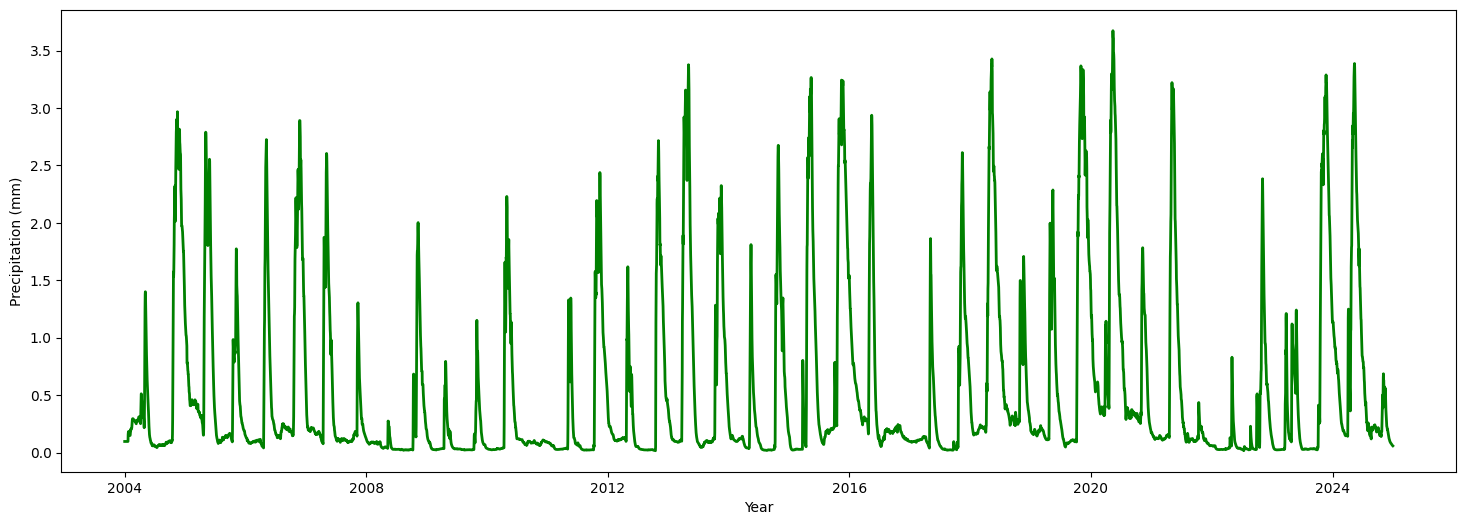

In [6]:
plt.figure(figsize=(18, 6))  # Adjust width and height as needed
plt.plot(et_poi.time, et_poi.values, color='green', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()

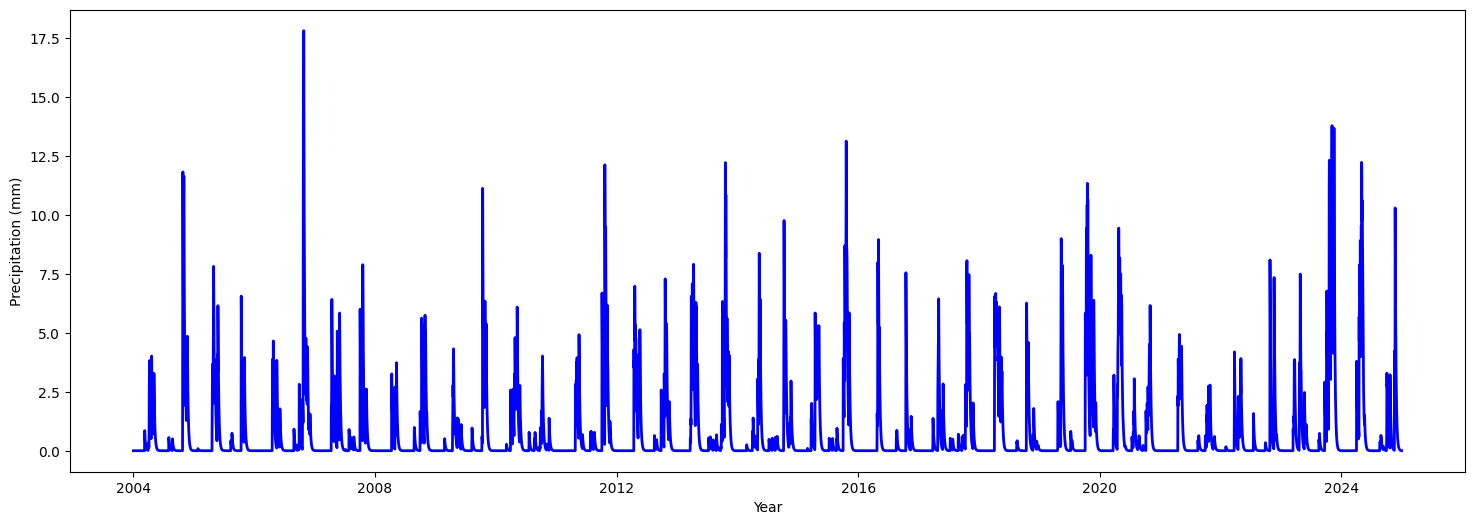

In [81]:
plt.figure(figsize=(18, 6))  # Adjust width and height as needed
plt.plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()

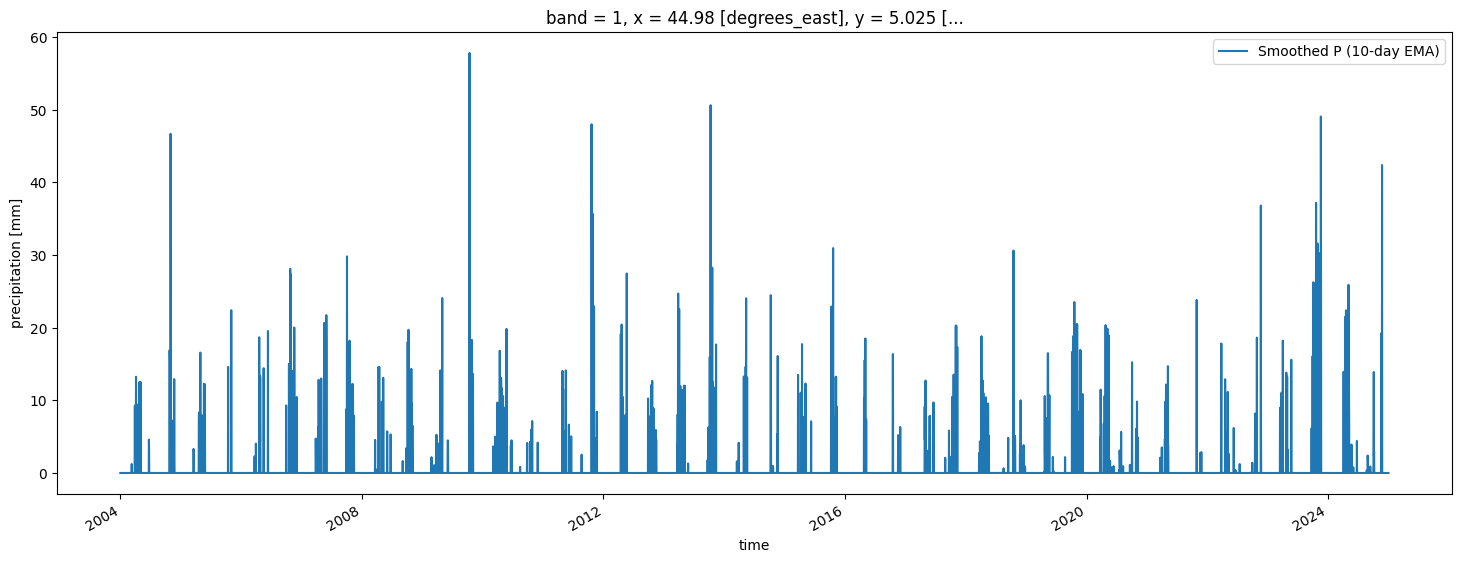

In [8]:
lat = 5
lon = 45
plt.figure(figsize=(18, 6))
precipitation_data.sel(y=lat, x=lon, method='nearest').plot(label='Smoothed P (10-day EMA)')
# et_smoothed.sel(y=lat, x=lon, method='nearest').plot(label='Smoothed ET (10-day EMA)')
# tws_daily.sel(y=5, x=45, method='nearest').plot(label='Interpolated TWS')
plt.legend()
plt.show()



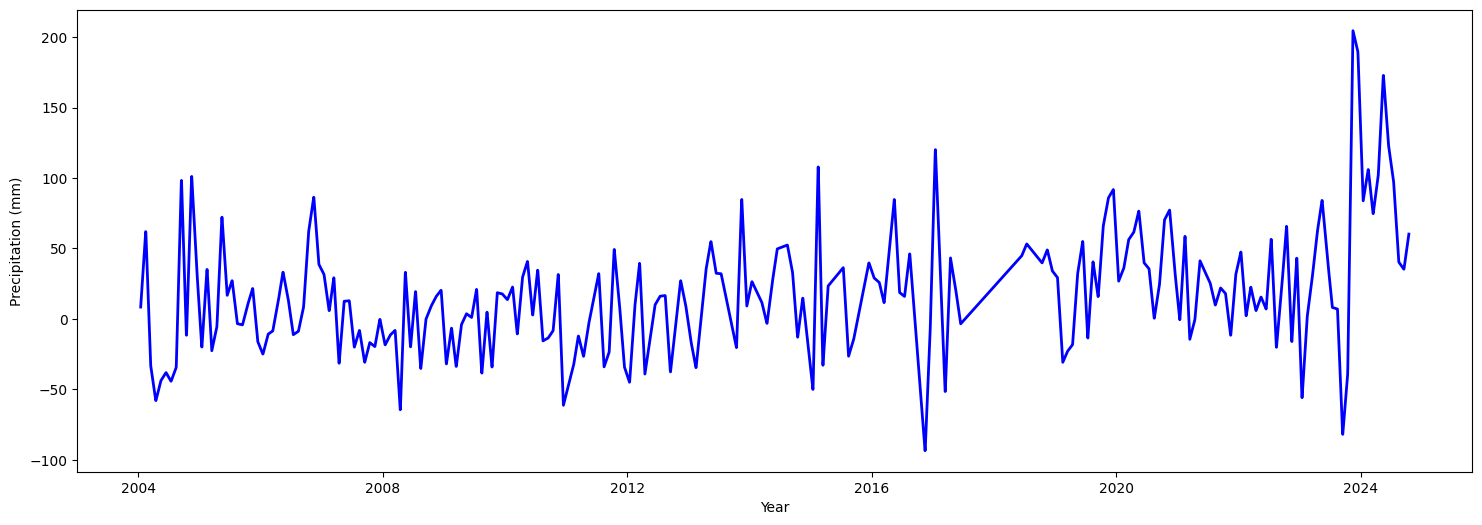

In [45]:
plt.figure(figsize=(18, 6))  # Adjust width and height as needed
plt.plot(tws_poi.time, tws_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()

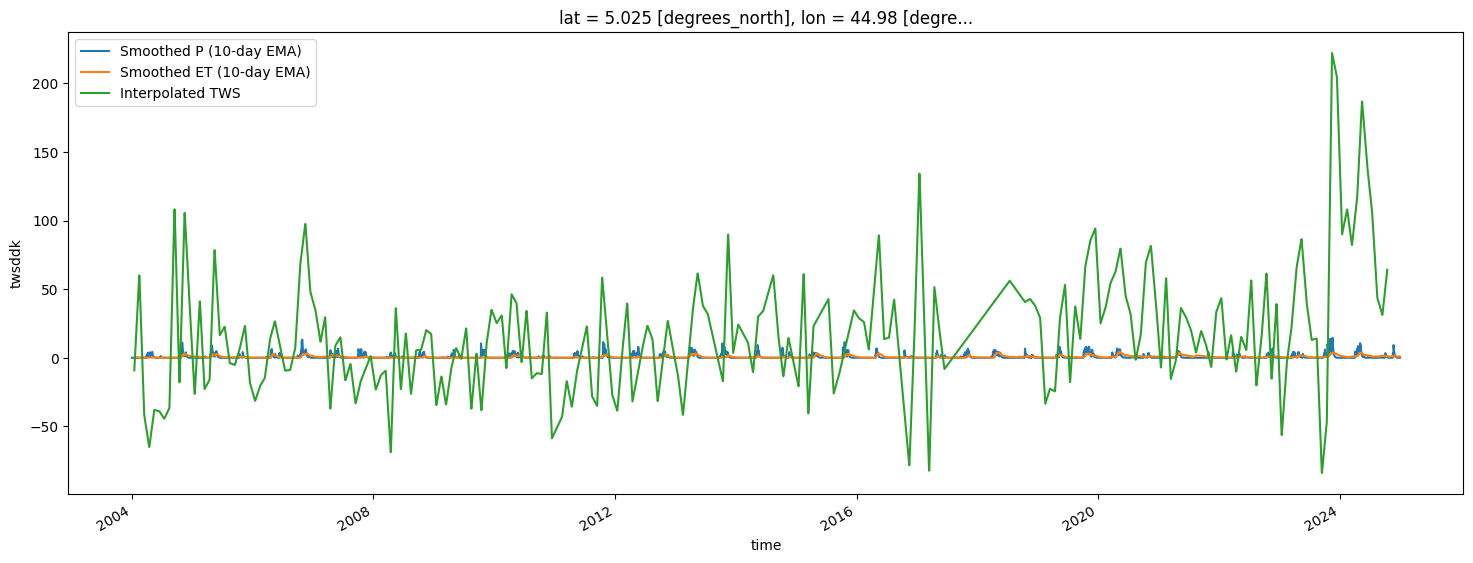

In [42]:
lat = 5
lon = 45
plt.figure(figsize=(18, 6))
precipitation_smoothed.sel(y=lat, x=lon, method='nearest').plot(label='Smoothed P (10-day EMA)')
et_smoothed.sel(y=lat, x=lon, method='nearest').plot(label='Smoothed ET (10-day EMA)')
tws_daily.sel(y=5, x=45, method='nearest').plot(label='Interpolated TWS')
plt.legend()
plt.show()

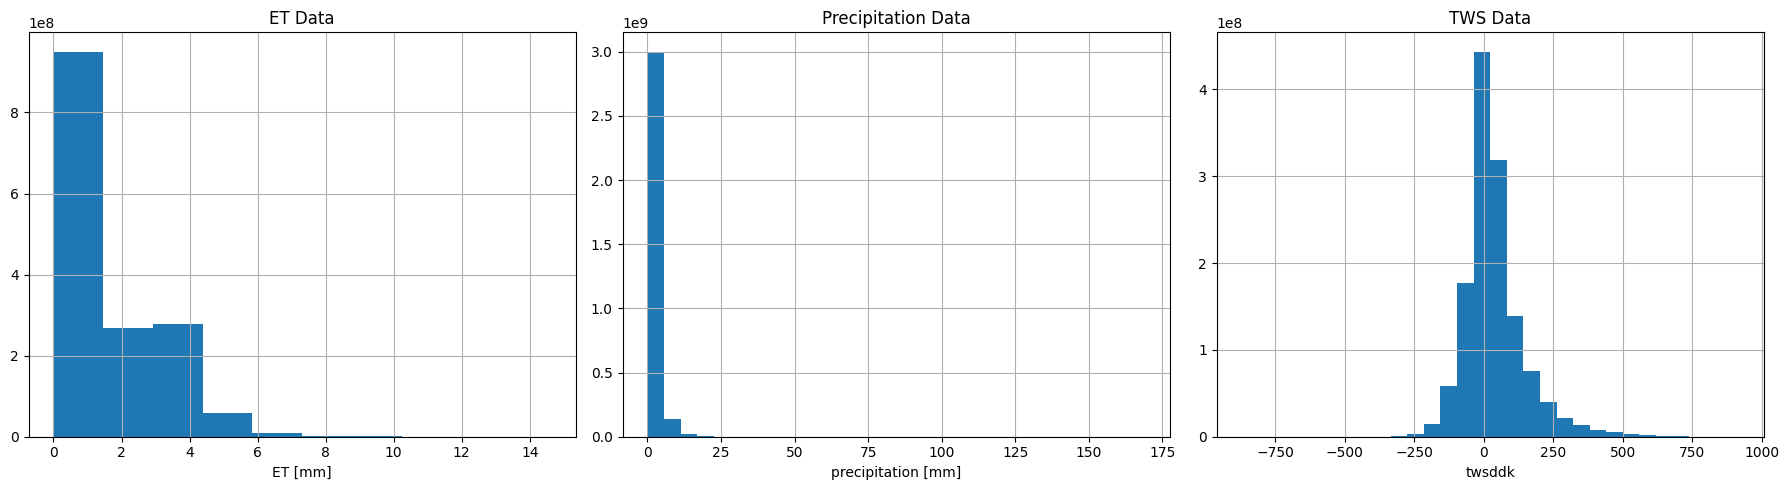

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et.plot.hist(ax=axes[0], bins=10)
axes[0].grid(True)
axes[0].set_title('ET Data')

precipitation.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

#### Spatial Plots

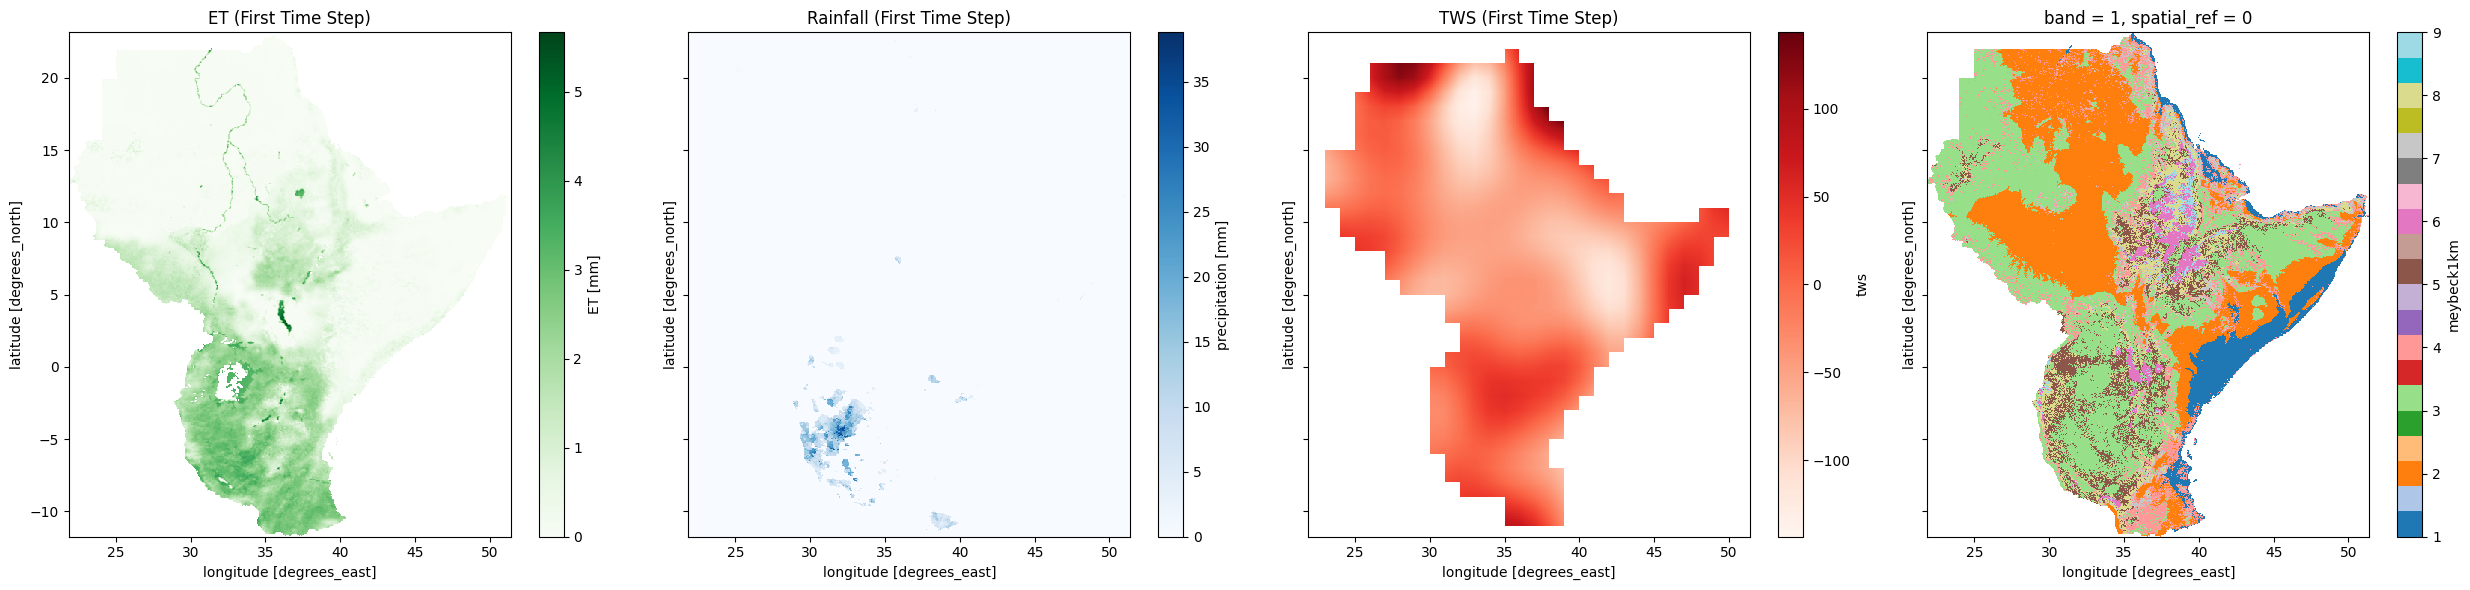

In [7]:
# Plot the regrided datasets

et2 = variables.et.isel(time=0)
precip2 = variables.precipitation.isel(time=0)
tws2 = variables.tws.isel(time=15)


# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(25, 6), sharey=True)


# Plot ET
et2.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip2.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws2.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

variables.landform.plot(ax=axes[3], cmap="tab20", add_colorbar=True)

plt.tight_layout()
plt.show()

### Processing

In [9]:
print("Precipitation data type:", type(variables['et'].data))
print("Variables memory usage (GB):", variables.nbytes / 1e9)

Precipitation data type: <class 'dask.array.core.Array'>
Variables memory usage (GB): 63.291893712


In [8]:
landform_classes = np.unique(variables.landform)
landform_2d = variables.landform.squeeze()

In [13]:
# Check the pixel area per zone
for class_value in landform_classes:
    if np.isnan(class_value):
        continue
    mask = landform_2d == class_value
    n_pixels = mask.sum().item()  # Number of True values (valid pixels)
    print(f"Class {class_value}: {n_pixels} pixels")

Class 1.0: 12910 pixels
Class 2.0: 59445 pixels
Class 3.0: 67984 pixels
Class 4.0: 20408 pixels
Class 5.0: 17019 pixels
Class 6.0: 5569 pixels
Class 7.0: 6771 pixels
Class 8.0: 13514 pixels
Class 9.0: 2475 pixels


#### Stacked dims Approach

In [74]:
#stack varaibles over x,y
dsst=variables.stack(yx=['y','x'])
month = variables.time.dt.month

In [76]:
display((dsst))

<xarray.Dataset>
Dimensions:        (time: 7671, yx: 412518)
Coordinates:
    band           int64 ...
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (yx) float64 dask.array<chunksize=(103425,), meta=np.ndarray>
    lon            (yx) float64 dask.array<chunksize=(102834,), meta=np.ndarray>
  * yx             (yx) object MultiIndex
  * y              (yx) float64 23.12 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * x              (yx) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
Data variables:
    precipitation  (time, yx) float32 dask.array<chunksize=(500, 25413), meta=np.ndarray>
    et             (time, yx) float64 dask.array<chunksize=(500, 25413), meta=np.ndarray>
    tws            (time, yx) float64 dask.array<chunksize=(500, 25413), meta=np.ndarray>
    landform       (yx) float64 dask.array<chunksize=(25413,), meta=np.ndarray>

In [85]:

for region_val in range(9):
    idx=dsst.landform == region_val
    
    region_et_mean=dsst.et[:,idx].groupby('time.month').mean(skipna=True)
    region_et_std=dsst.et[:,idx].groupby('time.month').std(skipna=True)
    
#     #apply normalization
#     dsst.et[:,idx]-=region_et_mean.sel(month=month)
#     dsst.et[:,idx]/=region_et_std.sel(month=month)
#     break
# dsvarnew=dsst.unstack('yx')

In [ ]:
display(dsvarnew)

In [67]:
region_et_mean.compute()

<xarray.DataArray 'et' ()>
array(2.20386291)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

### Anomalies calculated on Chunk

In [4]:
# Anomaly function for stacked data
def calc_standardized_anomalies(data, var_name):
    month = data.time.dt.month
    monthly_clim = data[var_name].groupby('time.month').mean('time', skipna=True)
    monthly_std = data[var_name].groupby('time.month').std('time', skipna=True)
    monthly_std = monthly_std.where(monthly_std > 0, 1e-6)
    anomaly = data[var_name] - monthly_clim.sel(month=month)
    standardized_anomaly = anomaly / monthly_std.sel(month=month)
    return standardized_anomaly

In [11]:
# Process subregions and combine into one dataset
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes')
subregion_list = []
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    for subregion_id in landform_classes[:2]:
        if np.isnan(subregion_id):
            continue
        print(f"Processing subregion {subregion_id}...")

        # Extract subregion
        mask = variables['landform'] == subregion_id
        subregion_ds = variables.where(mask, drop=True)

        # Stack spatial dimensions
        stacked_ds = subregion_ds.stack(points=['y', 'x'])

        # Debug raw data
        print(f"Subregion {subregion_id} raw stats:")
        print(f"Precip min/max: {stacked_ds['precipitation'].min().values:.2f}/{stacked_ds['precipitation'].max().values:.2f}")
        print(f"Precip NaN count: {stacked_ds['precipitation'].isnull().sum().compute()}")

        # Compute anomalies on stacked data
        stacked_ds['precip_anom'] = calc_standardized_anomalies(stacked_ds, 'precipitation')
        stacked_ds['et_anom'] = calc_standardized_anomalies(stacked_ds, 'et')
        stacked_ds['tws_anom'] = calc_standardized_anomalies(stacked_ds, 'tws')

        # Add subregion coordinate
        stacked_ds = stacked_ds.assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
        subregion_list.append(stacked_ds)

# Combine all subregions into one dataset
all_subregions_ds= xr.concat(subregion_list, dim='subregion')

# Inspect combined dataset
print("Combined subregions dataset:")
print(all_subregions_ds)

Extracted Landform classes
Processing subregion 1.0...
Subregion 1.0 raw stats:
Precip min/max: 0.00/169.07
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(1635587607)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Processing subregion 2.0...
Subregion 2.0 raw stats:
Precip min/max: 0.00/102.17
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(2401429563)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Combined subregions dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, points: 380825, subregion: 2)
Coordinates:
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
  * points         (points) object MultiIndex
  * y              (points) float64 -11.73 -11.73 -11.73 ... 23.12 23.12 23.12
  * x              (points) float64 23.28 23.33 23.38 ... 51.28 51.33 51.38
  * subregion      (subregion) int64 1 2
    band           int64 1
    spatial_ref    int64 0
    lat            (subregion, points) float64 nan nan nan nan ... nan nan nan
    lon            (subregion, points) float64 nan nan nan nan ... nan nan nan
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precipitation  (subregion, time, points) float32 dask.array<chunksize=(1, 7671, 23601), meta=np.ndarray>
    et             (subregion, time, points) float64 dask.array<chunksize=(1, 7671, 23601), meta=np.ndarray>
    tws            (subregion, t

In [13]:
subregion_2 = all_subregions_ds.sel(subregion=2)
subregion_2

<xarray.Dataset>
Dimensions:        (time: 7671, points: 380825)
Coordinates:
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
  * points         (points) object MultiIndex
  * y              (points) float64 -11.73 -11.73 -11.73 ... 23.12 23.12 23.12
  * x              (points) float64 23.28 23.33 23.38 ... 51.28 51.33 51.38
    subregion      int64 2
    band           int64 1
    spatial_ref    int64 0
    lat            (points) float64 -11.73 -11.73 -11.73 -11.73 ... nan nan nan
    lon            (points) float64 23.28 23.33 23.38 23.43 ... nan nan nan nan
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precipitation  (time, points) float32 dask.array<chunksize=(7671, 23601), meta=np.ndarray>
    et             (time, points) float64 dask.array<chunksize=(7671, 23601), meta=np.ndarray>
    tws            (time, points) float64 dask.array<chunksize=(7671, 23601), meta=np.ndarray>
    landform       (points) float64 dask.array<chunksize=(23601,), meta=np.ndarray>
    precip_anom    (time, points) float32 dask.array<chunksize=(31, 23601), meta=np.ndarray>
    et_anom        (time, points) float64 dask.array<chunksize=(31, 23601), meta=np.ndarray>
    tws_anom       (time, points) float64 dask.array<chunksize=(31, 23601), meta=np.ndarray>

In [17]:
subregion_list

[<xarray.Dataset>
 Dimensions:        (subregion: 1, time: 7671, points: 226127)
 Coordinates:
     band           int64 1
   * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
     spatial_ref    int64 0
     lat            (points) float64 dask.array<chunksize=(57964,), meta=np.ndarray>
     lon            (points) float64 dask.array<chunksize=(75151,), meta=np.ndarray>
   * points         (points) object MultiIndex
   * y              (points) float64 23.12 23.12 23.12 ... -11.38 -11.38 -11.38
   * x              (points) float64 30.33 30.38 30.48 ... 51.28 51.33 51.38
     month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
   * subregion      (subregion) int64 1
 Data variables:
     precipitation  (subregion, time, points) float32 dask.array<chunksize=(1, 7671, 19209), meta=np.ndarray>
     et             (subregion, time, points) float64 dask.array<chunksize=(1, 7671, 19209), meta=np.ndarray>
     tws            (subregion, time,

In [19]:
# Process subregions and combine into one dataset
landform_classes = np.unique(variables_chunk['landform'].values[~np.isnan(variables_chunk['landform'].values)])
print('Extracted Landform classes')
subregion_list_chunk = []
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    for subregion_id in landform_classes[:2]:
        if np.isnan(subregion_id):
            continue
        print(f"Processing subregion {subregion_id}...")

        # Extract subregion
        mask = variables['landform'] == subregion_id
        subregion_ds = variables.where(mask, drop=True)

        # Stack spatial dimensions
        stacked_ds = subregion_ds.stack(points=['y', 'x'])

        # Debug raw data
        print(f"Subregion {subregion_id} raw stats:")
        print(f"Precip min/max: {stacked_ds['precipitation'].min().values:.2f}/{stacked_ds['precipitation'].max().values:.2f}")
        print(f"Precip NaN count: {stacked_ds['precipitation'].isnull().sum().compute()}")

        # Compute anomalies on stacked data
        stacked_ds['precip_anom'] = calc_standardized_anomalies(stacked_ds, 'precipitation')
        stacked_ds['et_anom'] = calc_standardized_anomalies(stacked_ds, 'et')
        stacked_ds['tws_anom'] = calc_standardized_anomalies(stacked_ds, 'tws')

        # Add subregion coordinate
        stacked_ds = stacked_ds.assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
        subregion_list_chunk.append(stacked_ds)

# Combine all subregions into one dataset
all_subregions_chunk= xr.concat(subregion_list_chunk, dim='subregion')

# Inspect combined dataset
print("Combined subregions dataset:")
print(all_subregions_ds)

Extracted Landform classes
Processing subregion 1.0...
Subregion 1.0 raw stats:
Precip min/max: 0.00/169.07
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(1635587607)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Processing subregion 2.0...
Subregion 2.0 raw stats:
Precip min/max: 0.00/102.17
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(2401429563)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Combined subregions dataset:
<xarray.Dataset>
Dimensions:        (time: 7671, points: 380825, subregion: 2)
Coordinates:
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
  * points         (points) object MultiIndex
  * y              (points) float64 -11.73 -11.73 -11.73 ... 23.12 23.12 23.12
  * x              (points) float64 23.28 23.33 23.38 ... 51.28 51.33 51.38
  * subregion      (subregion) int64 1 2
    band           int64 1
    spatial_ref    int64 0
    lat            (subregion, points) float64 nan nan nan nan ... nan nan nan
    lon            (subregion, points) float64 nan nan nan nan ... nan nan nan
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precipitation  (subregion, time, points) float32 dask.array<chunksize=(1, 7671, 23601), meta=np.ndarray>
    et             (subregion, time, points) float64 dask.array<chunksize=(1, 7671, 23601), meta=np.ndarray>
    tws            (subregion, t

In [276]:
# First two subregions
subregion_store

{1.0: <xarray.Dataset>
 Dimensions:        (time: 7671, y: 671, x: 337)
 Coordinates:
     band           int64 1
   * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
   * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
   * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
     spatial_ref    int64 0
     lat            (y) float64 dask.array<chunksize=(172,), meta=np.ndarray>
     lon            (x) float64 dask.array<chunksize=(44,), meta=np.ndarray>
     month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
 Data variables:
     precipitation  (time, y, x) float32 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
     et             (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
     tws            (time, y, x) float64 dask.array<chunksize=(500, 172, 44), meta=np.ndarray>
     landform       (y, x) float64 dask.array<chunksize=(172, 44), meta=np.ndarra

In [39]:
# Load dataset with optimized chunking
variables = xr.open_dataset(os.path.join(dataset, 'daily_dataset'), chunks={'time': 500, 'y': 100, 'x': 100})
print("Variables loaded with chunks:", variables.chunks)

# Anomaly function
def calc_standardized_anomalies(data, var_name):
    month = data.time.dt.month
    monthly_clim = data[var_name].groupby('time.month').mean('time', skipna=True)
    monthly_std = data[var_name].groupby('time.month').std('time', skipna=True)
    monthly_std = monthly_std.where(monthly_std > 0, 1e-6)
    anomaly = data[var_name] - monthly_clim.sel(month=month)
    standardized_anomaly = anomaly / monthly_std.sel(month=month)
    return standardized_anomaly

# Process subregions and combine
landform_classes = np.unique(variables['landform'].values[~np.isnan(variables['landform'].values)])
print('Extracted Landform classes:', landform_classes)

subregion_list = []
for subregion_id in landform_classes[:2]:  # First 2 subregions
    if np.isnan(subregion_id):
        continue
    print(f"Processing subregion {subregion_id}...")
    
    # Extract subregion
    mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(mask, drop=True)
    
    # Stack spatial dimensions
    stacked_ds = subregion_ds.stack(points=['lat', 'lon'])
    
    # Debug raw data
    print(f"Subregion {subregion_id} raw stats:")
    print(f"Precip min/max: {stacked_ds['precipitation'].min().compute():.2f}/{stacked_ds['precipitation'].max().compute():.2f}")
    print(f"Precip NaN count: {stacked_ds['precipitation'].isnull().sum().compute()}")
    
    # Compute anomalies
    stacked_ds['precip_anom'] = calc_standardized_anomalies(stacked_ds, 'precipitation')
    stacked_ds['et_anom'] = calc_standardized_anomalies(stacked_ds, 'et')
    stacked_ds['tws_anom'] = calc_standardized_anomalies(stacked_ds, 'tws')
    
    # Add subregion coordinate
    stacked_ds = stacked_ds.assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
    subregion_list.append(stacked_ds)

# Combine all subregions
all_subregions_ds = xr.concat(subregion_list, dim='subregion')

# Inspect combined dataset
print("Combined subregions dataset:")
print(all_subregions_ds)

Variables loaded with chunks: Frozen({'time': (500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 171), 'y': (100, 100, 100, 100, 100, 100, 98), 'x': (100, 100, 100, 100, 100, 91)})
Extracted Landform classes: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
Processing subregion 1.0...
Subregion 1.0 raw stats:


/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Precip min/max: 0.00/169.07
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(1635587607)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Processing subregion 2.0...
Subregion 2.0 raw stats:


/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/usr/local/lib/python3.8/dist-packages/dask/array/reductions.py:640: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Precip min/max: 0.00/102.17
Precip NaN count: <xarray.DataArray 'precipitation' ()>
array(2401429563)
Coordinates:
    band         int64 1
    spatial_ref  int64 0


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 21 times more chunks
  return self.array[key]
/home/jovyan/.local/lib/python3.8/s

Combined subregions dataset:
<xarray.Dataset>
Dimensions:        (x: 550, y: 697, time: 7671, points: 380825, subregion: 2)
Coordinates:
  * x              (x) float64 23.28 23.33 23.38 23.43 ... 51.28 51.33 51.38
  * y              (y) float64 -11.73 -11.68 -11.63 -11.58 ... 23.02 23.07 23.12
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
  * points         (points) object MultiIndex
  * lat            (points) float64 -11.73 -11.73 -11.73 ... 23.12 23.12 23.12
  * lon            (points) float64 23.28 23.33 23.38 ... 51.28 51.33 51.38
  * subregion      (subregion) int64 1 2
    band           int64 1
    spatial_ref    int64 0
    month          (time) int64 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
Data variables:
    precipitation  (subregion, time, y, x) float32 dask.array<chunksize=(1, 500, 98, 60), meta=np.ndarray>
    et             (subregion, time, y, x) float64 dask.array<chunksize=(1, 500, 98, 60), meta=np.ndarray>
    tws            (

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


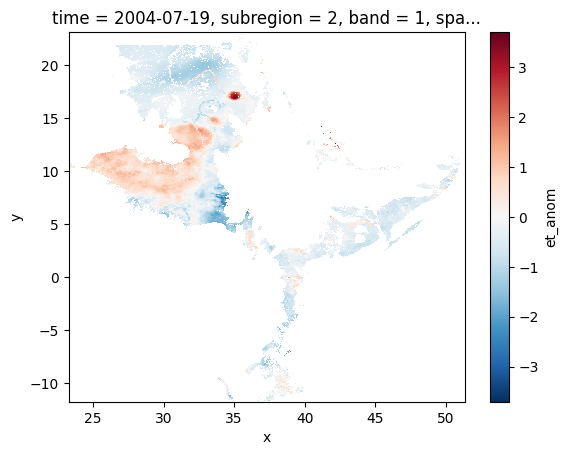

In [43]:
g.isel(subregion=1).et_anom.isel(time=200).plot()

#### Applying `map_blocks`

In [14]:
def calc_anomaly_chunk(chunk, clim, std):
    month = chunk.time.dt.month  # Still compute month for selection
    result = xr.Dataset()
    for var in ['precipitation', 'et', 'tws']:
        # Select climatology/std without keeping 'month' as a coordinate
        clim_sel = clim[var].sel(month=month, drop=True)  # drop=True removes 'month'
        std_sel = std[var].sel(month=month, drop=True)
        anomaly = chunk[var] - clim_sel
        result[f'{var}_anom'] = anomaly / std_sel
    return result

In [16]:
subregion_store = {}
for subregion_id in landform_classes[:2]:
    if np.isnan(subregion_id):
        continue
    print(f"Processing subregion {subregion_id}...")
    
    # Extract subregion
    mask = variables['landform'] == subregion_id
    subregion_ds = variables.where(mask, drop=True)
    
    subregion_store[subregion_id] = subregion_ds
    
     
    # Precompute climatology for full subregion time series
    clim = subregion_ds.groupby('time.month').mean('time', skipna=True).compute()
    std = subregion_ds.groupby('time.month').std('time', skipna=True).compute()
    
    # Define template
    template = xr.Dataset({
        'precip_anom': subregion_ds['precipitation'],
        'et_anom': subregion_ds['et'],
        'tws_anom': subregion_ds['tws']
    })
    
    # Apply map_blocks with precomputed clim/std
    anomaly_ds = subregion_ds.map_blocks(calc_anomaly_chunk, args=(clim, std), template=template)
    anomaly_ds = anomaly_ds.compute()
    
#     # Inspect
#     print(f"Subregion {subregion_id} anomalies:")
#     print(f"Precip mean: {anomaly_ds['precip_anom'].mean().values:.2f}, std: {anomaly_ds['precip_anom'].std().values:.2f}")
#     print(f"ET mean: {anomaly_ds['et_anom'].mean().values:.2f}, std: {anomaly_ds['et_anom'].std().values:.2f}")
#     print(f"TWS mean: {anomaly_ds['tws_anom'].mean().values:.2f}, std: {anomaly_ds['tws_anom'].std().values:.2f}")
    
    

Processing subregion 1.0...


/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


ValueError: Result from applying user function has unexpected coordinate variables {'month'}.

### Anomalies calculated `WITHOUT` Chunk

In [5]:
# Anomaly function for stacked data
def calc_standardized_anomalies(data, var_name):
    month = data.time.dt.month
    monthly_clim = data[var_name].groupby('time.month').mean('time', skipna=True)
    monthly_std = data[var_name].groupby('time.month').std('time', skipna=True)
    anomaly = data[var_name] - monthly_clim.sel(month=month)
    standardized_anomaly = anomaly / monthly_std.sel(month=month)
    return standardized_anomaly

In [ ]:
# Process subregions and combine into one dataset
landform_classes = np.unique(input_vars['landform'].values[~np.isnan(input_vars['landform'].values)])
subregion_list = []

for subregion_id in landform_classes[:2]:
    if np.isnan(subregion_id):
        continue
    print(f"Processing subregion {subregion_id}...")
    
    # Extract subregion
    mask = input_vars['landform'] == subregion_id
    subregion_ds = input_vars.where(mask, drop=True)
    
    # Stack spatial dimensions
    stacked_ds = subregion_ds.stack(points=['lat', 'lon'])
    
    # Debug raw data
    print(f"Subregion {subregion_id} raw stats:")
    print(f"Precip min/max: {stacked_ds['precipitation'].min().values:.2f}/{stacked_ds['precipitation'].max().values:.2f}")
    print(f"Precip NaN count: {stacked_ds['precipitation'].isnull().sum().values}")
    
    # Compute anomalies on stacked data
    stacked_ds['precip_anom'] = calc_standardized_anomalies(stacked_ds, 'precipitation')
    stacked_ds['et_anom'] = calc_standardized_anomalies(stacked_ds, 'et')
    stacked_ds['tws_anom'] = calc_standardized_anomalies(stacked_ds, 'tws')
    
    # Add subregion coordinate
    stacked_ds = stacked_ds.assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
    subregion_list.append(stacked_ds)

# Combine all subregions into one dataset
all_subregions_ds_sample = xr.concat(subregion_list, dim='subregion')

# Inspect combined dataset
print("Combined subregions dataset:")
print(all_subregions_ds_sample)

# # Plot example: subregion 2, first point
# subregion_2 = all_subregions_ds_sample.sel(subregion=2)
# subregion_2['precip_anom'].isel(points=0).plot(label='Precip Anomaly')
# subregion_2['et_anom'].isel(points=0).plot(label='ET Anomaly')
# subregion_2['tws_anom'].isel(points=0).plot(label='TWS Anomaly')
# plt.legend()
# plt.title("Standardized Anomalies (Subregion 2, First Point)")
# plt.show()

%time

Processing subregion 1.0...


In [146]:
# Save sampled CDFs
np.savez(f"sampled_cdf_region_3.npz", x_vals=sampled_x, y_vals=sampled_y)

### Standardization Anomalies [Original Data]

In [7]:
def calc_standardized_anomalies(data, var_name):
    month = data.time.dt.month
    monthly_clim = data[var_name].groupby('time.month').mean('time', skipna=True)
    monthly_std = data[var_name].groupby('time.month').std('time', skipna=True)

    anomaly = data[var_name] - monthly_clim.sel(month=month)
    standardized_anomaly = anomaly / monthly_std.sel(month=month)
    
    return standardized_anomaly


In [52]:
# Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['tws_anom'] = calc_standardized_anomalies(ds, 'tws')
    ds['precip_anom'] = calc_standardized_anomalies(ds, 'precip')
    ds['et_anom'] = calc_standardized_anomalies(ds, 'et')
    
    # Update the dataset
    subregion_datasets[subregion_id] = ds

# Check anomalies for subregion 1
print(subregion_datasets[1][['tws_anom', 'precip_anom', 'et_anom']])
%time

<xarray.Dataset>
Dimensions:      (y: 671, x: 337, time: 219)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    spatial_ref  int64 0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws_anom     (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip_anom  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et_anom      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan


UsageError: Line magic function `%%time` not found.


In [ ]:
lat = 5
lon = 45

# Anomaly function for stacked data
def calc_standardized_anomalies(data, var_name):
    month = data.time.dt.month
    monthly_clim = data[var_name].groupby('time.month').mean('time', skipna=True)
    monthly_std = data[var_name].groupby('time.month').std('time', skipna=True)
    anomaly = data[var_name] - monthly_clim.sel(month=month)
    standardized_anomaly = anomaly / monthly_std.sel(month=month)
    return standardized_anomaly

# Process anomalies per subregion
for subregion_id, ds in subregion_datasets.items():
    print(f"Calculating anomalies for subregion {subregion_id}...")
    
    # Compute anomalies
    ds['precip_anom'] = calc_standardized_anomalies(ds, 'precipitation')
    ds['et_anom'] = calc_standardized_anomalies(ds, 'et')
    ds['tws_anom'] = calc_standardized_anomalies(ds, 'tws')
    
    # Save to NetCDF
    output_file = os.path.join(dataset, f'subregion_{subregion_id}.nc')
    ds.to_netcdf(output_file)
    print(f"Saved subregion {subregion_id} to {output_file}")
    

Calculating anomalies for subregion 1...
Saved subregion 1 to ../../datasets/subregion_1.nc
Calculating anomalies for subregion 2...
Saved subregion 2 to ../../datasets/subregion_2.nc
Calculating anomalies for subregion 3...
Saved subregion 3 to ../../datasets/subregion_3.nc
Calculating anomalies for subregion 4...


In [4]:
# Open processed zone
zone_1 =  xr.open_dataset(os.path.join(dataset, 'subregion_1.nc'))
zone_2 =  xr.open_dataset(os.path.join(dataset, 'subregion_2.nc'), chunks={'time': 500, 'y': 175, 'x': 148})
zone_3 =  xr.open_dataset(os.path.join(dataset, 'subregion_3.nc'), chunks={'time': 500, 'y': 175, 'x': 148})

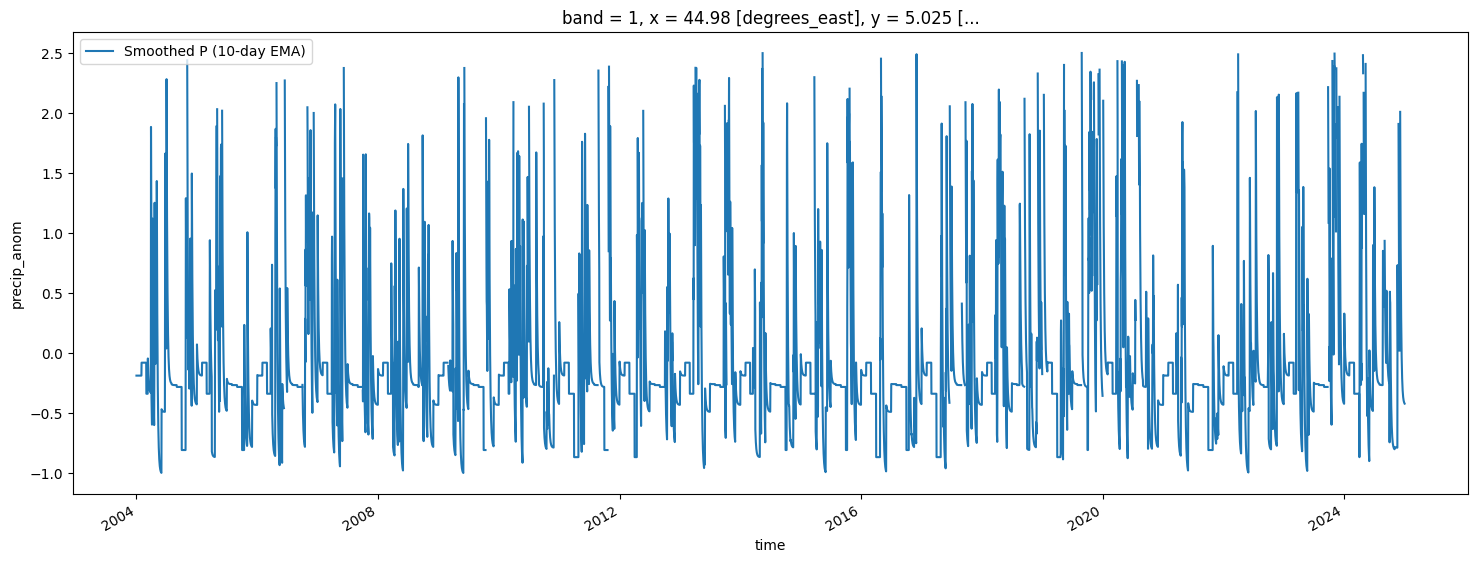

In [224]:
lat = 5
lon = 45
plt.figure(figsize=(18, 6))
zone_1.precip_anom.where(zone_1.precip_anom < 2.5).sel(y=lat, x=lon, method='nearest').plot(label='Smoothed P (10-day EMA)')
# zone_1.et_anom.where(zone_1.et_anom < 2.5).sel(y=lat, x=lon, method='nearest').plot(label='Smoothed ET (10-day EMA)')
# zone_1.tws_anom.sel(y=5, x=45, method='nearest').plot(label='Interpolated TWS')
plt.legend()
plt.show()

Text(0.5, 1.0, 'TWS (First Time Step)')

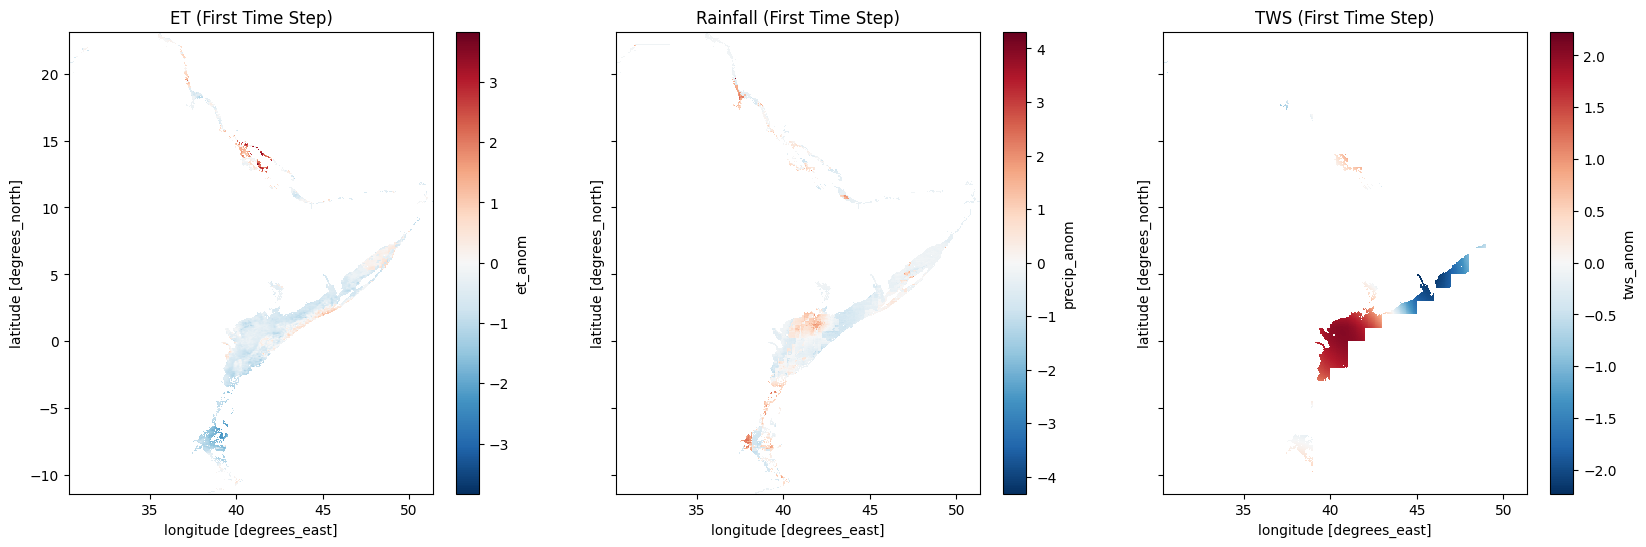

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
zone_1.et_anom.isel(time=200).plot(ax=axes[0], add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
zone_1.precip_anom.isel(time=200).plot(ax=axes[1], add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
zone_1.tws_anom.isel(time=200).plot(ax=axes[2], add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

Text(0.5, 1.0, 'TWS (First Time Step)')

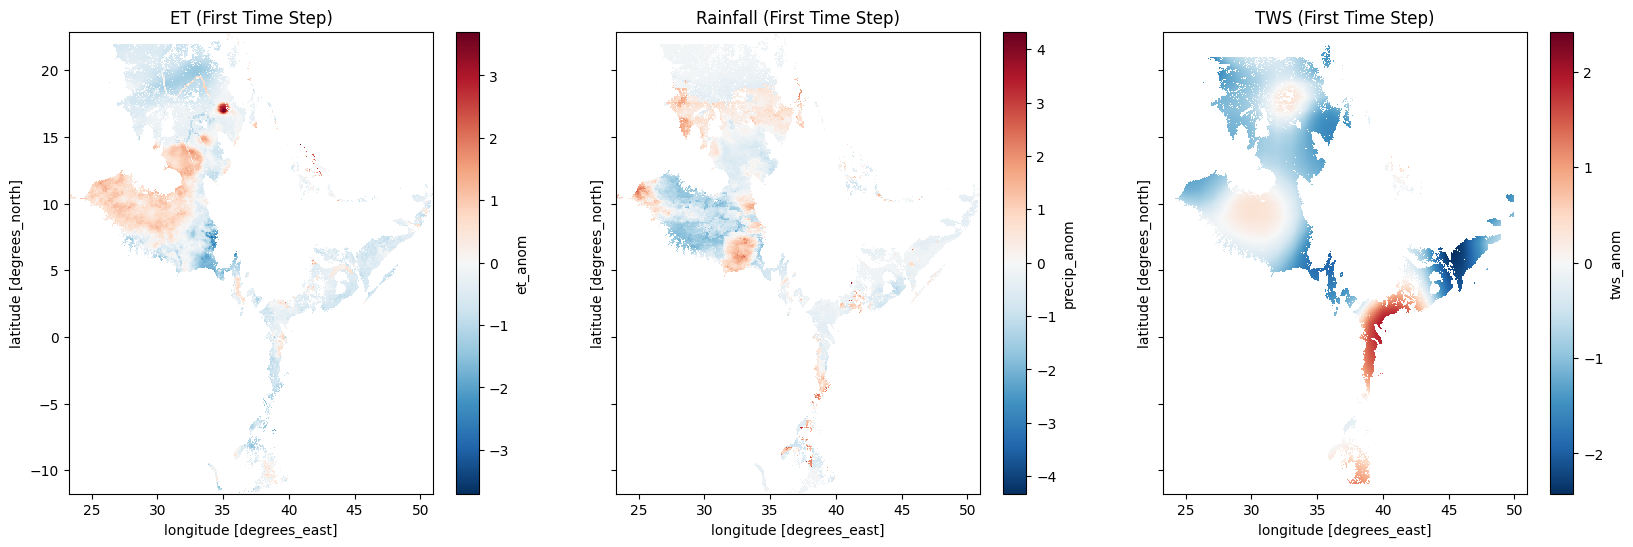

In [160]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
zone_2.et_anom.isel(time=200).plot(ax=axes[0], add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
zone_2.precip_anom.isel(time=200).plot(ax=axes[1], add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
zone_2.tws_anom.isel(time=200).plot(ax=axes[2], add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

Text(0.5, 1.0, 'TWS (First Time Step)')

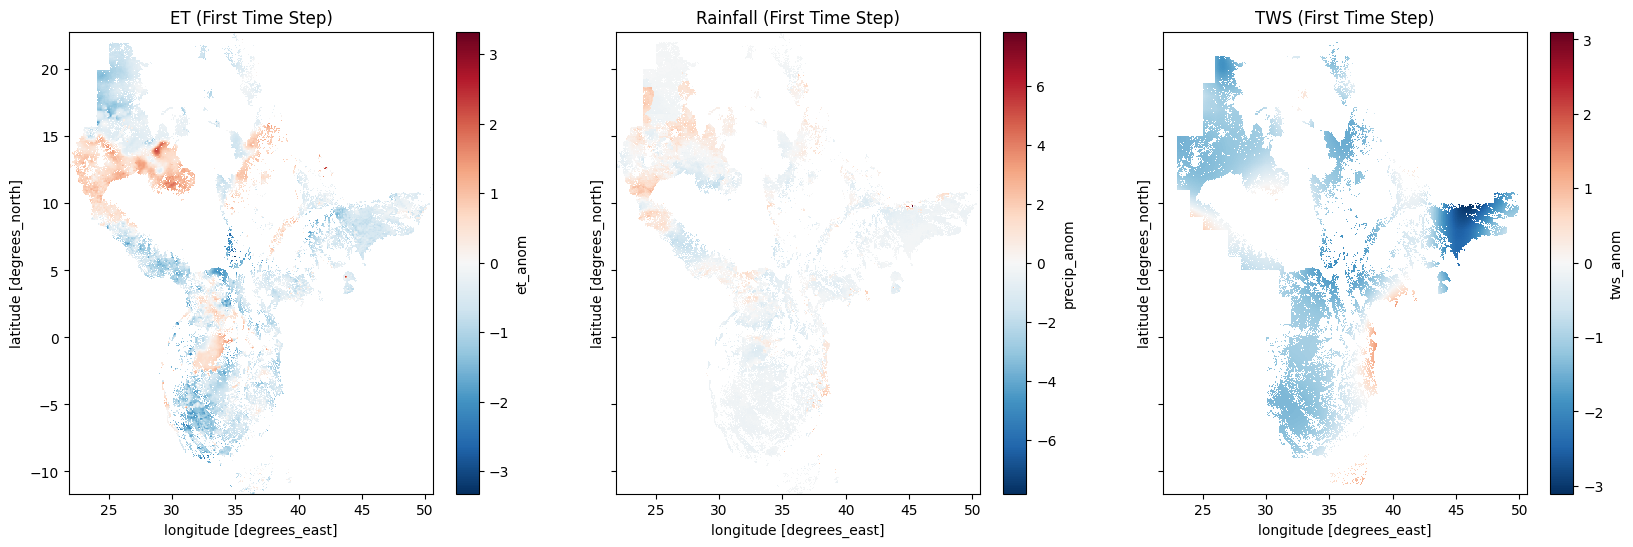

In [161]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
zone_3.et_anom.isel(time=200).plot(ax=axes[0], add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
zone_3.precip_anom.isel(time=200).plot(ax=axes[1], add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
zone_3.tws_anom.isel(time=200).plot(ax=axes[2], add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

In [255]:
sub_region3 = all_subregions_ds.isel(subregion=2)

Text(0.5, 1.0, 'TWS (First Time Step)')

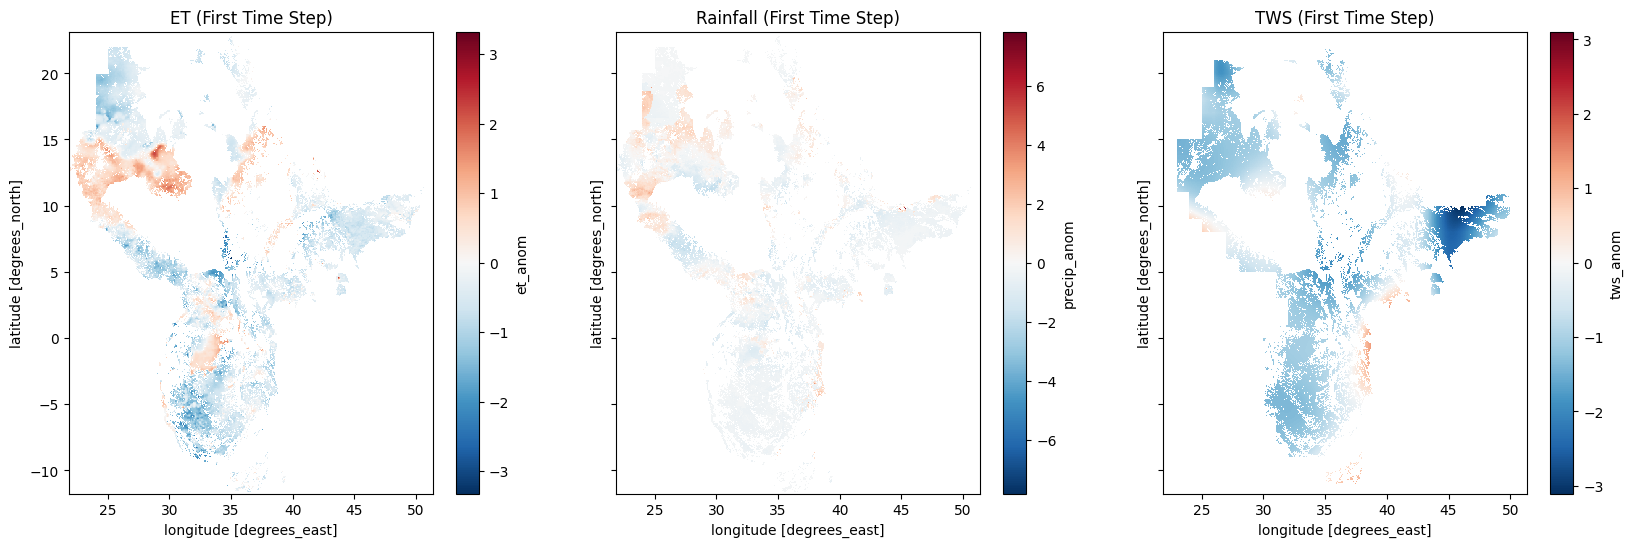

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
sub_region3.et_anom.isel(time=200).plot(ax=axes[0], add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
sub_region3.precip_anom.isel(time=200).plot(ax=axes[1], add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
sub_region3.tws_anom.isel(time=200).plot(ax=axes[2], add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

#### Testing for Zone 1 `without Chunking`

In [219]:
zone_1.et_

<xarray.Dataset>
Dimensions:        (x: 337, y: 671, time: 7671)
Coordinates:
    band           int64 ...
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * time           (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2024-12-31
    spatial_ref    int64 ...
    lat            (y) float64 ...
    lon            (x) float64 ...
    month          (time) int64 ...
Data variables:
    precipitation  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    et             (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tws            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    precip_anom    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    et_anom        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    tws_anom       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [218]:
ecdf_dict = {}
for var in ['precip_anom', 'et_anom']:
    stacked = zone_1[var].compute().values.flatten()
    stacked = stacked[~np.isnan(stacked)]
        
    if len(stacked) == 0:
        print(f"Warning: No valid data for {var} in Zone")
        # ecdf_values = np.full(200, np.nan)
        # anom_points = np.linspace(-1, 1, 200)
    else:
        print(f"Subregion Zone - {var} valid points: {len(stacked)}")
        ecdf_func = ECDF(stacked)
        anom_min, anom_max = np.nanmin(stacked), np.nanmax(stacked)
        anom_points = np.linspace(anom_min, anom_max, 100)
        ecdf_values = ecdf_func(anom_points)
        
    ecdf_dict[f'{var.split("_")[0]}_ecdf'] = xr.DataArray(
        ecdf_values,
        coords={'ecdf_points': anom_points},
        dims=['ecdf_points']
    )
    
# subregion_ecdf_ds = xr.Dataset(ecdf_dict).assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
# ecdf_ds_list.append(subregion_ecdf_ds)

# # Combine ECDFs
# all_ecdf_ds = xr.concat(ecdf_ds_list, dim='subregion')
print("ECDF dataset:")
print(ecdf_dict)


Subregion Zone - precip_anom valid points: 96562548
Subregion Zone - et_anom valid points: 93279332
ECDF dataset:
{'precip_ecdf': <xarray.DataArray (ecdf_points: 100)>
array([1.03559819e-08, 7.11455957e-06, 1.59192154e-04, 1.47617273e-03,
       1.69689495e-02, 1.09115254e-01, 3.26864480e-01, 5.98183314e-01,
       7.34979694e-01, 7.97282938e-01, 8.43843702e-01, 8.79393945e-01,
       9.06593921e-01, 9.27469116e-01, 9.43494180e-01, 9.55745058e-01,
       9.65148258e-01, 9.72349974e-01, 9.77927571e-01, 9.82249857e-01,
       9.85648401e-01, 9.88320596e-01, 9.90419132e-01, 9.92083836e-01,
       9.93408645e-01, 9.94479205e-01, 9.95351593e-01, 9.96064789e-01,
       9.96650596e-01, 9.97143023e-01, 9.97560141e-01, 9.97902738e-01,
       9.98192301e-01, 9.98437914e-01, 9.98653163e-01, 9.98839819e-01,
       9.98993647e-01, 9.99123118e-01, 9.99233233e-01, 9.99329740e-01,
       9.99414825e-01, 9.99491418e-01, 9.99559042e-01, 9.99615907e-01,
       9.99663979e-01, 9.99706408e-01, 9.99744746e-

In [229]:
# Function to compute ECDF with a common mask
def compute_ecdf_statsmodels_consistent(ds):
    '''Parameters:
        ds (xarray.Dataset): Input dataset containing 'tws_anom', 'precip_anom', and 'et_anom'.

    Returns:
        tws_cdf (xarray.DataArray): ECDF values for TWS anomaly.
        precip_cdf (xarray.DataArray): ECDF values for precipitation anomaly.
        et_cdf (xarray.DataArray): ECDF values for ET anomaly.
    '''
    # Convert the selected variables to a single DataArray with 'variable' dimension
    data_vars = ds[['tws_anom', 'precip_anom', 'et_anom']].to_array(dim='variable')
    
    # Stack spatial and temporal dimensions
    stacked_data = data_vars.stack(all_points=['time', 'y', 'x'])
    
    # Create a common mask where all variables are non-NaN
    common_mask = stacked_data.notnull().all(dim='variable')
    valid_data = stacked_data.where(common_mask, drop=True)
    # print(valid_data)
    
    # Compute ECDF for each variable
    ecdf_dict = {}
    for var_name in ['tws_anom', 'precip_anom', 'et_anom']:
        flat_data = valid_data.sel(variable=var_name).values
        ecdf = ECDF(flat_data)
        anom_points = np.linspace(np.min(flat_data), np.max(flat_data), 500)
        cdf_values = ecdf(anom_points)
        ecdf_dict[var_name] = xr.DataArray(
            cdf_values,
            coords={'all_points': anom_points},
            dims=['all_points']
        )
    
    return ecdf_dict['tws_anom'], ecdf_dict['precip_anom'], ecdf_dict['et_anom']



In [230]:
zone_one = zone_1.copy()
compute_ecdf_statsmodels_consistent(zone_one)

(<xarray.DataArray (all_points: 500)>
 array([2.09168561e-08, 2.09168561e-08, 2.09168561e-08, 2.09168561e-08,
        2.09168561e-08, 2.09168561e-08, 2.09168561e-08, 2.09168561e-08,
        4.18337122e-08, 6.27505682e-08, 6.27505682e-08, 8.36674243e-08,
        1.04584280e-07, 1.25501136e-07, 1.46417993e-07, 1.88251705e-07,
        2.09168561e-07, 2.30085417e-07, 2.71919129e-07, 3.13752841e-07,
        3.97420266e-07, 4.18337122e-07, 4.39253978e-07, 4.60170834e-07,
        4.60170834e-07, 5.22921402e-07, 5.22921402e-07, 5.64755114e-07,
        6.06588826e-07, 7.11173107e-07, 8.36674243e-07, 1.08767652e-06,
        1.42234621e-06, 1.79884962e-06, 2.00801818e-06, 2.30085417e-06,
        2.76102500e-06, 3.34669697e-06, 3.93236894e-06, 4.81087690e-06,
        5.68938485e-06, 6.44239167e-06, 7.23723220e-06, 7.88565474e-06,
        8.72232899e-06, 9.47533581e-06, 1.06257629e-05, 1.18389405e-05,
        1.33031205e-05, 1.48928015e-05, 1.68799029e-05, 2.01429324e-05,
        2.39288834e-05, 2.

In [193]:
ecdf_dict = {}
sampled_data = {}
for var in ['precip_anom', 'et_anom', 'tws_anom']:
    stacked = zone_1[var].values.flatten()
    stacked = stacked[~np.isnan(stacked)]
        
    if len(stacked) == 0:
        print(f"Warning: No valid data for {var} in Zone")
        # ecdf_values = np.full(200, np.nan)
        # anom_points = np.linspace(-1, 1, 200)
    else:
        print(f"Subregion Zone - {var} valid points: {len(stacked)}")
        ecdf_func = ECDF(stacked)
        anom_points = np.linspace(0, 1, 1000)
        sampled_points = np.quantile(stacked, anom_points,  method='inverted_cdf')
        # sns.histplot(sampled_points)
        ecdf_values = anom_points
        
    sampled_data[f'{var.split("_")[0]}_sample'] = sampled_points

        
        
    ecdf_dict[f'{var.split("_")[0]}_ecdf'] = xr.DataArray(
        ecdf_values,
        coords={'ecdf_points': anom_points},
        dims=['ecdf_points']
    )
    
# subregion_ecdf_ds = xr.Dataset(ecdf_dict).assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
# ecdf_ds_list.append(subregion_ecdf_ds)

# # Combine ECDFs
# all_ecdf_ds = xr.concat(ecdf_ds_list, dim='subregion')
print("ECDF dataset:")
# print(ecdf_dict)


Subregion Zone - precip_anom valid points: 96562548
Subregion Zone - et_anom valid points: 93279332
Subregion Zone - tws_anom valid points: 48801181
ECDF dataset:


In [232]:
ecdf_dict

{'precip_ecdf': <xarray.DataArray (ecdf_points: 100)>
 array([1.03559819e-08, 7.11455957e-06, 1.59192154e-04, 1.47617273e-03,
        1.69689495e-02, 1.09115254e-01, 3.26864480e-01, 5.98183314e-01,
        7.34979694e-01, 7.97282938e-01, 8.43843702e-01, 8.79393945e-01,
        9.06593921e-01, 9.27469116e-01, 9.43494180e-01, 9.55745058e-01,
        9.65148258e-01, 9.72349974e-01, 9.77927571e-01, 9.82249857e-01,
        9.85648401e-01, 9.88320596e-01, 9.90419132e-01, 9.92083836e-01,
        9.93408645e-01, 9.94479205e-01, 9.95351593e-01, 9.96064789e-01,
        9.96650596e-01, 9.97143023e-01, 9.97560141e-01, 9.97902738e-01,
        9.98192301e-01, 9.98437914e-01, 9.98653163e-01, 9.98839819e-01,
        9.98993647e-01, 9.99123118e-01, 9.99233233e-01, 9.99329740e-01,
        9.99414825e-01, 9.99491418e-01, 9.99559042e-01, 9.99615907e-01,
        9.99663979e-01, 9.99706408e-01, 9.99744746e-01, 9.99778092e-01,
        9.99809833e-01, 9.99840373e-01, 9.99863425e-01, 9.99883371e-01,
        9.

In [195]:
sampled_data

{'precip_sample': array([-2.12916803e+00, -1.34226167e+00, -1.25854886e+00, -1.21437001e+00,
        -1.18214107e+00, -1.15726483e+00, -1.13636112e+00, -1.11838329e+00,
        -1.10283113e+00, -1.08918905e+00, -1.07696486e+00, -1.06578493e+00,
        -1.05579424e+00, -1.04662788e+00, -1.03801179e+00, -1.03008008e+00,
        -1.02251351e+00, -1.01539350e+00, -1.00863039e+00, -1.00216079e+00,
        -9.96051371e-01, -9.90126789e-01, -9.84433770e-01, -9.78940010e-01,
        -9.73529994e-01, -9.68309402e-01, -9.63271737e-01, -9.58408654e-01,
        -9.53705490e-01, -9.49069500e-01, -9.44547415e-01, -9.40239310e-01,
        -9.35960412e-01, -9.31754649e-01, -9.27680731e-01, -9.23710406e-01,
        -9.19782341e-01, -9.15945053e-01, -9.12217438e-01, -9.08558667e-01,
        -9.04949069e-01, -9.01396275e-01, -8.97962809e-01, -8.94619107e-01,
        -8.91348481e-01, -8.88055563e-01, -8.84829640e-01, -8.81625295e-01,
        -8.78492594e-01, -8.75399530e-01, -8.72370839e-01, -8.69394124e

In [192]:
# Check correclation matrix
corr_matrix = np.corrcoef([sampled_data['precip_sample'], sampled_data['et_sample'], sampled_data['tws_sample']])
print("Correlation Matrix:\n", corr_matrix)

# If correlations are too weak (e.g., < 0.1), consider alternative copulas


Correlation Matrix:
 [[1.         0.97570919 0.76906156]
 [0.97570919 1.         0.84319856]
 [0.76906156 0.84319856 1.        ]]


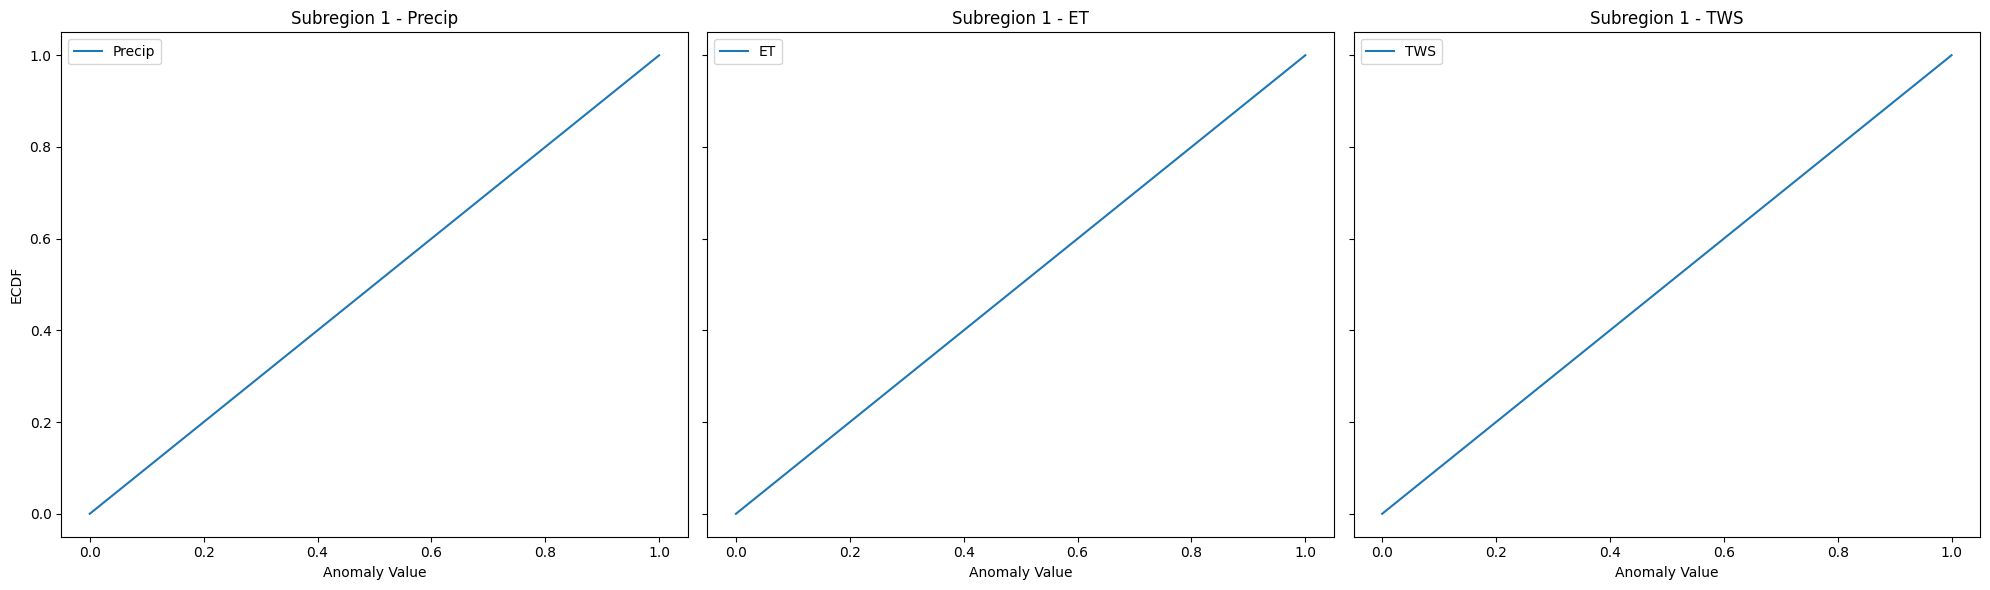

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    
for j, (var, label) in enumerate([('precip_ecdf', 'Precip'), ('et_ecdf', 'ET'), ('tws_ecdf', 'TWS')]):
        ax = axes[ j]
        ecdf_dict[var].plot(ax=ax, label=label)
        ax.set_title(f"Subregion 1 - {label}")
        ax.set_xlabel("Anomaly Value")
        if j == 0:
            ax.set_ylabel("ECDF")
        ax.legend()

plt.tight_layout()
plt.show()

In [197]:
copula_data = np.column_stack([
    ecdf_dict['precip_ecdf'].values,
    ecdf_dict['et_ecdf'].values,
    ecdf_dict['tws_ecdf'].values
])

Copula data shape: (1000, 3)


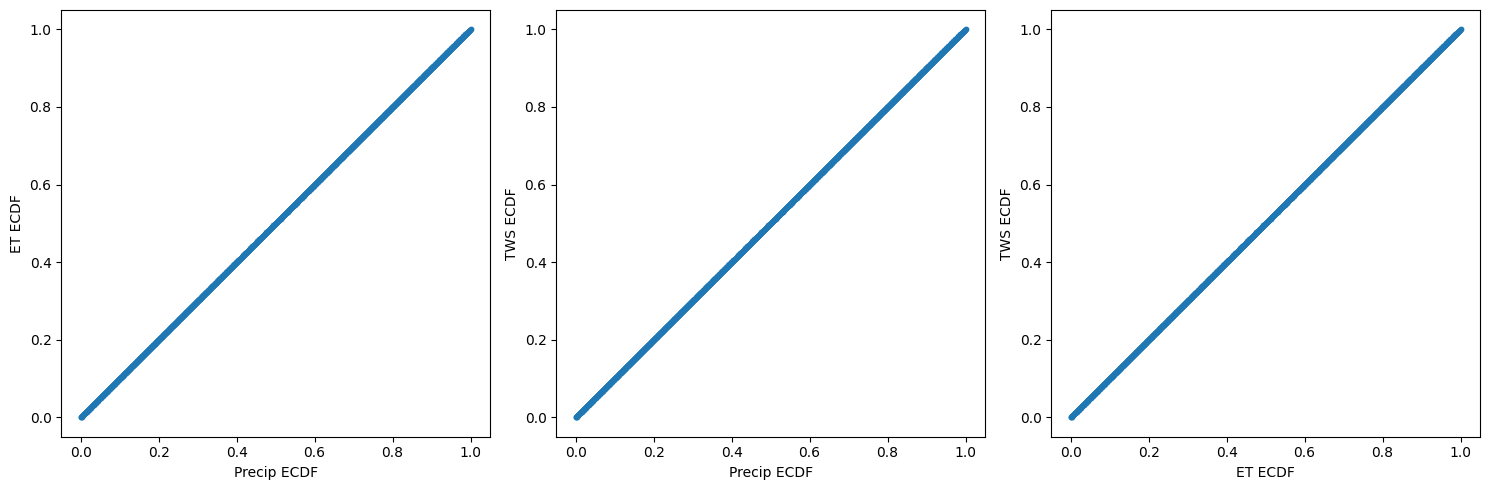

In [198]:
print(f"Copula data shape: {copula_data.shape}")  # Should be (200, 3)
# Visualize dependence
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(copula_data[:, 0], copula_data[:, 1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(copula_data[:, 0], copula_data[:, 2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(copula_data[:, 1], copula_data[:, 2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

In [199]:
subregion_id = 1
# Define Copulas
copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3),
        'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        copula.fit(copula_data)
        log_likelihood = copula.log_lik(copula_data)
        fit_results[name] = {'copula': copula, 'log_likelihood': log_likelihood}
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")

# Select best Copula (highest log-likelihood)
best_copula_name = max(results, key=lambda x: results[x]['Log-Likelihood'])
best_copula = results[best_copula_name]['copula']
print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")

Fitting Gaussian...
Failed to fit Gaussian Copula: singular matrix
Fitting Clayton...
Clayton Copula fitted for subregion 1, log-likelihood: nan
Fitting Frank...
Failed to fit Frank Copula: Could not find a root between intervals specified.
Fitting Gumbel...
Failed to fit Gumbel Copula: `alpha` used in calculating the gumbel polynomial must be (0, 1]
Fitting tCopula...
Failed to fit tCopula Copula: Singular matrix


ValueError: max() arg is an empty sequence

#### Random sampling

In [209]:
# vars = ['precip_anom', 'et_anom', 'tws_anom']
# stacked_data = {}
# for var in vars:
#     stacked = zone_1[var].compute().values.flatten()
#     stacked_data[var] = stacked

# # Combine into a matrix and remove rows with any NaNs
# data_matrix = np.column_stack([stacked_data[var] for var in vars])
# valid_mask = ~np.any(np.isnan(data_matrix), axis=1)
# data_matrix = data_matrix[valid_mask]

# # Update stacked_data with valid paired data
# for i, var in enumerate(vars):
#     stacked_data[var] = data_matrix[:, i]

# Step 2: Randomly sample paired indices
n_sample = 100000

# Step 3: Compute ECDF for each variable and transform the sampled data
ecdf_dict = {}
uniform_data_list = []
for var in ['precip_anom', 'et_anom', 'tws_anom']:
    stacked = zone_1[var].values.flatten()
    stacked = stacked[~np.isnan(stacked)]
    
    sample_indices = np.random.choice(len(stacked), size=n_sample, replace=False)

    # Compute ECDF on the full data
    ecdf_func = ECDF(stacked)
    
    # Sample the same indices for all variables to preserve dependence
    anom_points = stacked[sample_indices]
    ecdf_values = ecdf_func(anom_points)
    
    # Store in ecdf_dict as an xarray.DataArray
    ecdf_dict[f'{var.split("_")[0]}_ecdf'] = xr.DataArray(
        ecdf_values,
        coords={'ecdf_points': anom_points},
        dims=['ecdf_points']
    )
    
    # Collect ECDF-transformed values for copula modeling
    uniform_data_list.append(ecdf_values)

# Combine ECDF-transformed values into a matrix for copula modeling
uniform_data = np.column_stack(uniform_data_list)


In [169]:
uniform_data

array([[0.5328665 , 0.62888373, 0.56130584],
       [0.36921014, 0.81645515, 0.57905482],
       [0.11596416, 0.72279934, 0.15670994],
       ...,
       [0.25566804, 0.07711373, 0.83181995],
       [0.64862241, 0.19369812, 0.77434538],
       [0.42167541, 0.86677095, 0.30337288]])

In [208]:
stacked[sample_indices]

array([ 1.18302301e-01,  1.63604733e-01, -9.44986603e-01, -1.06352183e+00,
       -3.97584426e-01,  9.01684110e-01, -2.42514122e-01, -8.80831167e-01,
       -4.25766304e-01,  4.05802564e-01, -1.57244338e+00, -4.57327515e-01,
        1.17064360e-01, -5.68814954e-01,  2.78711339e-01, -2.09077974e-01,
       -3.79632730e-01, -2.46942344e-01,  2.04526647e+00,  1.37882332e+00,
        1.10960707e+00, -1.66101115e-01, -6.69056197e-01, -1.99124132e+00,
        8.19670897e-01,  2.19198584e-01, -8.21677351e-01, -6.34990758e-01,
       -7.67277186e-01, -8.82687329e-01, -2.09340949e-01,  1.29975282e+00,
       -7.47790241e-01,  3.64585346e-01, -5.18357339e-01, -3.37376687e-01,
       -1.67854472e+00, -3.25721151e-01, -1.03668840e+00,  1.14930217e+00,
        7.92939868e-01, -4.03319906e-01, -1.03828036e+00, -5.68687535e-01,
        3.35581276e-01,  4.78620906e-01, -6.90804566e-02, -1.34596348e+00,
        3.45866650e-01,  1.23050993e+00,  1.18345378e+00, -1.60516859e+00,
        7.17029064e-01,  

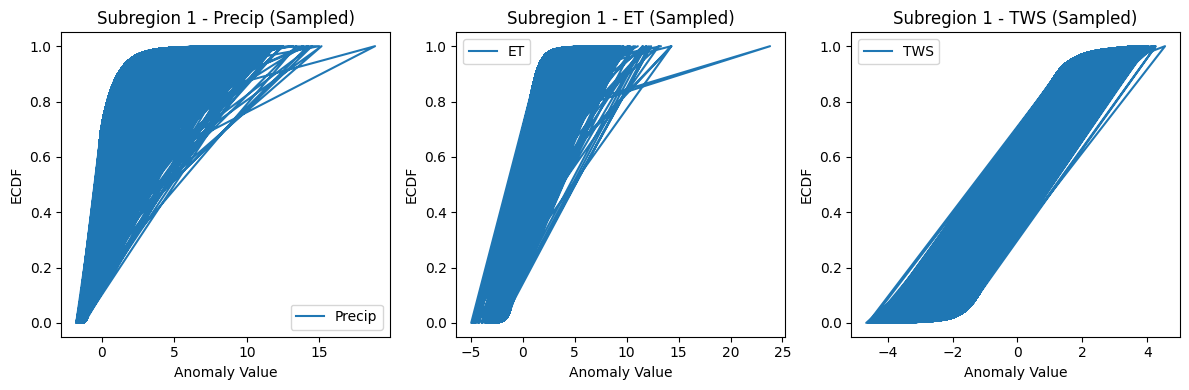

In [210]:
# Step 4: Plot the ECDFs of the sampled data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(ecdf_dict['precip_ecdf'].ecdf_points, ecdf_dict['precip_ecdf'], label="Precip")
plt.xlabel("Anomaly Value")
plt.ylabel("ECDF")
plt.title("Subregion 1 - Precip (Sampled)")
plt.legend()

plt.subplot(132)
plt.plot(ecdf_dict['et_ecdf'].ecdf_points, ecdf_dict['et_ecdf'], label="ET")
plt.xlabel("Anomaly Value")
plt.ylabel("ECDF")
plt.title("Subregion 1 - ET (Sampled)")
plt.legend()

plt.subplot(133)
plt.plot(ecdf_dict['tws_ecdf'].ecdf_points, ecdf_dict['tws_ecdf'], label="TWS")
plt.xlabel("Anomaly Value")
plt.ylabel("ECDF")
plt.title("Subregion 1 - TWS (Sampled)")
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
corr = np.corrcoef(uniform_data.T)
print("Correlation matrix:\n", corr)

Correlation matrix:
 [[1.         0.30102639 0.13131487]
 [0.30102639 1.         0.33832898]
 [0.13131487 0.33832898 1.        ]]


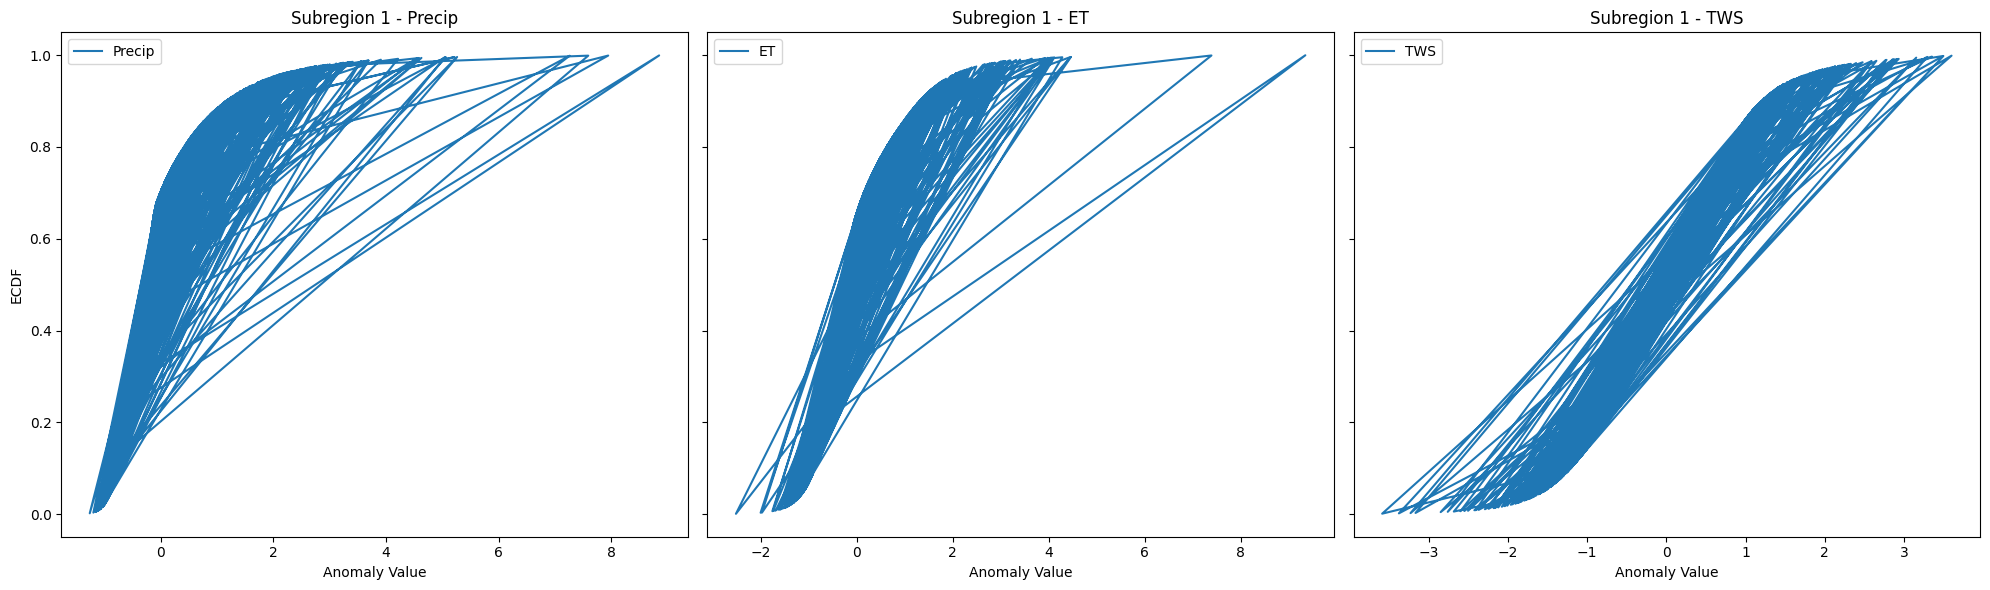

In [106]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    
for j, (var, label) in enumerate([('precip_ecdf', 'Precip'), ('et_ecdf', 'ET'), ('tws_ecdf', 'TWS')]):
        ax = axes[ j]
        ecdf_dict[var].plot(ax=ax, label=label)
        ax.set_title(f"Subregion 1 - {label}")
        ax.set_xlabel("Anomaly Value")
        if j == 0:
            ax.set_ylabel("ECDF")
        ax.legend()

plt.tight_layout()
plt.show()

In [27]:
# Save sampled ECDF dataset
ecdf_output_file = os.path.join(output_dir, 'cdfs/zone1_ecdf_200.nc')
xr.Dataset(ecdf_dict).to_netcdf(ecdf_output_file)
print(f"Saved ECDFs to {ecdf_output_file}")

Saved ECDFs to ../../datasets/results/cdfs/zone1_ecdf_200.nc


In [49]:
# Load ECDF dataset
ecdf_file = os.path.join(output_dir, 'cdfs/zone1_ecdf_200.nc')
all_ecdf_ds = xr.open_dataset(ecdf_file)

# Verify loaded data
print("Loaded ECDF dataset:")
print(all_ecdf_ds)


# Prepare data for Copula fitting (example: subregion 1)
precip_ecdf = all_ecdf_ds['precip_ecdf'].values
et_ecdf = all_ecdf_ds['et_ecdf'].values
tws_ecdf = all_ecdf_ds['tws_ecdf'].values

# Check for NaNs
if np.any(np.isnan(precip_ecdf)) or np.any(np.isnan(et_ecdf)) or np.any(np.isnan(tws_ecdf)):
    print(f"Warning: NaNs detected in zone 1 ECDFs, handling required")

Loaded ECDF dataset:
<xarray.Dataset>
Dimensions:      (ecdf_points: 600)
Coordinates:
  * ecdf_points  (ecdf_points) float64 -6.925 -6.765 -6.605 ... 25.29 25.43
Data variables:
    precip_ecdf  (ecdf_points) float64 ...
    et_ecdf      (ecdf_points) float64 ...
    tws_ecdf     (ecdf_points) float64 ...


In [112]:
uniform_data.shape

(1000, 3)

In [71]:
# Function to handle NaNs in ECDFs
def prepare_ecdf_for_copula(ecdf_data):
    if np.all(np.isnan(ecdf_data)):
        print(f"Subregion Zone All NaN, skipping Copula fitting")
        return None
    # Replace NaNs with a placeholder (e.g., 0.5) or interpolate if partial NaNs
    cleaned_data = np.where(np.isnan(ecdf_data), 0.5, ecdf_data)
    return cleaned_data

# Clean ECDFs for subregion 2
precip_ecdf_clean = prepare_ecdf_for_copula(precip_ecdf)
et_ecdf_clean = prepare_ecdf_for_copula(et_ecdf)
tws_ecdf_clean = prepare_ecdf_for_copula(tws_ecdf)

# Validate range
if precip_ecdf_clean is not None:
    print(f"Subregion Zone ECDF ranges:")
    print(f"Precip: {precip_ecdf_clean.min():.2f} to {precip_ecdf_clean.max():.2f}")
    print(f"ET: {et_ecdf_clean.min():.2f} to {et_ecdf_clean.max():.2f}")
    print(f"TWS: {tws_ecdf_clean.min():.2f} to {tws_ecdf_clean.max():.2f}")

Subregion Zone ECDF ranges:
Precip: 0.00 to 1.00
ET: 0.00 to 1.00
TWS: 0.00 to 1.00


In [214]:
copula_data = np.column_stack([
    ecdf_dict['precip_ecdf'].values,
    ecdf_dict['et_ecdf'].values,
    ecdf_dict['tws_ecdf'].values
])
print(f"Copula data shape: {copula_data.shape}")  # Should be (200, 3)

Copula data shape: (100000, 3)


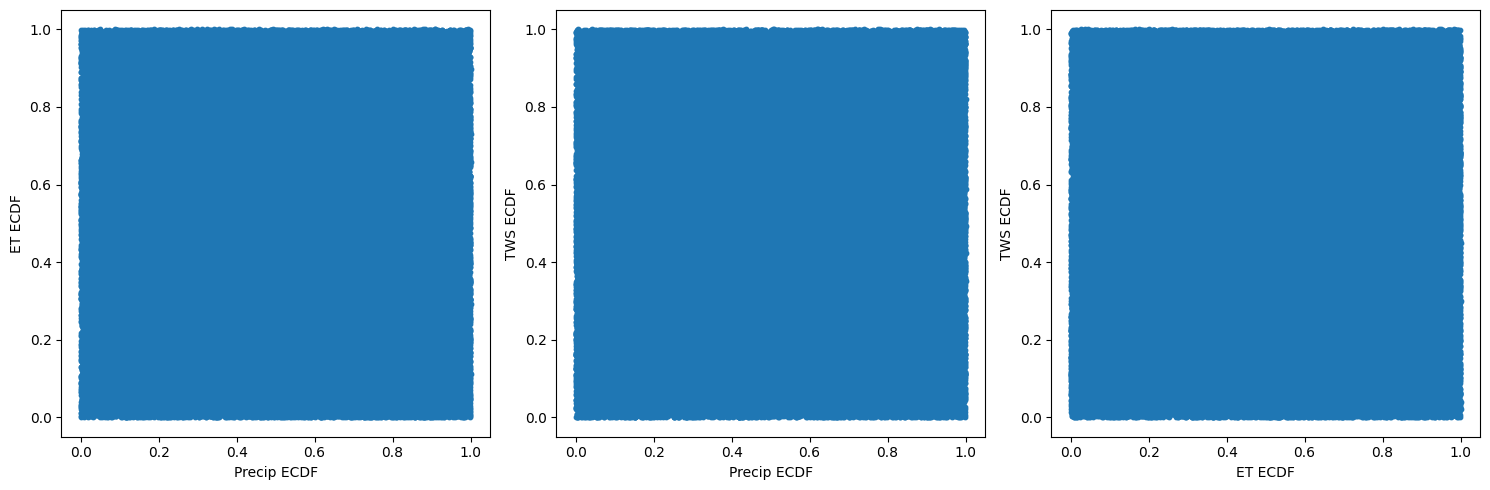

In [215]:
# Visualize dependence
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(copula_data[:, 0], copula_data[:, 1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(copula_data[:, 0], copula_data[:, 2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(copula_data[:, 1], copula_data[:, 2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

In [74]:
precip_ecdf_clean = precip_ecdf[~np.isnan(precip_ecdf)]
et_ecdf_clean = et_ecdf[~np.isnan(et_ecdf)]
tws_ecdf_clean = tws_ecdf[~np.isnan(tws_ecdf)]

Fitted Copula Correlation Matrix:
[0.34871991 0.14730538 0.35068493]


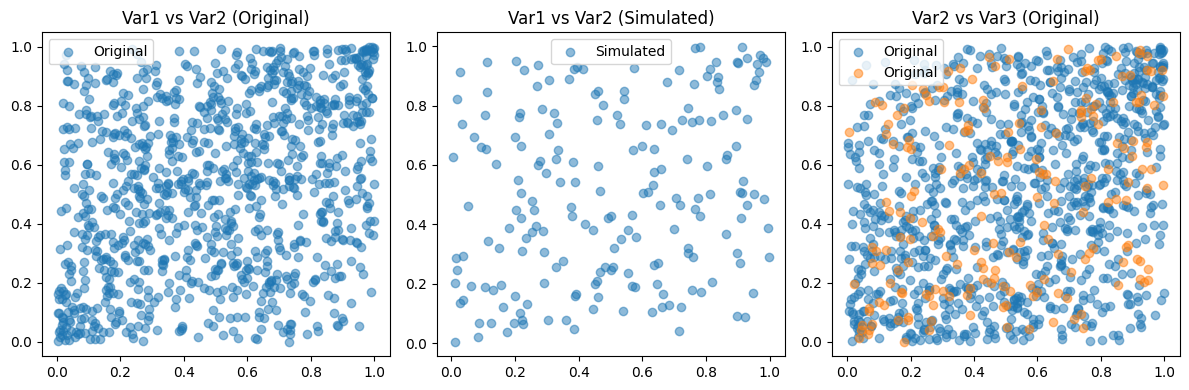


First 5 rows of Original Data:
[[-0.18467023 -0.77854752 -0.14508745]
 [-1.39605928 -1.18139445 -0.95345218]
 [-1.06899651 -0.95936188 -1.72210992]
 [-0.83319608 -0.27255166 -0.14337116]
 [-1.79730307  0.43843361  0.85160435]]

First 5 rows of ECDF-Transformed Data:
[[0.50424775 0.35853334 0.58763529]
 [0.99870284 0.99597231 0.73485134]
 [0.27068215 0.00345203 0.66064164]
 [0.39459076 0.62518837 0.52375847]
 [0.95849548 0.6134634  0.79773708]]


In [116]:
# import numpy as np
# from statsmodels.distributions.empirical_distribution import ECDF
# from copulae import GaussianCopula
# import matplotlib.pyplot as plt

# # Set random seed for reproducibility
# np.random.seed(42)

# # Define a correlation matrix (3x3) for 3 variables with some dependence
# corr_matrix = np.array([
#     [1.0, 0.5, 0.3],
#     [0.5, 1.0, 0.4],
#     [0.3, 0.4, 1.0]
# ])

# # Generate 1000 samples from a multivariate normal distribution
# n_sample = 1000
# sample_indices = np.random.choice(n_large, size=n_sample, replace=False)
# sample_data = large_data[sample_indices]

# # Split into 3 variables
# var1 = data[:, 0] * 5 + 5  # Simulate Precip (shifted to be positive, right-skewed)
# var2 = data[:, 1] * 5 + 5  # Simulate ET (similar to Precip)
# var3 = data[:, 2] * 2      # Simulate TWS (more symmetric)

# # Compute ECDF for each variable
# ecdf1 = ECDF(var1)
# ed1 = np.linspace(np.min(var1), np.max(var1), 200)
# ecdf2 = ECDF(var2)
# ed2 = np.linspace(np.min(var2), np.max(var2), 200)
# ecdf3 = ECDF(var3)
# ed3 = np.linspace(np.min(var3), np.max(var3), 200)

# # Transform the original data to uniform marginals using ECDF
# u1 = ecdf1(ed1)
# u2 = ecdf2(ed2)
# u3 = ecdf3(ed3)

# # Combine into a matrix of uniform variables
# uniform_data = np.column_stack((u1, u2, u3))

# Initialize and fit a Gaussian copula
copula = GaussianCopula(dim=3)  # 3 dimensions for 3 variables
copula.fit(uniform_data)

# Print the fitted correlation matrix of the copula
print("Fitted Copula Correlation Matrix:")
print(copula.params)

# Generate new samples from the fitted copula
simulated_uniform = copula.random(200)

# Visualize: Scatter plots to compare original vs simulated data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(uniform_data[:, 0], uniform_data[:, 1], alpha=0.5, label="Original")
plt.title("Var1 vs Var2 (Original)")
plt.legend()

plt.subplot(132)
plt.scatter(simulated_uniform[:, 0], simulated_uniform[:, 1], alpha=0.5, label="Simulated")
plt.title("Var1 vs Var2 (Simulated)")
plt.legend()

plt.subplot(133)
plt.scatter(uniform_data[:, 1], uniform_data[:, 2], alpha=0.5, label="Original")
plt.title("Var2 vs Var3 (Original)")
plt.legend()

plt.subplot(133)
plt.scatter(simulated_uniform[:, 1], simulated_uniform[:, 2], alpha=0.5, label="Original")
plt.title("Var2 vs Var3 (Original)")
plt.legend()

plt.tight_layout()
plt.show()

# Optional: Print first 5 rows of original and transformed data for inspection
print("\nFirst 5 rows of Original Data:")
print(data[:5])
print("\nFirst 5 rows of ECDF-Transformed Data:")
print(uniform_data[:5])

#### Fit Different Copulas

In [156]:
# Combine ECDFs into a matrix for Copula fitting (200 points, 3 variables)
if all(x is not None for x in [precip_ecdf_clean, et_ecdf_clean, tws_ecdf_clean]):
    copula_data = np.vstack([precip_ecdf_clean, et_ecdf_clean, tws_ecdf_clean]).T  # Shape: (200, 3)
    copula_data.shape    
    
    # Fit different Copulas
    copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3)
    }
    
    fit_results = {}
    for name, copula in copulas.items():
        try:
            copula.fit(copula_data)
            # Log-likelihood as a goodness-of-fit measure
            log_likelihood = copula.log_lik(copula_data)
            fit_results[name] = {'copula': copula, 'log_likelihood': log_likelihood}
            print(f"{name} Copula fitted for subregion Zone, log-likelihood: {log_likelihood:.2f}")
        except Exception as e:
            print(f"Failed to fit {name} Copula: {e}")
    
    # Select best Copula (highest log-likelihood)
    best_copula_name = max(fit_results, key=lambda k: fit_results[k]['log_likelihood'])
    best_copula = fit_results[best_copula_name]['copula']
    print(f"Best Copula for subregion Zone: {best_copula_name}")
else:
    print(f"Skipping Copula fitting for this zone due to invalid ECDFs")

NameError: name 'precip_ecdf_clean' is not defined

In [162]:
# Copula fitting for Zone 1
subregion_id = 1

# Extract ECDF values
precip_ecdf = ecdf_dict['precip_ecdf'].values
et_ecdf = ecdf_dict['et_ecdf'].values
tws_ecdf = ecdf_dict['tws_ecdf'].values

# Verify lengths
print(f"Subregion {subregion_id} ECDF lengths: precip={len(precip_ecdf)}, et={len(et_ecdf)}, tws={len(tws_ecdf)}")

# Combine into (200, 3) array
copula_data = np.vstack([precip_ecdf, et_ecdf, tws_ecdf]).T
print(f"Copula data shape: {copula_data.shape}")

Subregion 1 ECDF lengths: precip=200, et=200, tws=200
Copula data shape: (200, 3)


In [216]:
subregion_id = 1
# Define Copulas
copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3),
        'tCopula': StudentCopula(dim=3)
}

# Fit Copulas
results = {}
for name, copula in copulas.items():
    try:
        print(f'Fitting {name}...')
        copula.fit(copula_data)
        log_likelihood = copula.log_lik(copula_data)
        fit_results[name] = {'copula': copula, 'log_likelihood': log_likelihood}
        print(f"{name} Copula fitted for subregion {subregion_id}, log-likelihood: {log_likelihood:.2f}")
    except Exception as e:
        print(f"Failed to fit {name} Copula: {e}")
    
    # Select best Copula (highest log-likelihood)
#     best_copula_name = max(fit_results, key=lambda k: fit_results[k]['log_likelihood'])
#     best_copula = fit_results[best_copula_name]['copula']
#     print(f"Best Copula for subregion Zone: {best_copula_name}")

#     print(f"Skipping Copula fitting for this zone due to invalid ECDFs")
#     #     log_lik = copula.log_lik(copula_data)
    #     if name in ['Clayton', 'Gumbel', 'Frank']:
    #             n_params = np.array(copula.params).size
    #     elif name == 'Gaussian':
    #         n_params = copula.params.size
    #         aic = -2 * log_lik + 2 * n_params
    #         bic = -2 * log_lik + np.log(copula_data.shape[0]) * n_params
    #         results[name] = {
    #             "Log-Likelihood": log_lik,
    #             "AIC": aic,
    #             "BIC": bic,
    #             "Parameters": copula.params,
    #             "copula": copula
    #         }
    #         print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    # except Exception as e:
    #         print(f"Error fitting {name} copula: {e}")
    #         results[name] = {
    #             "Log-Likelihood": -np.inf,
    #             "AIC": np.inf,
    #             "BIC": np.inf,
    #             "Parameters": None,
    #             "copula": None
    #         }
# Select best Copula (highest log-likelihood)
best_copula_name = max(results, key=lambda x: results[x]['Log-Likelihood'])
best_copula = results[best_copula_name]['copula']
print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")
#     return best_copula, results

# print(f"Best Copula for subregion Zone: {best_copula_name}")

Fitting Gaussian...
Gaussian Copula fitted for subregion 1, log-likelihood: 0.29
Fitting Clayton...
Failed to fit Clayton Copula: theta must be positive when dim > 2
Fitting Frank...
Failed to fit Frank Copula: theta must be positive when dim > 2
Fitting Gumbel...


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


Gumbel Copula fitted for subregion 1, log-likelihood: 0.00
Fitting tCopula...
tCopula Copula fitted for subregion 1, log-likelihood: -2.38


ValueError: max() arg is an empty sequence

Fitting Gaussian copula.
Failed to fit Gaussian Copula for subregion 1: index 3 is out of bounds for axis 0 with size 3
Fitting Student copula.
Failed to fit tCopula Copula for subregion 1: index 3 is out of bounds for axis 0 with size 3
No successful Copula fits for subregion 1


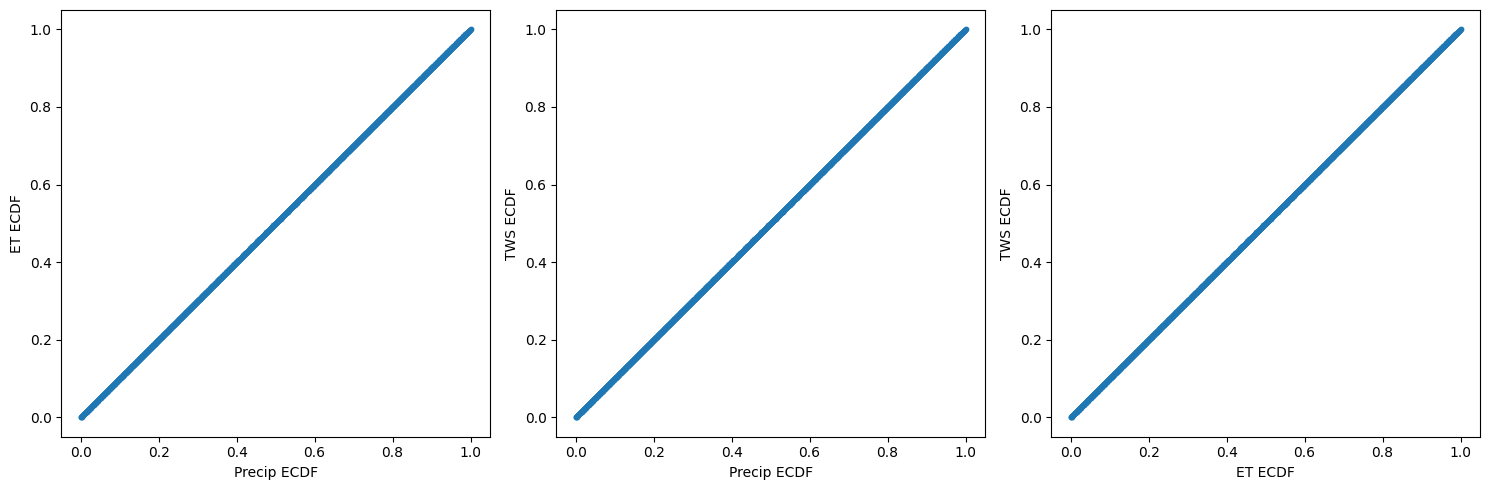

In [200]:
# Fit Copulas using pycopula
from pycopula import copula
copulas = {
    'Gaussian': copula.GaussianCopula(dim=3),
    # 'Clayton': copula.ClaytonCopula(dim=3),
    # 'Frank': copula.FrankCopula(dim=3),
    # 'Gumbel': copula.GumbelCopula(dim=3),
    'tCopula': copula.StudentCopula(dim=3, df=4)  # Degrees of freedom = 4
}

fit_results = {}
for name, cop in copulas.items():
    try:
        # Fit the Copula
        cop.fit(copula_data)
        # Compute log-likelihood (pycopula doesn't provide this directly, so we approximate)
        # Note: pycopula focuses on CDF/PDF, not log-likelihood for model selection
        # We'll use the Copula object directly for CDF computation
        print(f"{name} Copula fitted for subregion {subregion_id}")
        fit_results[name] = {'copula': cop}
    except Exception as e:
        print(f"Failed to fit {name} Copula for subregion {subregion_id}: {e}")

# Compute joint drought probability for each Copula
# Since pycopula doesn't provide log-likelihood, we'll compare based on CDF values or fit success
if fit_results:
    for name, result in fit_results.items():
        cop = result['copula']
        try:
            joint_prob = cop.cdf([0.2, 0.2, 0.2])
            print(f"Subregion {subregion_id} joint drought probability ({name}): {joint_prob:.4f}")
        except Exception as e:
            print(f"Failed to compute CDF for {name} Copula: {e}")
else:
    print(f"No successful Copula fits for subregion {subregion_id}")

# Replot scatter plots to confirm data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(copula_data[:, 0], copula_data[:, 1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(copula_data[:, 0], copula_data[:, 2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(copula_data[:, 1], copula_data[:, 2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

In [202]:
# Select best Copula
if fit_results:
    best_copula_name = max(fit_results, key=lambda k: fit_results[k]['log_likelihood'])
    best_copula = fit_results[best_copula_name]['copula']
    print(f"Best Copula for subregion {subregion_id}: {best_copula_name}")
    
    # Joint drought probability (P(U1 < 0.2, U2 < 0.2, U3 < 0.2))
    joint_prob = best_copula.cdf([0.2, 0.2, 0.2])
    print(f"Subregion {subregion_id} joint drought probability: {joint_prob:.4f}")
else:
    print(f"No successful Copula fits for subregion {subregion_id}")

No successful Copula fits for subregion 1


In [205]:
ecdf_dict = {'functions': {}}  # Store ECDF functions separately
samples_dict = {}             # Store uniform samples (for copula)

for var in ['precip_anom', 'et_anom', 'tws_anom']:
    stacked = zone_1[var].compute().values.flatten()
    stacked = stacked[~np.isnan(stacked)]
    
    if len(stacked) == 0:
        print(f"Warning: No valid data for {var} in Zone")
        # Default values (if no data)
        samples_dict[f'{var}_uniform'] = np.full(200, np.nan)
    else:
        print(f"Subregion Zone - {var} valid points: {len(stacked)}")
        ecdf_func = ECDF(stacked)
        ecdf_dict['functions'][f'{var}_ecdf'] = ecdf_func  # Store the ECDF callable
        
        # Generate 200 uniform samples by applying ECDF to raw data
        if len(stacked) >= 200:
            # Case 1: Sample 200 points from existing data
            subset_idx = np.random.choice(len(stacked), 200, replace=False)
            samples = stacked[subset_idx]
        else:
            # Case 2: If fewer than 200 points, reuse data (with replacement)
            subset_idx = np.random.choice(len(stacked), 200, replace=True)
            samples = stacked[subset_idx]
        
        # Transform to uniform margins [0, 1]
        samples_dict[f'{var}_uniform'] = ecdf_func(samples)

# Convert to xarray Dataset for convenience
uniform_samples_ds = xr.Dataset(
    {k: xr.DataArray(v, dims=['sample']) for k, v in samples_dict.items()}
)
print("Uniform samples for copula:")
print(uniform_samples_ds)

Subregion Zone - precip_anom valid points: 96562548
Subregion Zone - et_anom valid points: 93279332
Subregion Zone - tws_anom valid points: 48801181
Uniform samples for copula:
<xarray.Dataset>
Dimensions:              (sample: 200)
Dimensions without coordinates: sample
Data variables:
    precip_anom_uniform  (sample) float64 0.1042 0.2876 0.01063 ... 0.137 0.6762
    et_anom_uniform      (sample) float64 0.4595 0.7938 ... 0.1124 0.03543
    tws_anom_uniform     (sample) float64 0.9625 0.02484 ... 0.6908 0.4306


In [206]:
uniform_samples_ds

<xarray.Dataset>
Dimensions:              (sample: 200)
Dimensions without coordinates: sample
Data variables:
    precip_anom_uniform  (sample) float64 0.1042 0.2876 0.01063 ... 0.137 0.6762
    et_anom_uniform      (sample) float64 0.4595 0.7938 ... 0.1124 0.03543
    tws_anom_uniform     (sample) float64 0.9625 0.02484 ... 0.6908 0.4306

In [ ]:
copula_data = np.column_stack([
    ecdf_dict['precip_ecdf'].values,
    ecdf_dict['et_ecdf'].values,
    ecdf_dict['tws_ecdf'].values
])

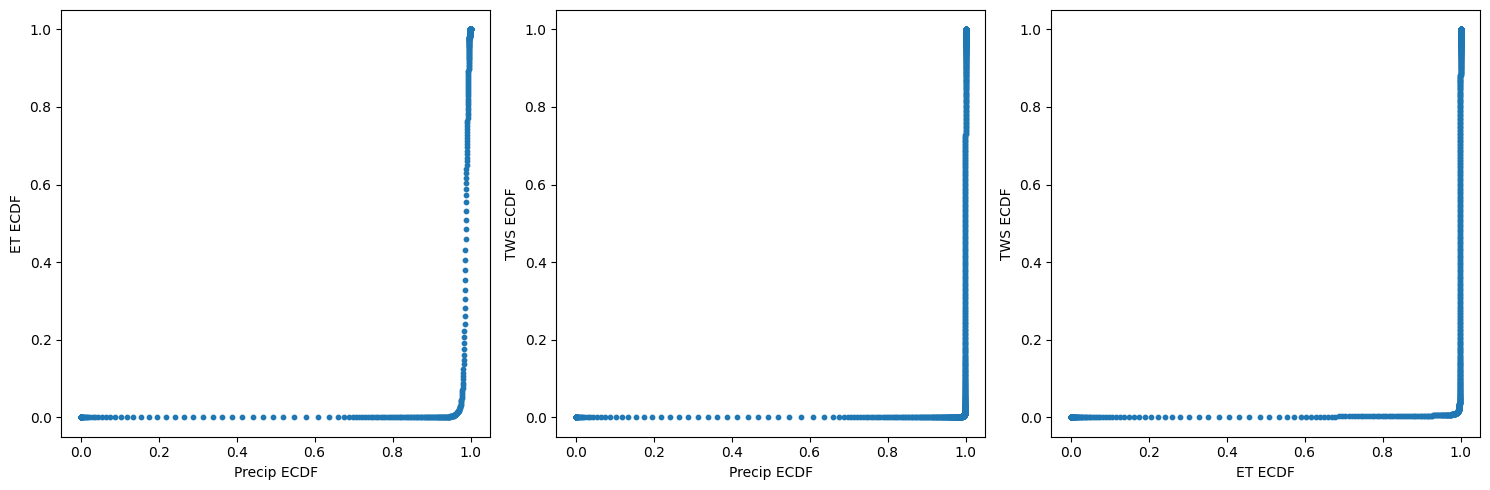

In [92]:
# Visualize dependence
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(copula_data[:, 0], copula_data[:, 1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(copula_data[:, 0], copula_data[:, 2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(copula_data[:, 1], copula_data[:, 2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

In [130]:
sample = best_copula.random(2000)

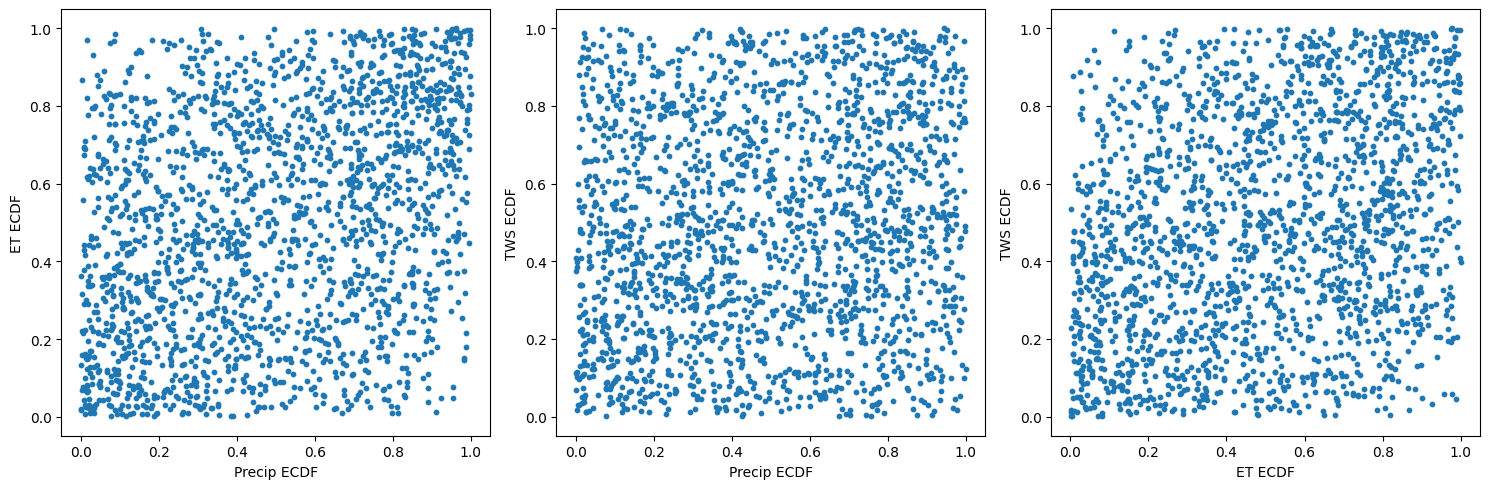

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(sample[:,0], sample[:,1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(sample[:,0], sample[:,2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(sample[:,1], sample[:,2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

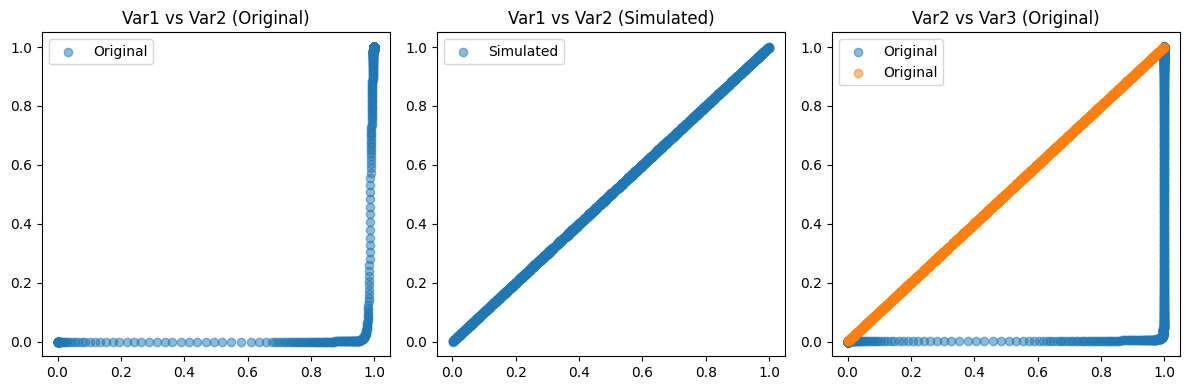

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.scatter(copula_data[:, 0], copula_data[:, 1], alpha=0.5, label="Original")
plt.title("Var1 vs Var2 (Original)")
plt.legend()

plt.subplot(132)
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, label="Simulated")
plt.title("Var1 vs Var2 (Simulated)")
plt.legend()

plt.subplot(133)
plt.scatter(copula_data[:, 1], copula_data[:, 2], alpha=0.5, label="Original")
plt.title("Var2 vs Var3 (Original)")
plt.legend()

plt.subplot(133)
plt.scatter(sample[:, 1], sample[:, 2], alpha=0.5, label="Original")
plt.title("Var2 vs Var3 (Original)")
plt.legend()

plt.tight_layout()
plt.show()

In [217]:
precip_yearly = zone_1.precipitaion.resample(time='Y').sum()

# Convert to a pandas DataFrame for easier handling
df = precip_yearly.to_dataframe().reset_index()
df = df.groupby(df['time'].dt.year)['precip_var'].sum().reset_index()
df.columns = ['Year', 'Precipitation']

# Step 3: Calculate historical mean, P10, and P10min
mean_precip = df['Precipitation'].mean()
sorted_precip = df['Precipitation'].sort_values(ascending=False)
P10 = sorted_precip.head(10).mean() if len(sorted_precip) >= 10 else sorted_precip.mean()
P10min = sorted_precip.tail(10).mean() if len(sorted_precip) >= 10 else sorted_precip.mean()

# Step 4: Define a function to calculate RAI
def calculate_rai(precip, mean_precip, P10, P10min):
    if precip >= mean_precip:
        return 10 * (precip - mean_precip) / (P10 - mean_precip)
    else:
        return 10 * (precip - mean_precip) / (mean_precip - P10min)

# Step 5: Apply the RAI formula
df['RAI'] = df['Precipitation'].apply(lambda x: calculate_rai(x, mean_precip, P10, P10min))

# Step 6: Display the results
print(df)


AttributeError: 'Dataset' object has no attribute 'precipitaion'

In [125]:
sample = copula.sample(200)

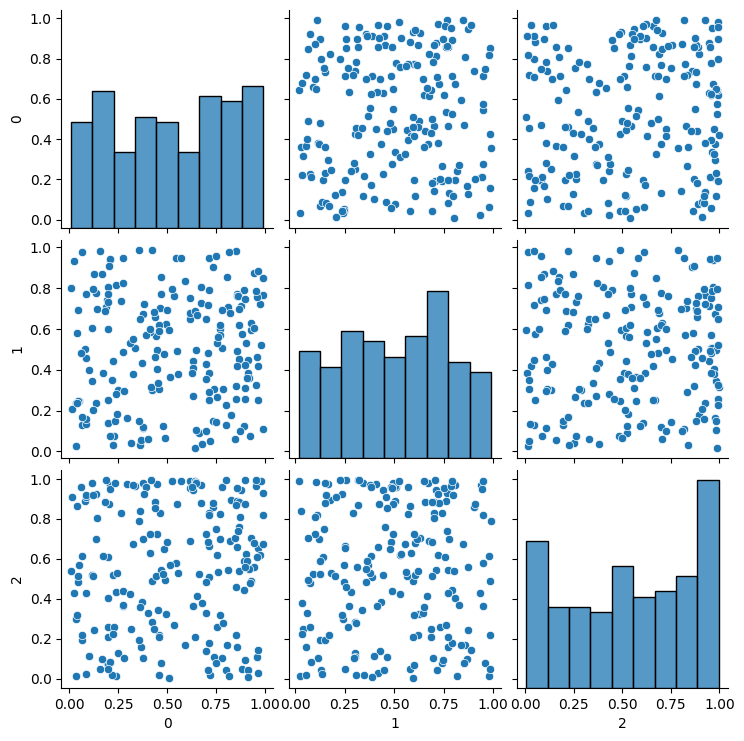

In [126]:
sns.pairplot(sample)

In [127]:
print("Copula data shape:", copula_data.shape)
print("Copula data min/max:", copula_data.min(), copula_data.max())
print("Copula data NaN count:", np.isnan(copula_data).sum())
print("First 5 rows:\n", copula_data[:5])

Copula data shape: (200, 3)
Copula data min/max: 0.003181647609381641 0.9972252720687231
Copula data NaN count: 0
First 5 rows:
 [[0.84449594 0.2859358  0.12655739]
 [0.63205437 0.90674659 0.34256314]
 [0.6491567  0.19031513 0.95382589]
 [0.82493796 0.7005337  0.32354246]
 [0.48216143 0.33404114 0.01990147]]


In [90]:
copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        # 'Gumbel': GumbelCopula(dim=3),
        # 'tCopula': StudentCopula(dim=3)
    }
    
results = {}
for name, copula in copulas.items():
    try:
        copula.fit(copula_data)
            log_lik = copula.log_lik(uniform_data)
            if name in ['Clayton', 'Gumbel', 'Frank']:
                n_params = np.array(copula.params).size
            elif name == 'Gaussian':
                n_params = copula.params.size
            aic = -2 * log_lik + 2 * n_params
            bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
            results[name] = {
                "Log-Likelihood": log_lik,
                "AIC": aic,
                "BIC": bic,
                "Parameters": copula.params,
                "copula": copula
            }
            print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
        except Exception as e:
            print(f"Error fitting {name} copula: {e}")
            results[name] = {
                "Log-Likelihood": -np.inf,
                "AIC": np.inf,
                "BIC": np.inf,
                "Parameters": None,
                "copula": None
            }
    
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")
    return best_copula, results


IndentationError: unexpected indent (1222350387.py, line 10)

####  Simulate and Validate Copula

NameError: name 'all_ecdf_ds' is not defined

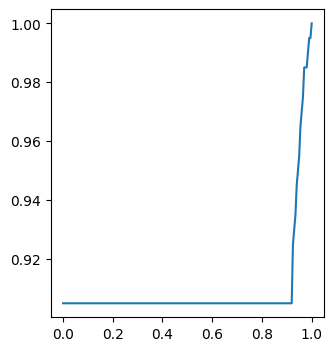

In [101]:
if 'best_copula' in locals():
    # Simulate 200 points from the best Copula
    simulated_data = best_copula.random(200)  # Shape: (200, 3)
    
    # Plot simulated vs. original ECDFs
    plt.figure(figsize=(12, 4))
    for i, (var, label) in enumerate([('precip', 'Precip'), ('et', 'ET'), ('tws', 'TWS')]):
        plt.subplot(1, 3, i+1)
        sim_ecdf = ECDF(simulated_data[:, i])
        sim_x = np.linspace(0, 1, 200)
        plt.plot(sim_x, sim_ecdf(sim_x), label='Simulated')
        plt.plot(all_ecdf_ds[f'{var}_ecdf'].ecdf_points, 
                 all_ecdf_ds[f'{var}_ecdf'], label='Original')
        plt.legend()
        plt.title(f"{label} ECDF Comparison")
    plt.tight_layout()
    plt.show()
    
    # # Save simulated data (optional)
    # sim_ds = xr.Dataset({
    #     'precip_sim': (['sim_points'], simulated_data[:, 0]),
    #     'et_sim': (['sim_points'], simulated_data[:, 1]),
    #     'tws_sim': (['sim_points'], simulated_data[:, 2])
    # }, coords={'sim_points': np.arange(200)})
    # sim_ds.to_netcdf(f'./subregion_datasets/subregion_{subregion_id}_simulated.nc')

Subregion Zone - precip_anom valid points: 96562548
Subregion Zone - et_anom valid points: 93279332
Subregion Zone - tws_anom valid points: 48801181


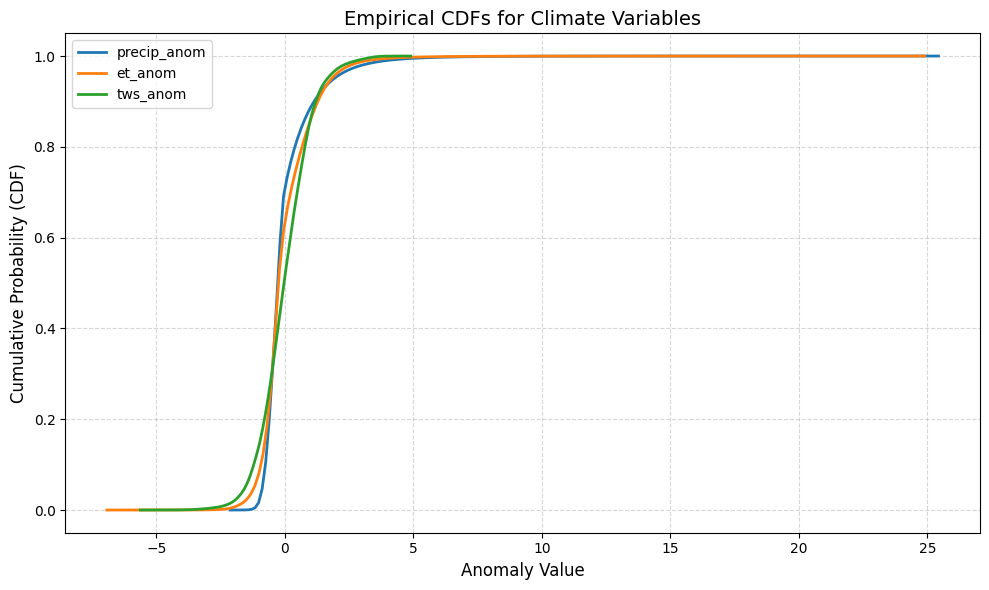

In [174]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.distributions.empirical_distribution import ECDF

# ----------------------------------------------------------------------------
# Step 1: Load your data and compute ECDFs + uniform samples
# ----------------------------------------------------------------------------
# Assuming zone_1 is your xarray Dataset with variables: precip_anom, et_anom, tws_anom

ecdf_dict = {'functions': {}}  # Store ECDF functions
samples_dict = {}              # Store uniform samples (for copula)

for var in ['precip_anom', 'et_anom', 'tws_anom']:
    stacked = zone_1[var].compute().values.flatten()
    stacked = stacked[~np.isnan(stacked)]  # Remove NaNs
    
    if len(stacked) == 0:
        print(f"Warning: No valid data for {var} in Zone")
        samples_dict[f'{var}_uniform'] = np.full(200, np.nan)
    else:
        print(f"Subregion Zone - {var} valid points: {len(stacked)}")
        ecdf_func = ECDF(stacked)
        ecdf_dict['functions'][f'{var}_ecdf'] = ecdf_func
        
        # Generate 200 uniform samples
        if len(stacked) >= 200:
            subset_idx = np.random.choice(len(stacked), 200, replace=False)
            samples = stacked[subset_idx]
        else:
            subset_idx = np.random.choice(len(stacked), 200, replace=True)
            samples = stacked[subset_idx]
        
        samples_dict[f'{var}_uniform'] = ecdf_func(samples)

# Convert to xarray Dataset
uniform_samples_ds = xr.Dataset(
    {k: xr.DataArray(v, dims=['sample']) for k, v in samples_dict.items()}
)

# ----------------------------------------------------------------------------
# Step 2: Generate points for plotting CDFs
# ----------------------------------------------------------------------------
plot_data = {}
for var in ['precip_anom', 'et_anom', 'tws_anom']:
    if f'{var}_ecdf' in ecdf_dict['functions']:
        ecdf_func = ecdf_dict['functions'][f'{var}_ecdf']
        stacked = zone_1[var].compute().values.flatten()
        stacked = stacked[~np.isnan(stacked)]
        x_points = np.linspace(np.min(stacked), np.max(stacked), 200)
        y_values = ecdf_func(x_points)
        plot_data[var] = (x_points, y_values)

# ----------------------------------------------------------------------------
# Step 3: Plot CDFs (Matplotlib)
# ----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
for var, (x, y) in plot_data.items():
    plt.plot(x, y, label=var, linewidth=2)

plt.xlabel('Anomaly Value', fontsize=12)
plt.ylabel('Cumulative Probability (CDF)', fontsize=12)
plt.title('Empirical CDFs for Climate Variables', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('cdfs_matplotlib.png', dpi=300)  # Save high-res version
plt.show()

# # ----------------------------------------------------------------------------
# # Step 4: Interactive Plot (Plotly)
# # ----------------------------------------------------------------------------
# # Prepare DataFrame for Plotly
# df_plotly = pd.DataFrame()
# for var, (x, y) in plot_data.items():
#     temp_df = pd.DataFrame({
#         'Anomaly': x,
#         'CDF': y,
#         'Variable': var
#     })
#     df_plotly = pd.concat([df_plotly, temp_df])

# # Create interactive plot
# fig = px.line(
#     df_plotly,
#     x='Anomaly',
#     y='CDF',
#     color='Variable',
#     title='Interactive Empirical CDFs',
#     labels={'Anomaly': 'Anomaly Value', 'CDF': 'Cumulative Probability'},
#     width=800,
#     height=500
# )
# fig.update_layout(
#     hovermode='x unified',
#     plot_bgcolor='white',
#     font=dict(size=12),
#     legend=dict(title=None, orientation='h', y=1.1)
# )
# fig.write_html('cdfs_interactive.html')  # Save as interactive HTML
# fig.show()

# # ----------------------------------------------------------------------------
# # (Optional) Step 5: Overlay Original Data Points
# # ----------------------------------------------------------------------------
# plt.figure(figsize=(10, 6))
# for var, (x, y) in plot_data.items():
#     # Plot CDF
#     plt.plot(x, y, label=f'{var} CDF', linewidth=2)
    
#     # Plot original data points (sorted)
#     stacked = zone_1[var].compute().values.flatten()
#     stacked = stacked[~np.isnan(stacked)]
#     sorted_data = np.sort(stacked)
#     plt.plot(sorted_data, np.linspace(0, 1, len(sorted_data)),
#              'o', markersize=3, alpha=0.2, label=f'{var} data')

# plt.xlabel('Anomaly Value', fontsize=12)
# plt.ylabel('Cumulative Probability', fontsize=12)
# plt.title('CDFs with Original Data Points', fontsize=14)
# plt.legend(fontsize=10, ncol=2)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig('cdfs_with_data_points.png', dpi=300)
# plt.show()

Subregion 1 - precip_anom valid points: 96562548
Subregion 1 - et_anom valid points: 93279332
Subregion 1 - tws_anom valid points: 48801181
Copula data shape: (200, 3)
Copula data min/max: 0.0 1.0
First 5 rows:
 [[0.         0.         0.        ]
 [0.0020202  0.0020202  0.0020202 ]
 [0.0040404  0.0040404  0.0040404 ]
 [0.00606061 0.00606061 0.00606061]
 [0.00808081 0.00808081 0.00808081]]


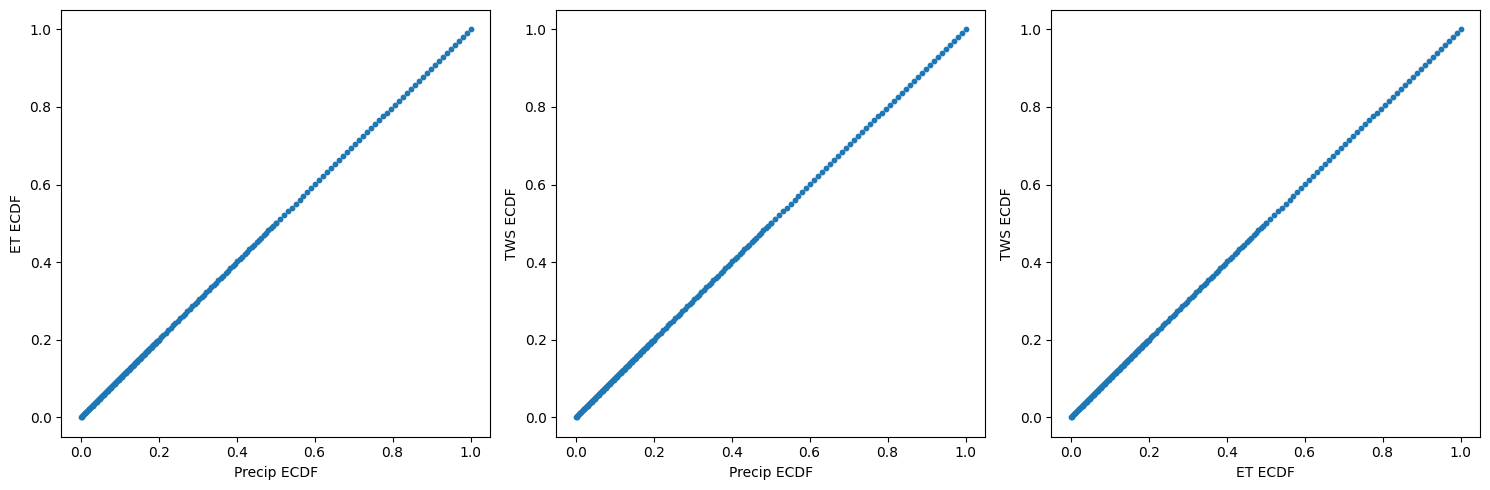

In [175]:
ecdf_dict = {}
for var in ['precip_anom', 'et_anom', 'tws_anom']:
    stacked = zone_1[var].compute().values.flatten()
    stacked = stacked[~np.isnan(stacked)]
    if len(stacked) == 0:
        print(f"Warning: No valid data for {var} in subregion {subregion_id}")
        ecdf_values = np.full(200, np.nan)
        anom_points = np.linspace(-1, 1, 200)
    else:
        print(f"Subregion {subregion_id} - {var} valid points: {len(stacked)}")
        ecdf_func = ECDF(stacked)
        # Stratified sampling
        ecdf_points = np.concatenate([
            np.linspace(0, 0.2, 100),  # Focus on drought
            np.linspace(0.2, 0.5, 50),
            np.linspace(0.5, 1.0, 50)
        ])
        anom_points = np.quantile(stacked, ecdf_points, method='inverted_cdf')
        ecdf_values = ecdf_points
    ecdf_dict[f'{var.split("_")[0]}_ecdf'] = xr.DataArray(
        ecdf_values,
        coords={'ecdf_points': anom_points},
        dims=['ecdf_points']
    )

# Proceed with Copula fitting (as before)
precip_ecdf = ecdf_dict['precip_ecdf'].values
et_ecdf = ecdf_dict['et_ecdf'].values
tws_ecdf = ecdf_dict['tws_ecdf'].values
copula_data = np.vstack([precip_ecdf, et_ecdf, tws_ecdf]).T
print("Copula data shape:", copula_data.shape)
print("Copula data min/max:", copula_data.min(), copula_data.max())
print("First 5 rows:\n", copula_data[:5])

# Replot scatter plots to see the difference
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(copula_data[:, 0], copula_data[:, 1], s=10)
axes[0].set_xlabel('Precip ECDF')
axes[0].set_ylabel('ET ECDF')
axes[1].scatter(copula_data[:, 0], copula_data[:, 2], s=10)
axes[1].set_xlabel('Precip ECDF')
axes[1].set_ylabel('TWS ECDF')
axes[2].scatter(copula_data[:, 1], copula_data[:, 2], s=10)
axes[2].set_xlabel('ET ECDF')
axes[2].set_ylabel('TWS ECDF')
plt.tight_layout()
plt.show()

### ECDF with `Chunks`

In [ ]:
# Compute 200-point ECDFs
ecdf_ds_list = []
for subregion_id in landform_classes[:2]:
    if np.isnan(subregion_id):
        continue
    print(f"Computing ECDF for subregion {subregion_id}...")
    subregion_data = all_subregions_ds.sel(subregion=int(subregion_id))
    
    ecdf_dict = {}
    for var in ['precip_anom', 'et_anom', 'tws_anom']:
        stacked = subregion_data[var].values.flatten()
        stacked = stacked[~np.isnan(stacked)]
        
        if len(stacked) == 0:
            print(f"Warning: No valid data for {var} in subregion {subregion_id}")
            ecdf_values = np.full(200, np.nan)
            anom_points = np.linspace(-1, 1, 200)
        else:
            ecdf_func = ECDF(stacked)
            anom_min, anom_max = np.nanmin(stacked), np.nanmax(stacked)
            anom_points = np.linspace(anom_min, anom_max, 200)
            ecdf_values = ecdf_func(anom_points)
        
        ecdf_dict[f'{var.split("_")[0]}_ecdf'] = xr.DataArray(
            ecdf_values,
            coords={'ecdf_points': anom_points},
            dims=['ecdf_points']
        )
    
    subregion_ecdf_ds = xr.Dataset(ecdf_dict).assign_coords(subregion=int(subregion_id)).expand_dims('subregion')
    ecdf_ds_list.append(subregion_ecdf_ds)

# Combine ECDFs
all_ecdf_ds = xr.concat(ecdf_ds_list, dim='subregion')
print("ECDF dataset:")
print(all_ecdf_ds)


Computing ECDF for subregion 1.0...
Computing ECDF for subregion 2.0...


/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [1]:
ecdf_ds_list

NameError: name 'ecdf_ds_list' is not defined

In [ ]:
# Plot ECDFs in one row (2 subregions × 3 variables = 6 subplots)
fig, axes = plt.subplots(1, 6, figsize=(30, 5), sharey=True)
for i, subregion_id in enumerate(landform_classes[:2]):
    if np.isnan(subregion_id):
        continue
    subregion_data = all_ecdf_ds.sel(subregion=int(subregion_id))
    
    for j, (var, label) in enumerate([('precip_ecdf', 'Precip'), ('et_ecdf', 'ET'), ('tws_ecdf', 'TWS')]):
        ax = axes[i * 3 + j]
        subregion_data[var].plot(ax=ax, label=label)
        ax.set_title(f"Subregion {int(subregion_id)} - {label}")
        ax.set_xlabel("Anomaly Value")
        if j == 0:
            ax.set_ylabel("ECDF")
        ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save ECDF dataset
ecdf_output_file = os.path.join(output_dir, 'cdfs/all_subregions_ecdf_200.nc')
all_ecdf_ds.to_netcdf(ecdf_output_file)
print(f"Saved ECDFs to {ecdf_output_file}")

In [66]:
ecdf_ds_list

[<xarray.Dataset>
 Dimensions:      (ecdf_points: 600, subregion: 1)
 Coordinates:
   * ecdf_points  (ecdf_points) float64 -6.925 -6.765 -6.605 ... 25.29 25.43
   * subregion    (subregion) int64 1
 Data variables:
     precip_ecdf  (subregion, ecdf_points) float64 nan nan nan ... 1.0 1.0 1.0
     et_ecdf      (subregion, ecdf_points) float64 1.072e-08 2.144e-08 ... nan
     tws_ecdf     (subregion, ecdf_points) float64 nan nan nan ... nan nan nan]

#### Load the saved CDFs

In [ ]:
# Load ECDF dataset
ecdf_file = os.path.join(output_dir, 'cdfs/all_subregions_ecdf_200.nc'
all_ecdf_ds = xr.open_dataset(ecdf_file)

# Verify loaded data
print("Loaded ECDF dataset:")
print(all_ecdf_ds)

# Extract subregion IDs
subregion_ids = all_ecdf_ds['subregion'].values

# Prepare data for Copula fitting (example: subregion 1)
subregion_id = 1
precip_ecdf = all_ecdf_ds['precip_ecdf'].sel(subregion=subregion_id).values
et_ecdf = all_ecdf_ds['et_ecdf'].sel(subregion=subregion_id).values
tws_ecdf = all_ecdf_ds['tws_ecdf'].sel(subregion=subregion_id).values

# Check for NaNs
if np.any(np.isnan(precip_ecdf)) or np.any(np.isnan(et_ecdf)) or np.any(np.isnan(tws_ecdf)):
    print(f"Warning: NaNs detected in subregion {subregion_id} ECDFs, handling required")

#### zone_3

#### Fit Marginal Distributions Using `statsmodels` ECDF

In [163]:
# Function to compute ECDF with a common mask
def compute_ecdf_statsmodels_consistent(ds):
    '''Parameters:
        ds (xarray.Dataset): Input dataset containing 'tws_anom', 'precip_anom', and 'et_anom'.

    Returns:
        tws_cdf (xarray.DataArray): ECDF values for TWS anomaly.
        precip_cdf (xarray.DataArray): ECDF values for precipitation anomaly.
        et_cdf (xarray.DataArray): ECDF values for ET anomaly.
    '''
    # Convert the selected variables to a single DataArray with 'variable' dimension
    data_vars = ds[['tws_anom', 'precip_anom', 'et_anom']].to_array(dim='variable')
    
    # Stack spatial and temporal dimensions
    stacked_data = data_vars.stack(all_points=['time', 'y', 'x'])
    
    # Create a common mask where all variables are non-NaN
    common_mask = stacked_data.notnull().all(dim='variable')
    valid_data = stacked_data.where(common_mask, drop=True)
    # print(valid_data)
    
    # Compute ECDF for each variable
    ecdf_dict = {}
    for var_name in ['tws_anom', 'precip_anom', 'et_anom']:
        flat_data = valid_data.sel(variable=var_name).values
        ecdf = ECDF(flat_data)
        cdf_values = ecdf(flat_data)
        ecdf_dict[var_name] = xr.DataArray(
            cdf_values,
            coords={'all_points': valid_data.sel(variable=var_name).coords['all_points']},
            dims=['all_points']
        ).unstack()
    
    return ecdf_dict['tws_anom'], ecdf_dict['precip_anom'], ecdf_dict['et_anom']



In [164]:
# Zone 1
zone_1['tws_cdf'] = compute_ecdf_statsmodels(zone_1, 'tws_anom')
zone_1['precip_cdf'] = compute_ecdf_statsmodels(zone_1, 'precip_anom')
zone_1['et_cdf'] = compute_ecdf_statsmodels(zone_1, 'et_anom')

NameError: name 'xr' is not defined

In [57]:
zone_1_cdf = zone_1['et_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')


In [59]:
# Compute ECDF for ET
ecdf_et = ECDF(zone_1_cdf)

# # Compute ECDF for Precipitation
# ecdf_precip = ECDF(precip_clean)

# # Compute ECDF for TWS
# ecdf_twsa = ECDF(tws_clean)

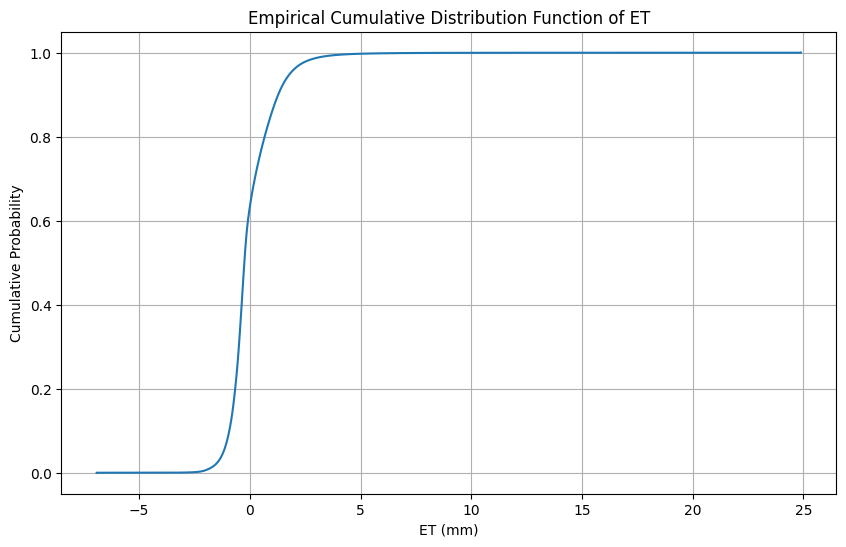

In [60]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

In [79]:
x = np.linspace(min, max, step)

93279333

In [ ]:
# Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['tws_cdf'] = compute_ecdf_statsmodels(ds, 'tws_anom')
    ds['precip_cdf'] = compute_ecdf_statsmodels(ds, 'precip_anom')
    ds['et_cdf'] = compute_ecdf_statsmodels(ds, 'et_anom')
    
    # Update the dataset
    subregion_datasets[subregion_id] = ds

# Example: Check CDFs for the first subregion
first_subregion_id = list(subregion_datasets.keys())[0]
print(subregion_datasets[first_subregion_id][['tws_cdf', 'precip_cdf', 'et_cdf']])

In [58]:
#  Apply to each subregion
for subregion_id, ds in subregion_datasets.items():
    tws_cdf, precip_cdf, et_cdf = compute_ecdf_statsmodels_consistent(ds)
    ds['tws_cdf'] = tws_cdf
    ds['precip_cdf'] = precip_cdf
    ds['et_cdf'] = et_cdf
    subregion_datasets[subregion_id] = ds
first_subregion_id = list(subregion_datasets.keys())[0]
print(subregion_datasets[first_subregion_id][['tws_cdf', 'precip_cdf', 'et_cdf']])

<xarray.Dataset>
Dimensions:      (time: 219, y: 671, x: 337)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
    band         int64 1
    spatial_ref  int64 0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws_cdf      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    precip_cdf   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et_cdf       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan


In [140]:
tws_len = subregion_datasets[1]['tws_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
precip_len = subregion_datasets[1]['precip_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
et_len = subregion_datasets[1]['et_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').size
print(f"Lengths: tws_cdf={tws_len}, precip_cdf={precip_len}, et_cdf={et_len}")
print(ds[['tws_cdf', 'precip_cdf', 'et_cdf']])
%time

Lengths: tws_cdf=1390176, precip_cdf=1390176, et_cdf=1390176
<xarray.Dataset>
Dimensions:      (time: 219, y: 360, x: 207)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
  * y            (y) float64 17.62 17.57 17.37 17.32 ... -9.775 -9.875 -9.925
  * x            (x) float64 24.23 24.28 24.33 24.38 ... 42.63 42.68 42.73 47.28
    lat          (y) float64 17.62 17.57 17.37 17.32 ... -9.775 -9.875 -9.925
    lon          (x) float64 24.23 24.28 24.33 24.38 ... 42.63 42.68 42.73 47.28
    band         int64 1
    spatial_ref  int64 0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws_cdf      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    precip_cdf   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et_cdf       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 18.8 µs


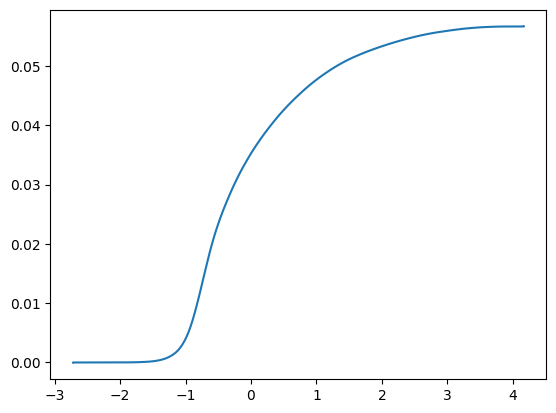

In [117]:
plt.step(jk.x, jk.y)

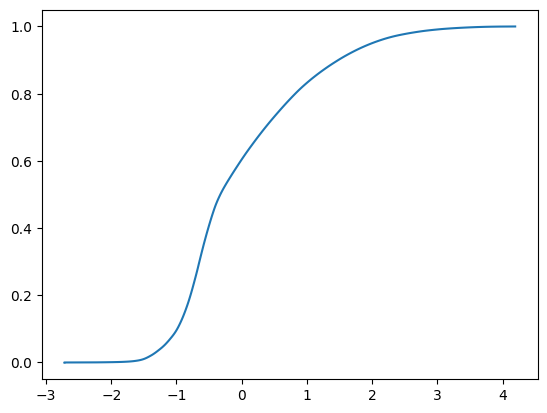

In [137]:
plt.step(jk.x, jk.y)

In [104]:
v = subregion_datasets[1]['et_cdf'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')

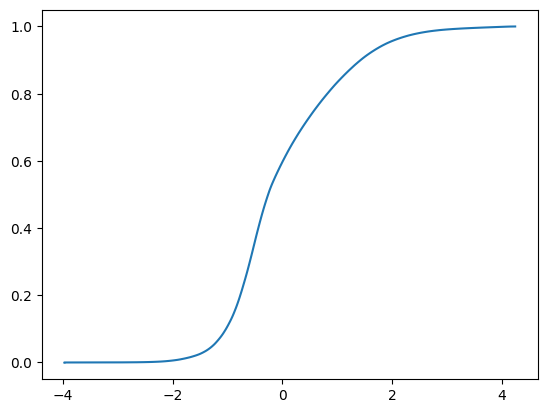

In [139]:
plt.step(gh.x, gh.y)

In [166]:
f = subregion_datasets[1]['et_cdf'].values

In [157]:
from copulae.core import pseudo_obs

pseudo_obs(flatten)

array([0.5460973 , 0.45717023, 0.44608472, ..., 0.98954527, 0.99077544,
       0.98919175])

In [163]:
for i, j in subregion_datasets.items():
    print('id - {}'.format(i), j)

id - 1.0 <xarray.Dataset>
Dimensions:        (time: 219, y: 671, x: 337)
Coordinates:
  * time           (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T1...
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
  * x              (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
    lat            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
    lon            (x) float64 30.33 30.38 30.48 30.53 ... 51.28 51.33 51.38
    band           int64 1
    spatial_ref    int64 0
    month          (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    tws            (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et             (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform       (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    tws_anom       (y, x, time) float64 nan nan na

In [130]:
flatten = subregion_datasets[1]['precip_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').values
len(flatten)

2806096

In [ ]:
flatten = subregion_datasets[1]['precip_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points').values
len(flatten)

#### Visualise the CDFs plots

In [153]:
# plains
tws_cdf_1 = subregion_datasets[1]['tws_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')
precip_cdf_1 = subregion_datasets[1]['precip_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')
et_cdf_1 = subregion_datasets[1]['et_anom'].stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')

In [164]:
# Plot precomputed ECDF
def plot_precomputed_ecdf(cdf_data, label, subregion_id, title):
    valid_data = cdf_data.values.flatten()
    valid_data = valid_data[~np.isnan(valid_data)]
    print(valid_data)
    print(len(valid_data))
    ecdf = ECDF(valid_data)
    data_cdf = ecdf.x
    cumulative_prob = ecdf.y
    plt.figure(figsize=(10, 6))
    plt.step(data_cdf, cumulative_prob, label=f'ECDF - {label}')
    plt.xlabel(f"{label} (Cumulative Probability)")
    plt.ylabel("Fraction of Data")
    plt.title(f"ECDF for {title} - Subregion {subregion_id}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [159]:
tws_cdf_1

<xarray.DataArray 'tws_anom' (all_points: 1410141)>
array([-0.08582233,  0.12050391,  0.0769759 , ...,  2.95525087,
        2.93172537,  2.93865419])
Coordinates:
    lat          (all_points) float64 20.92 20.82 20.82 ... -9.325 -9.725 -9.825
    lon          (all_points) float64 30.58 30.33 30.38 ... 38.98 38.98 38.88
    band         int64 1
    spatial_ref  int64 0
    month        (all_points) int64 1 1 1 1 1 1 1 1 ... 10 10 10 10 10 10 10 10
  * all_points   (all_points) object MultiIndex
  * time         (all_points) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-...
  * y            (all_points) float64 20.92 20.82 20.82 ... -9.325 -9.725 -9.825
  * x            (all_points) float64 30.58 30.33 30.38 ... 38.98 38.98 38.88

In [208]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

data = np.array([3, 1, 4, 1, 5, 9, 2, 6, 5])  # Sample data
ecdf = ECDF(data)  
cdf_values = ecdf(data)  

print(cdf_values)  # Output: CDF values for each data point


[0.44444444 0.22222222 0.55555556 0.22222222 0.77777778 1.
 0.33333333 0.88888889 0.77777778]


In [142]:
if subregion_id == 1.0:
        print(f"Plotting ECDFs for subregion {subregion_id}")
        plot_precomputed_ecdf(ds['tws_cdf'], 'TWS CDF', subregion_id, 'Terrestrial Water Storage')
        plot_precomputed_ecdf(ds['precip_cdf'], 'Precipitation CDF', subregion_id, 'Precipitation')
        plot_precomputed_ecdf(ds['et_cdf'], 'ET CDF', subregion_id, 'Evapotranspiration')
    

[-0.08582233 -0.66559931 -0.26566964 ...  3.37327491  3.36987257
  2.93865419]
1410141


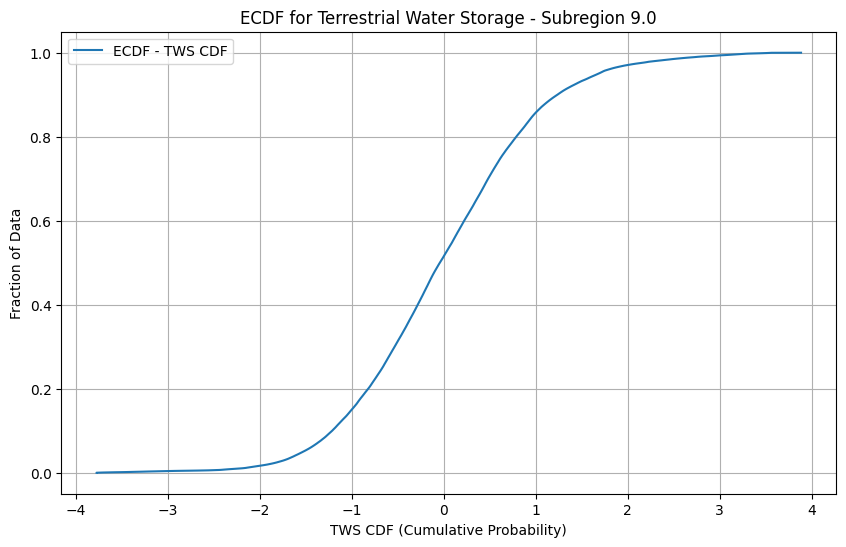

In [165]:
plot_precomputed_ecdf(subregion_datasets[1]['tws_anom'], 'TWS CDF', subregion_id, 'Terrestrial Water Storage')

[ 0.519711    0.34235389  0.77696656 ... -0.88322114 -0.29251149
 -0.51215974]
2638720


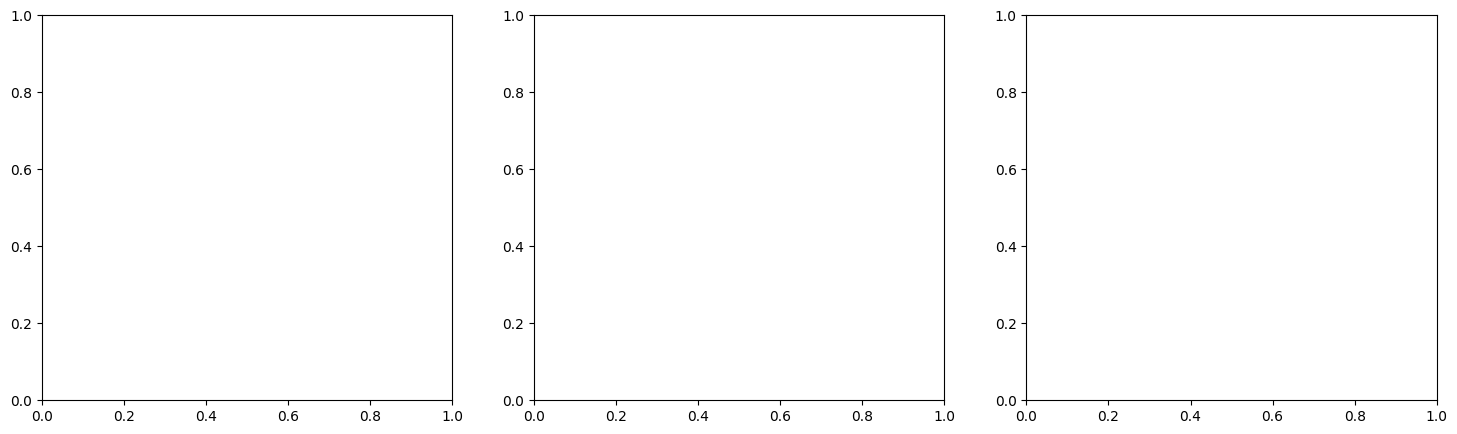

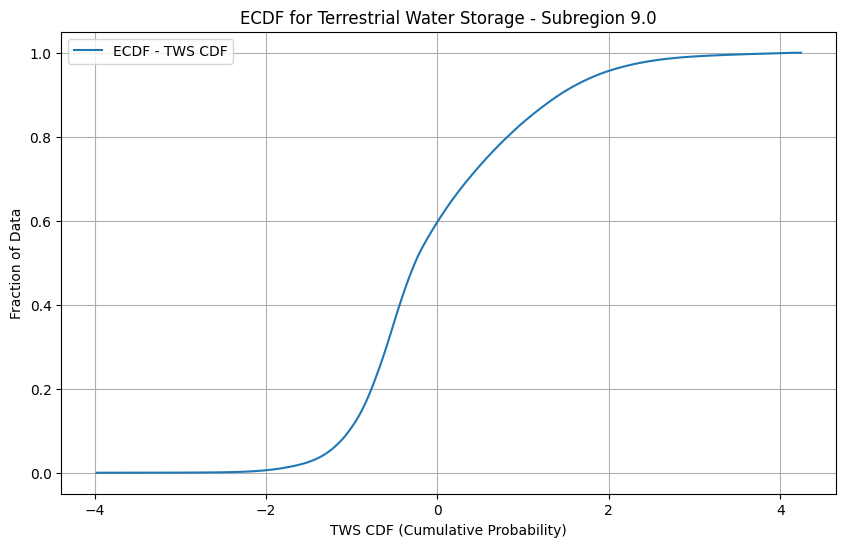

[-0.21548901 -0.41579636 -0.43788492 ...  3.09117865  3.14126359
  3.07756753]
2806096


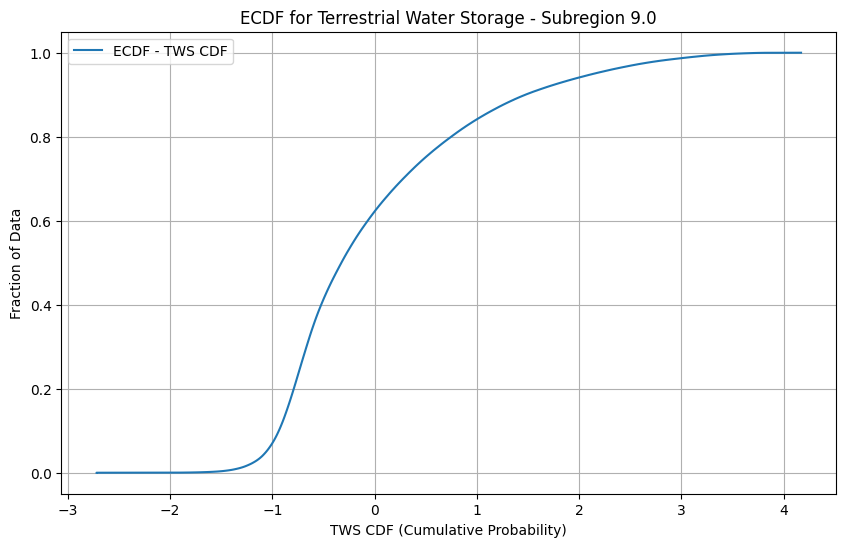

[-0.08582233  0.12050391  0.0769759  ...  2.95525087  2.93172537
  2.93865419]
1410141


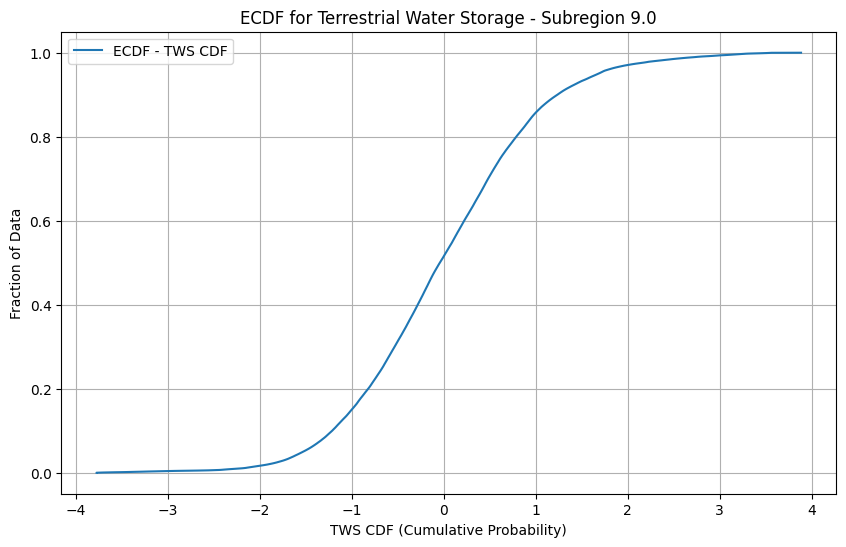

<Figure size 640x480 with 0 Axes>

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
plot_precomputed_ecdf(et_cdf_1, 'TWS CDF', subregion_id, 'Terrestrial Water Storage')


# Precipitation time series
plot_precomputed_ecdf(precip_cdf_1, 'TWS CDF', subregion_id, 'Terrestrial Water Storage')


# TWS time series
plot_precomputed_ecdf(tws_cdf_1, 'TWS CDF', subregion_id, 'Terrestrial Water Storage')


# Adjust layout
plt.tight_layout()
plt.show()

#### Test workflow for the First Subregion - `The Plains (12,910 pixels)`

In [143]:
# Get the first subregion ID and dataset
first_subregion_id = list(subregion_datasets.keys())[0]
ds = subregion_datasets[first_subregion_id]
print(f"Testing subregion: {first_subregion_id}")

Testing subregion: 1.0


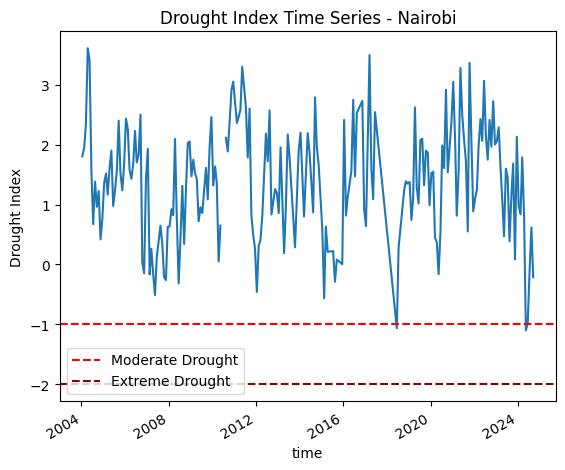

In [ ]:
drought_index_standardized.sel(y=0, x=42, method="nearest").plot()
plt.title("Drought Index Time Series - Nairobi")
plt.axhline(y=-1, color='r', linestyle='--', label="Moderate Drought")
plt.axhline(y=-2, color='darkred', linestyle='--', label="Extreme Drought")
plt.legend()
plt.show()

#### Subregional 

In [168]:
# Function to test and select the best copula
def fit_best_copula(tws_cdf, precip_cdf, et_cdf):
    uniform_data = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    }).dropna()
    
    copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3),
        'tCopula': StudentCopula(dim=3)
    }
    
    results = {}
    for name, copula in copulas.items():
        try:
            copula.fit(uniform_data)
            log_lik = copula.log_lik(uniform_data)
            if name in ['Clayton', 'Gumbel', 'Frank']:
                n_params = np.array(copula.params).size
            elif name == 'Gaussian':
                n_params = copula.params.size
            aic = -2 * log_lik + 2 * n_params
            bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
            results[name] = {
                "Log-Likelihood": log_lik,
                "AIC": aic,
                "BIC": bic,
                "Parameters": copula.params,
                "copula": copula
            }
            print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
        except Exception as e:
            print(f"Error fitting {name} copula: {e}")
            results[name] = {
                "Log-Likelihood": -np.inf,
                "AIC": np.inf,
                "BIC": np.inf,
                "Parameters": None,
                "copula": None
            }
    
    best_copula_name = min(results, key=lambda x: results[x]['AIC'])
    best_copula = results[best_copula_name]['copula']
    print(f"Best copula (by AIC): {best_copula_name} (AIC: {results[best_copula_name]['AIC']:.2f})")
    return best_copula, results


In [170]:
# Function to compute drought index
def compute_copula_index(ds):
    stacked_data = ds[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    
    # Extract CDF values
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    best_copula, copula_results = fit_best_copula(tws_cdf, precip_cdf, et_cdf)
    
    return best_copula, copula_results

In [169]:
best_copulas = {}
copula_metrics = {}
for subregion_id, ds in subregion_datasets.items():
    # Compute ECDFs once
    tws_cdf, precip_cdf, et_cdf = compute_ecdf_statsmodels_consistent(ds)
    ds['tws_cdf'] = tws_cdf
    ds['precip_cdf'] = precip_cdf
    ds['et_cdf'] = et_cdf
    subregion_datasets[subregion_id] = ds
    
    # Fit copula using precomputed CDFs
    best_copula = fit_best_copula(tws_cdf, precip_cdf, et_cdf)
    best_copulas[subregion_id] = best_copula
    copula_metrics[subregion_id] = copula_results

ValueError: Per-column arrays must each be 1-dimensional

In [171]:
# Process all subregions and store results
best_copulas = {}
copula_metrics = {}
for subregion_id, ds in subregion_datasets.items():
    print(f"Processing subregion: {subregion_id}")
    # drought_index, best_copula, copula_results = compute_copula_index(ds)
    # ds['drought_index'] = drought_index
    best_copula, copula_results = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    copula_metrics[subregion_id] = copula_results


Processing subregion: 1.0
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Gaussian Copula: Log-Likelihood=62230.99, AIC=-124455.98, BIC=-124419.55
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Clayton Copula: Log-Likelihood=12341.

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=23103.53, AIC=-46205.07, BIC=-46192.92
Error fitting tCopula copula: Unable to allocate 14.1 TiB for an array with shape (1390176, 1390176) and data type float64
Best copula (by AIC): Gaussian (AIC: -124455.98)
Processing subregion: 2.0
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=15855.36, AIC=-31704.73, BIC=-31661.87
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.4

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10683.98, AIC=-21365.95, BIC=-21351.67
Error fitting tCopula copula: Unable to allocate 1019. TiB for an array with shape (11832912, 11832912) and data type float64
Best copula (by AIC): Clayton (AIC: -70997421.63)
Processing subregion: 3.0
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08  7.820848e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=13447.63, AIC=-26889.25, BIC=-26846.16
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08 

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=14188.07, AIC=-28374.13, BIC=-28359.77
Error fitting tCopula copula: Unable to allocate 1.16 PiB for an array with shape (12786336, 12786336) and data type float64
Best copula (by AIC): Gumbel (AIC: -28374.13)
Processing subregion: 4.0
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.141073e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=13175.95, AIC=-26345.91, BIC=-26306.99
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.14

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10086.22, AIC=-20170.44, BIC=-20157.46
Error fitting tCopula copula: Unable to allocate 73.7 TiB for an array with shape (3183624, 3183624) and data type float64
Best copula (by AIC): Gaussian (AIC: -26345.91)
Processing subregion: 5.0
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.995166e-07
25%    2.500001e-01  2.500001e-01  2.500001e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499999e-01  7.499999e-01  7.499999e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=4805.97, AIC=-9605.95, BIC=-9566.89
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.99516

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=9508.60, AIC=-19015.20, BIC=-19002.18
Error fitting tCopula copula: Unable to allocate 81.1 TiB for an array with shape (3338712, 3338712) and data type float64
Best copula (by AIC): Gumbel (AIC: -19015.20)
Processing subregion: 6.0
                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=2074.84, AIC=-4143.68, BIC=-4107.85
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1457.27, AIC=-2912.53, BIC=-2900.59
Error fitting tCopula copula: Unable to allocate 9.39 TiB for an array with shape (1136160, 1136160) and data type float64
Best copula (by AIC): Gaussian (AIC: -4143.68)
Processing subregion: 7.0
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07
25%    2.500005e-01  2.500005e-01  2.500005e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499995e-01  7.499995e-01  7.499995e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=604.36, AIC=-1202.72, BIC=-1167.00
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1151.15, AIC=-2300.29, BIC=-2288.39
Error fitting tCopula copula: Unable to allocate 8.70 TiB for an array with shape (1093176, 1093176) and data type float64
Best copula (by AIC): Gumbel (AIC: -2300.29)
Processing subregion: 8.0
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01
Gaussian Copula: Log-Likelihood=457.11, AIC=-908.22, BIC=-869.93
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=4780.79, AIC=-9559.57, BIC=-9546.81
Error fitting tCopula copula: Unable to allocate 48.4 TiB for an array with shape (2579904, 2579904) and data type float64
Best copula (by AIC): Clayton (AIC: -15479378.20)
Processing subregion: 9.0
                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998
Gaussian Copula: Log-Likelihood=1135.29, AIC=-2264.59, BIC=-2231.26
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=960.34, AIC=-1918.68, BIC=-1907.57
Error fitting tCopula copula: Unable to allocate 1.77 TiB for an array with shape (492696, 492696) and data type float64
Best copula (by AIC): Gaussian (AIC: -2264.59)


In [142]:
for i in best_copulas.items():
    print ('Subregion - ',i[0],i[1]._name)

Subregion -  1.0 Gaussian
Subregion -  2.0 Clayton
Subregion -  3.0 Gumbel
Subregion -  4.0 Gaussian
Subregion -  5.0 Gumbel
Subregion -  6.0 Gaussian
Subregion -  7.0 Gumbel
Subregion -  8.0 Clayton
Subregion -  9.0 Gaussian


In [172]:
# 18/03/2025
for i in best_copulas.items():
    print ('Subregion - ',i[0],i[1]._name)

Subregion -  1.0 Gaussian
Subregion -  2.0 Clayton
Subregion -  3.0 Gumbel
Subregion -  4.0 Gaussian
Subregion -  5.0 Gumbel
Subregion -  6.0 Gaussian
Subregion -  7.0 Gumbel
Subregion -  8.0 Clayton
Subregion -  9.0 Gaussian


In [307]:
# Process all subregions and store results including tCopula
best_copulas = {}
copula_metrics = {}
for subregion_id, ds in subregion_datasets.items():
    print(f"Processing subregion: {subregion_id}")
    # drought_index, best_copula, copula_results = compute_copula_index(ds)
    # ds['drought_index'] = drought_index
    best_copula, copula_results = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    copula_metrics[subregion_id] = copula_results

Processing subregion: 1.0
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Gaussian Copula: Log-Likelihood=62230.99, AIC=-124455.98, BIC=-124419.55
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Clayton Copula: Log-Likelihood=12341.

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=23103.53, AIC=-46205.07, BIC=-46192.92
Error fitting tCopula copula: Unable to allocate 14.1 TiB for an array with shape (1390176, 1390176) and data type float64
Best copula (by AIC): Gaussian (AIC: -124455.98)
Processing subregion: 2.0
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=15855.36, AIC=-31704.73, BIC=-31661.87
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.4

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10683.98, AIC=-21365.95, BIC=-21351.67
Error fitting tCopula copula: Unable to allocate 1019. TiB for an array with shape (11832912, 11832912) and data type float64
Best copula (by AIC): Clayton (AIC: -70997421.63)
Processing subregion: 3.0
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08  7.820848e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Gaussian Copula: Log-Likelihood=13447.63, AIC=-26889.25, BIC=-26846.16
                tws        precip            et
count  1.278634e+07  1.278634e+07  1.278634e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    7.820848e-08  7.820848e-08 

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=14188.07, AIC=-28374.13, BIC=-28359.77
Error fitting tCopula copula: Unable to allocate 1.16 PiB for an array with shape (12786336, 12786336) and data type float64
Best copula (by AIC): Gumbel (AIC: -28374.13)
Processing subregion: 4.0
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.141073e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=13175.95, AIC=-26345.91, BIC=-26306.99
                tws        precip            et
count  3.183624e+06  3.183624e+06  3.183624e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.141073e-07  3.141073e-07  3.14

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=10086.22, AIC=-20170.44, BIC=-20157.46
Error fitting tCopula copula: Unable to allocate 73.7 TiB for an array with shape (3183624, 3183624) and data type float64
Best copula (by AIC): Gaussian (AIC: -26345.91)
Processing subregion: 5.0
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.995166e-07
25%    2.500001e-01  2.500001e-01  2.500001e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499999e-01  7.499999e-01  7.499999e-01
max    9.999997e-01  9.999997e-01  9.999997e-01
Gaussian Copula: Log-Likelihood=4805.97, AIC=-9605.95, BIC=-9566.89
                tws        precip            et
count  3.338712e+06  3.338712e+06  3.338712e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    2.995166e-07  2.995166e-07  2.99516

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=9508.60, AIC=-19015.20, BIC=-19002.18
Error fitting tCopula copula: Unable to allocate 81.1 TiB for an array with shape (3338712, 3338712) and data type float64
Best copula (by AIC): Gumbel (AIC: -19015.20)
Processing subregion: 6.0
                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=2074.84, AIC=-4143.68, BIC=-4107.85
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.136160e+06  1.136160e+06  1.136160e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    8.801569e-07  8.801569e-07  8.801569e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999991e-01  9.999991e-01  9.999991e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1457.27, AIC=-2912.53, BIC=-2900.59
Error fitting tCopula copula: Unable to allocate 9.39 TiB for an array with shape (1136160, 1136160) and data type float64
Best copula (by AIC): Gaussian (AIC: -4143.68)
Processing subregion: 7.0
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07
25%    2.500005e-01  2.500005e-01  2.500005e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499995e-01  7.499995e-01  7.499995e-01
max    9.999991e-01  9.999991e-01  9.999991e-01
Gaussian Copula: Log-Likelihood=604.36, AIC=-1202.72, BIC=-1167.00
                tws        precip            et
count  1.093176e+06  1.093176e+06  1.093176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    9.147649e-07  9.147649e-07  9.147649e-07

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=1151.15, AIC=-2300.29, BIC=-2288.39
Error fitting tCopula copula: Unable to allocate 8.70 TiB for an array with shape (1093176, 1093176) and data type float64
Best copula (by AIC): Gumbel (AIC: -2300.29)
Processing subregion: 8.0
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01
Gaussian Copula: Log-Likelihood=457.11, AIC=-908.22, BIC=-869.93
                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  2.579904e+06  2.579904e+06  2.579904e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    3.876112e-07  3.876112e-07  3.876112e-07
25%    2.500002e-01  2.500002e-01  2.500002e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499998e-01  7.499998e-01  7.499998e-01
max    9.999996e-01  9.999996e-01  9.999996e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=4780.79, AIC=-9559.57, BIC=-9546.81
Error fitting tCopula copula: Unable to allocate 48.4 TiB for an array with shape (2579904, 2579904) and data type float64
Best copula (by AIC): Clayton (AIC: -15479378.20)
Processing subregion: 9.0
                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998
Gaussian Copula: Log-Likelihood=1135.29, AIC=-2264.59, BIC=-2231.26
Error fitting Clayton copula: theta must be positive when dim > 2
Error fitting Frank copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                 tws         precip             et
count  492696.000000  492696.000000  492696.000000
mean        0.500000       0.500000       0.500000
std         0.288675       0.288675       0.288675
min         0.000002       0.000002       0.000002
25%         0.250001       0.250001       0.250001
50%         0.500000       0.500000       0.500000
75%         0.749999       0.749999       0.749999
max         0.999998       0.999998       0.999998


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Gumbel Copula: Log-Likelihood=960.34, AIC=-1918.68, BIC=-1907.57
Error fitting tCopula copula: Unable to allocate 1.77 TiB for an array with shape (492696, 492696) and data type float64
Best copula (by AIC): Gaussian (AIC: -2264.59)


In [308]:
for i in best_copulas.items():
    print ('Subregion - ',i[0],i[1]._name)

Subregion -  1.0 Gaussian
Subregion -  2.0 Clayton
Subregion -  3.0 Gumbel
Subregion -  4.0 Gaussian
Subregion -  5.0 Gumbel
Subregion -  6.0 Gaussian
Subregion -  7.0 Gumbel
Subregion -  8.0 Clayton
Subregion -  9.0 Gaussian


In [423]:
# Save the final dataset
final_ds = combined_ds.copy()
final_ds.to_netcdf(os.path.join(dataset, 'drought_index_gha_base.nc'))  # Base dataset without drought index
print("Base dataset saved as 'drought_index_gha_base.nc'")

Base dataset saved as 'drought_index_gha_base.nc'


In [155]:
subregion_datasets

{1.0: <xarray.Dataset>
 Dimensions:      (time: 219, y: 671, x: 337)
 Coordinates:
   * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
   * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
   * x            (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.28 -11.33 -11.38
     lon          (x) float64 30.33 30.38 30.48 30.53 ... 51.18 51.28 51.33 51.38
     band         int64 1
     spatial_ref  int64 0
     month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
 Data variables:
     tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
     precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
     landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
     tws_anom     (y, x, time) float64 nan nan

In [157]:
# Lookup and apply functions
def lookup_best_copula(subregion_id):
    if subregion_id not in best_copulas:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    best_copula = best_copulas[subregion_id]
    metrics = copula_metrics[subregion_id]
    best_copula_name = min(metrics, key=lambda x: metrics[x]['AIC'])
    
    print(f"Subregion {subregion_id}:")
    print(f"Best Copula: {best_copula_name}")
    print(f"Log-Likelihood: {metrics[best_copula_name]['Log-Likelihood']:.2f}")
    print(f"AIC: {metrics[best_copula_name]['AIC']:.2f}")
    print(f"BIC: {metrics[best_copula_name]['BIC']:.2f}")
    print(f"Parameters: {metrics[best_copula_name]['Parameters']}")
    return best_copula

In [159]:

def apply_best_copula(subregion_id):
    if subregion_id not in subregion_datasets:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    ds = subregion_datasets[subregion_id]
    best_copula = best_copulas[subregion_id]
    
    stacked_data = ds[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    common_mask = (tws_cdf.notnull() & precip_cdf.notnull() & et_cdf.notnull()).values
    
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    })[common_mask]
    joint_cdf = best_copula.cdf(data_for_cdf)
    joint_cdf = np.clip(joint_cdf, 0.001, 0.999)
    
    drought_index = norm.ppf(joint_cdf)
    
    full_drought_index = xr.DataArray(
        np.full(stacked_data['tws_cdf'].shape, np.nan),
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    )
    # valid_indices = stacked_data['tws_cdf'].notnull().values
    full_drought_index.values[common_mask] = drought_index
    
    print(f"Drought index recomputed for subregion {subregion_id} using {best_copula.__class__.__name__}")
    return full_drought_index.unstack()


In [299]:
# Updated apply_best_copula
def apply_best_copula(subregion_id):
    if subregion_id not in subregion_datasets:
        raise ValueError(f"Subregion {subregion_id} not found in processed data.")
    
    ds = subregion_datasets[subregion_id]
    best_copula = best_copulas[subregion_id]
    
    # Get the subregion mask from the full dataset and ensure it’s 2D (y, x)
    subregion_mask_2d = (combined_ds['landform'] == subregion_id)
    
    # Apply the mask to limit the subregion dataset’s spatial extent
    ds_masked = ds.where(subregion_mask_2d)
    
    # Stack with consistent dimension order (assuming time, y, x)
    stacked_data = ds_masked[['tws_cdf', 'precip_cdf', 'et_cdf']].stack(all_points=['time', 'y', 'x'])
    tws_cdf = stacked_data['tws_cdf']
    precip_cdf = stacked_data['precip_cdf']
    et_cdf = stacked_data['et_cdf']
    
    # Common mask for valid data within the subregion
    common_mask = (tws_cdf.notnull() & precip_cdf.notnull() & et_cdf.notnull()).values
    
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf.values,
        'precip': precip_cdf.values,
        'et': et_cdf.values
    })[common_mask]
    
    joint_cdf = best_copula.cdf(data_for_cdf)
    joint_cdf = np.clip(joint_cdf, 0.001, 0.999)
    drought_index = norm.ppf(joint_cdf)
    
    # Create the subregion drought index
    full_drought_index = xr.DataArray(
        np.full(stacked_data['tws_cdf'].shape, np.nan),
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    )
    full_drought_index.values[common_mask] = drought_index
    
    drought_index_da = full_drought_index.unstack()
    print(f"Drought index computed for subregion {subregion_id} using {best_copula.__class__.__name__}")
    return drought_index_da

In [177]:
# Combine drought indices into one for the full study area
def compute_full_drought_index():
    full_drought_index = xr.full_like(combined_ds['et'], np.nan)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        subregion_mask = combined_ds['landform'] == subregion_id
        full_drought_index = xr.where(subregion_mask, drought_index_subregion, full_drought_index)
    
    return full_drought_index

In [225]:
def compute_full_drought_index():
    full_drought_index = xr.full_like(combined_ds['tws'], np.nan)
    full_drought_array = full_drought_index.values  # Shape: (time, y, x)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        
        # Get the 2D spatial mask from the full dataset
        subregion_mask_2d = (combined_ds['landform'] == subregion_id).values
        
        # Broadcast to 3D
        time_size = full_drought_array.shape[0]
        subregion_mask_3d = np.broadcast_to(subregion_mask_2d[np.newaxis, :, :], (time_size,) + subregion_mask_2d.shape)
        
        # Verify shapes
        print(f"Subregion {subregion_id}:")
        print(f"  Full array shape: {full_drought_array.shape}")
        print(f"  Mask 3D shape: {subregion_mask_3d.shape}")
        print(f"  Drought index shape: {drought_index_subregion.shape}")
        print(f"  Number of True in mask: {subregion_mask_3d.sum()}")
        print(f"  Number of elements in drought index: {drought_index_subregion.size}")
        
        # Assign values, ensuring the number of elements matches
        if subregion_mask_3d.sum() == drought_index_subregion.size:
            full_drought_array[subregion_mask_3d] = drought_index_subregion.values.flatten()
        else:
            # If sizes don’t match, select only valid points from the subregion
            valid_mask = ~np.isnan(drought_index_subregion.values)
            if valid_mask.sum() == subregion_mask_3d.sum():
                full_drought_array[subregion_mask_3d] = drought_index_subregion.values[valid_mask]
            else:
                raise ValueError(f"Size mismatch for subregion {subregion_id}: mask has {subregion_mask_3d.sum()} True values, but drought index has {drought_index_subregion.size} elements, with {valid_mask.sum()} non-NaN")

    full_drought_index.values = full_drought_array
    return full_drought_index

In [301]:
# Updated compute_full_drought_index
def compute_full_drought_index():
    # Ensure full_drought_index matches combined_ds['tws'] shape (time, y, x)
    full_drought_index = xr.full_like(combined_ds['et'], np.nan)
    full_drought_array = full_drought_index.values  # Expected shape: (219, 698, 591)
    
    for subregion_id in subregion_datasets.keys():
        print(f"Applying best copula to subregion {subregion_id}")
        drought_index_subregion = apply_best_copula(subregion_id)
        
        # 2D mask from the full dataset
        subregion_mask_2d = (combined_ds['landform'] == subregion_id).values
        
        # Broadcast to 3D, ensuring time is the first dimension
        time_size = combined_ds['tws'].shape[0]  # e.g., 219
        subregion_mask_3d = np.broadcast_to(subregion_mask_2d[np.newaxis, :, :], (time_size,) + subregion_mask_2d.shape)
        
        # Debug shapes
        print(f"Subregion {subregion_id}:")
        print(f"  Full array shape: {full_drought_array.shape}")
        print(f"  Mask 3D shape: {subregion_mask_3d.shape}")
        print(f"  Drought index shape: {drought_index_subregion.shape}")
        print(f"  Number of True in mask: {subregion_mask_3d.sum()}")
        print(f"  Number of elements in drought index: {drought_index_subregion.size}")
        print(f"  Non-NaN in drought index: {np.isfinite(drought_index_subregion.values).sum()}")
        
        # Assign only non-NaN values from the subregion
        valid_mask = np.isfinite(drought_index_subregion.values)
        if subregion_mask_3d.sum() == valid_mask.sum():
            full_drought_array[subregion_mask_3d] = drought_index_subregion.values[valid_mask]
        else:
            raise ValueError(f"Size mismatch for subregion {subregion_id}: mask has {subregion_mask_3d.sum()} True values, "
                            f"but drought index has {valid_mask.sum()} non-NaN values")

    full_drought_index.values = full_drought_array
    return full_drought_index

In [302]:
# Compute and save the full drought index
full_drought_index = compute_full_drought_index()
final_ds = combined_ds.copy()
final_ds['drought_index'] = full_drought_index

Applying best copula to subregion 1.0
Drought index computed for subregion 1.0 using GaussianCopula
Subregion 1.0:
  Full array shape: (219, 698, 591)
  Mask 3D shape: (698, 698, 591)
  Drought index shape: (219, 671, 337)
  Number of True in mask: 9011180
  Number of elements in drought index: 49521813
  Non-NaN in drought index: 1390176


ValueError: Size mismatch for subregion 1.0: mask has 9011180 True values, but drought index has 1390176 non-NaN values

In [226]:
# Compute and save the full drought index
full_drought_index = compute_full_drought_index()
final_ds = combined_ds.copy()
final_ds['drought_index'] = full_drought_index

Applying best copula to subregion 1.0
Drought index recomputed for subregion 1.0 using GaussianCopula
Subregion 1.0:
  Full array shape: (698, 591, 219)
  Mask 3D shape: (698, 698, 591)
  Drought index shape: (219, 671, 337)
  Number of True in mask: 9011180
  Number of elements in drought index: 49521813


ValueError: Size mismatch for subregion 1.0: mask has 9011180 True values, but drought index has 49521813 elements, with 1390176 non-NaN

In [ ]:
final_ds.to_netcdf('drought_index_gha_full.nc')
print("Full drought index dataset saved as 'drought_index_gha_full.nc'")

In [ ]:
# Visualize
plt.figure(figsize=(12, 8))
full_drought_index.isel(time=0).plot(cmap='RdBu_r', vmin=-3, vmax=3)
plt.title("Full Study Area Drought Index (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### Testing Individual Subregions

In [451]:
# Example usage
first_subregion_id = list(subregion_datasets.keys())[0]
best_copula = lookup_best_copula(first_subregion_id)
new_drought_index = apply_best_copula(first_subregion_id)

Subregion 1.0:
Best Copula: Gaussian
Log-Likelihood: 62230.99
AIC: -124455.98
BIC: -124419.55
Parameters: [0.06915876 0.28476279 0.00718228]
Drought index recomputed for subregion 1.0 using GaussianCopula


In [309]:
best_copula

In [325]:
ran = best_copula.random(1300000)

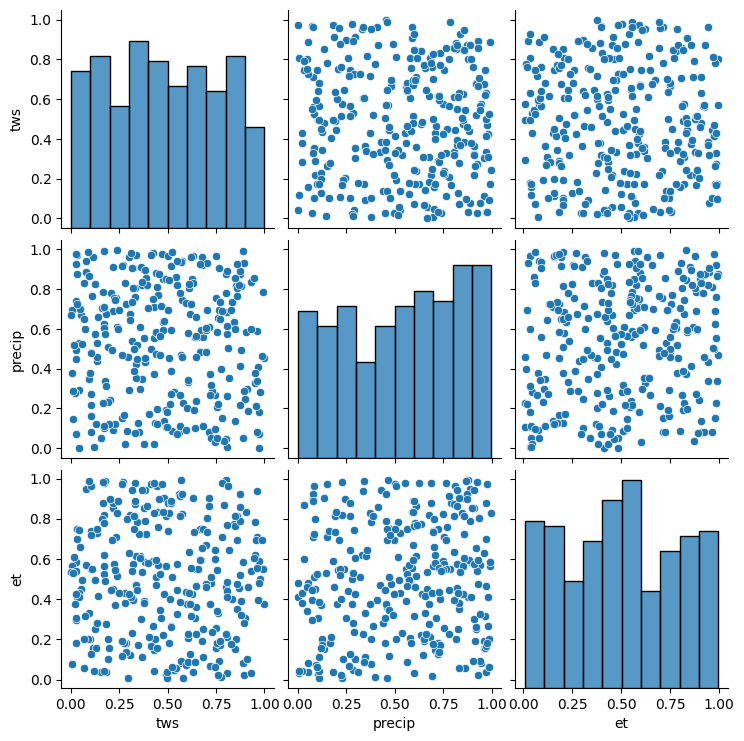

In [337]:
sns.pairplot(ran[:300])
plt.show()

In [176]:
# Example usage
first_subregion_id = list(subregion_datasets.keys())[0]
best_copula = lookup_best_copula(first_subregion_id)
new_drought_index = apply_best_copula(first_subregion_id)

Subregion 1.0:
Best Copula: Gaussian
Log-Likelihood: 62230.99
AIC: -124455.98
BIC: -124419.55
Parameters: [0.06915878 0.28476277 0.00718232]
Drought index recomputed for subregion 1.0 using GaussianCopula


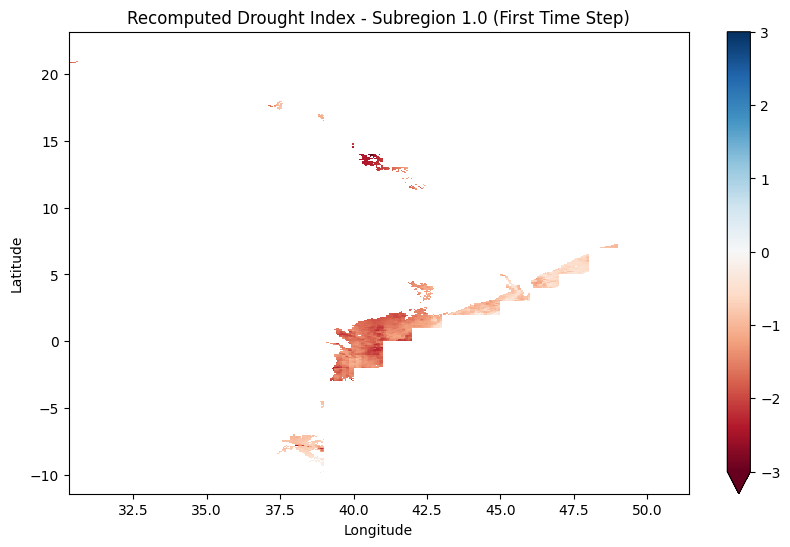

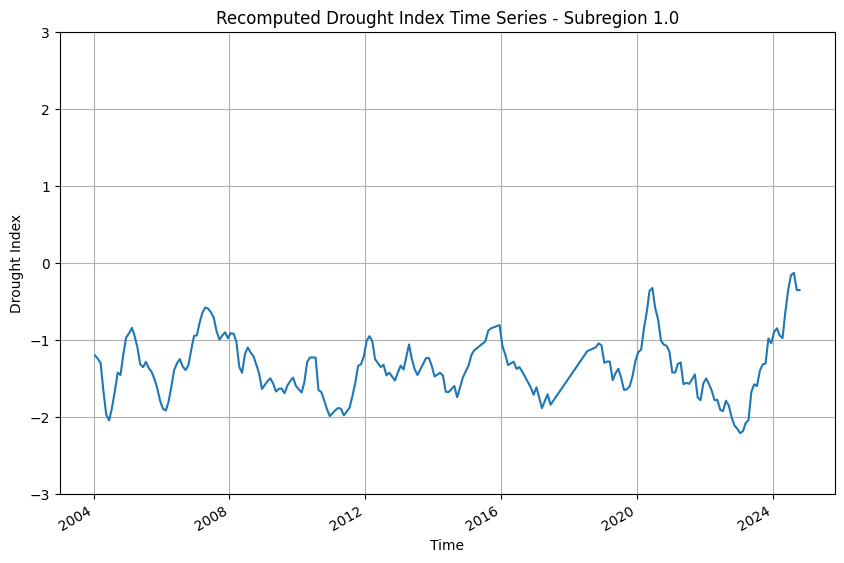

In [190]:
# Visualize
plt.figure(figsize=(10, 6))
new_drought_index.isel(time=1).plot(cmap='RdBu', vmin=-3, vmax=3)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(new_drought_index, span=6).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

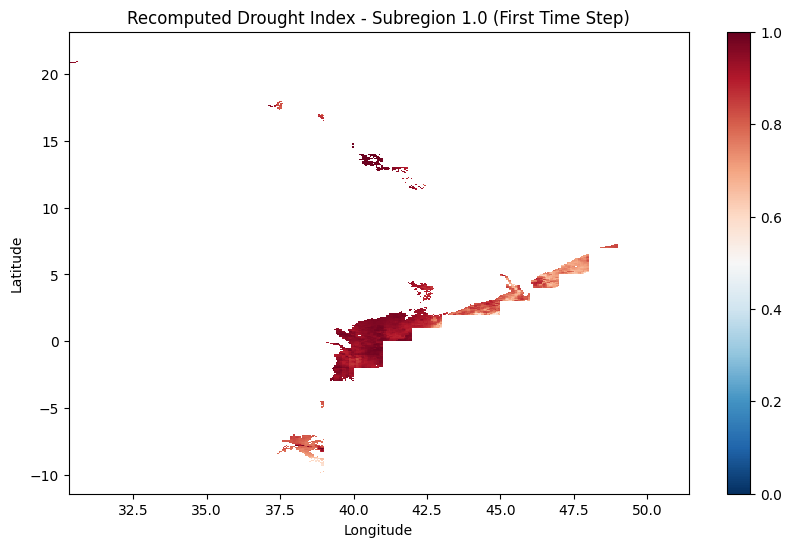

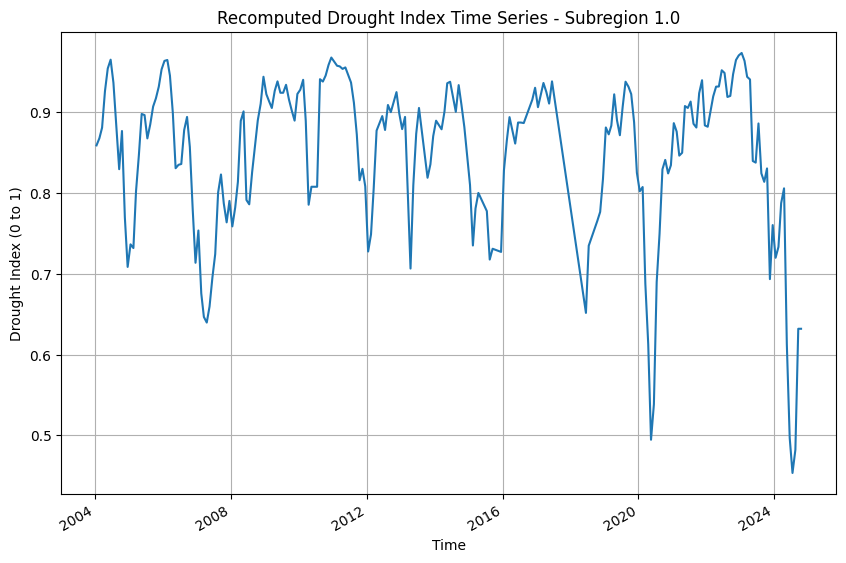

In [495]:
# Visualize
plt.figure(figsize=(10, 6))
new_drought_index.isel(time=1).plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(new_drought_index, span=3).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

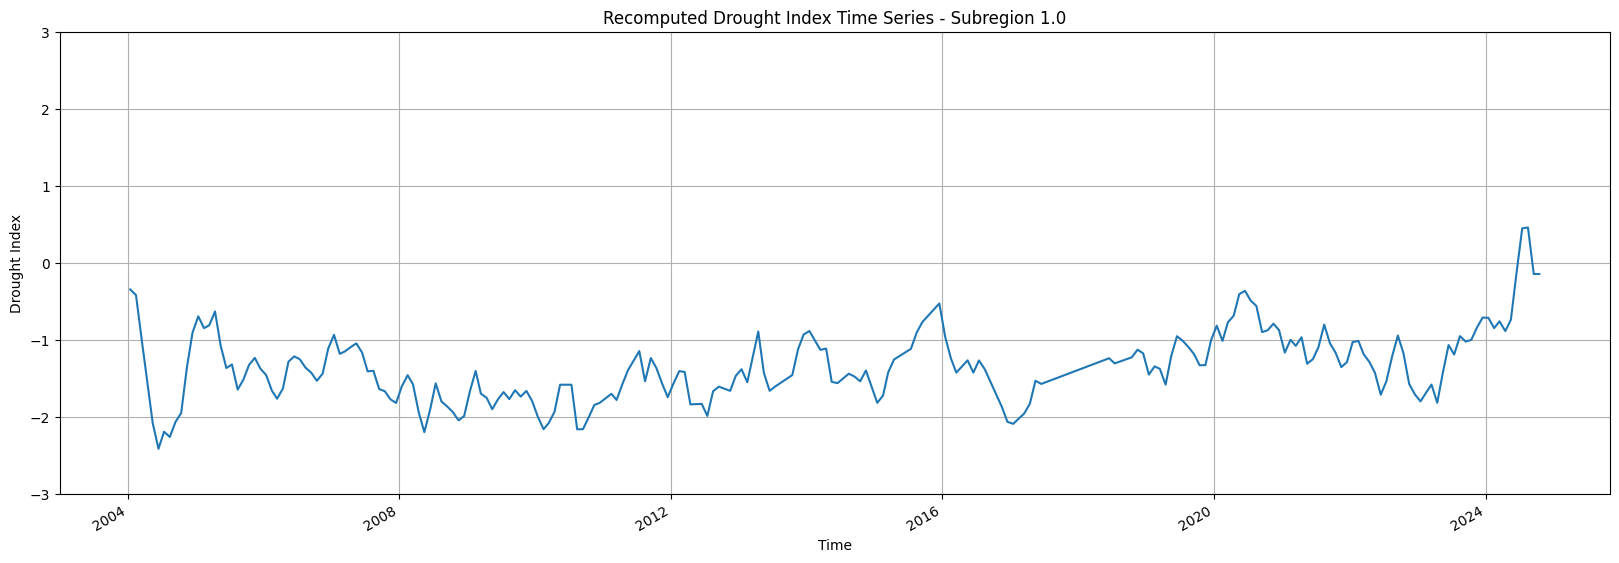

In [218]:
plt.figure(figsize=(20, 6))
apply_ema(new_drought_index, span=6).sel(y=5, x=47.5, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

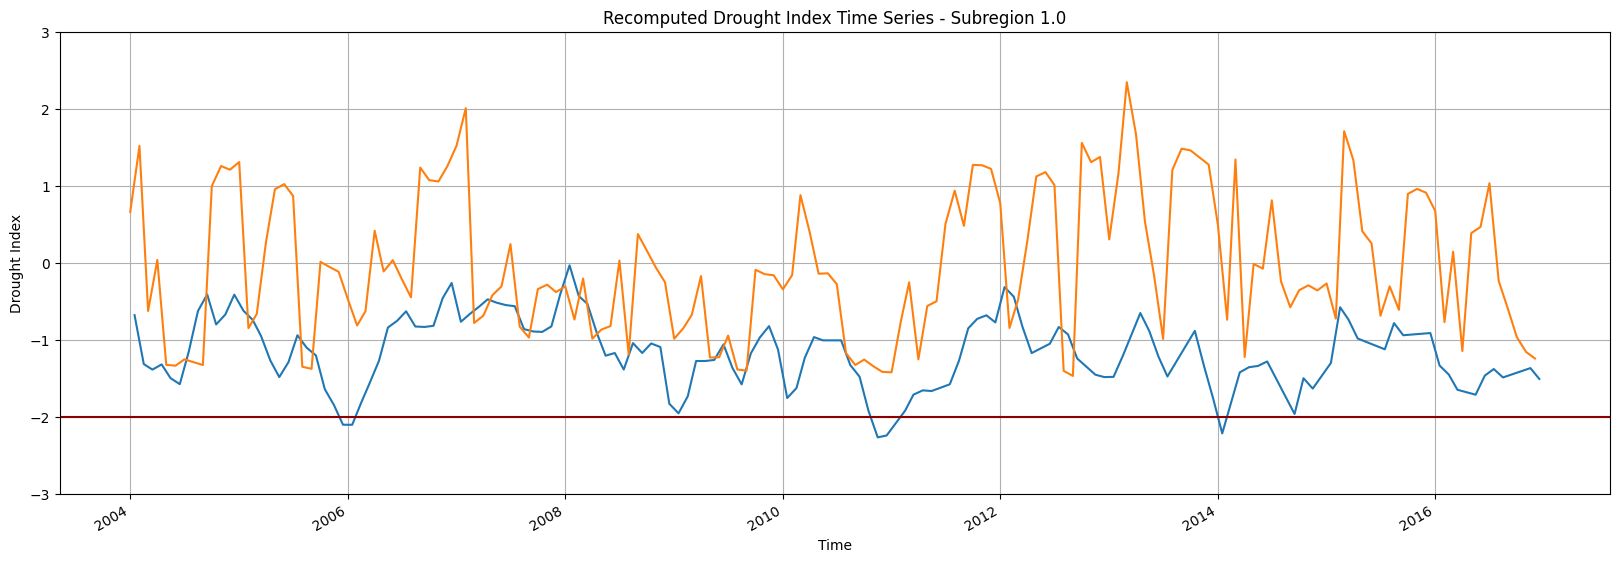

In [221]:
plt.figure(figsize=(20, 6))
apply_ema(new_drought_index.sel(time=slice('2004-01-01', '2016-12-31')), span=3).sel(y=0, x=40, method="nearest").plot(label="GHDI")
spei03.sel(lat=5, lon=47.5, method="nearest").plot(label="SPEI-03")
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.axhline(y=-2, color='darkred')
plt.grid(True)
plt.show()

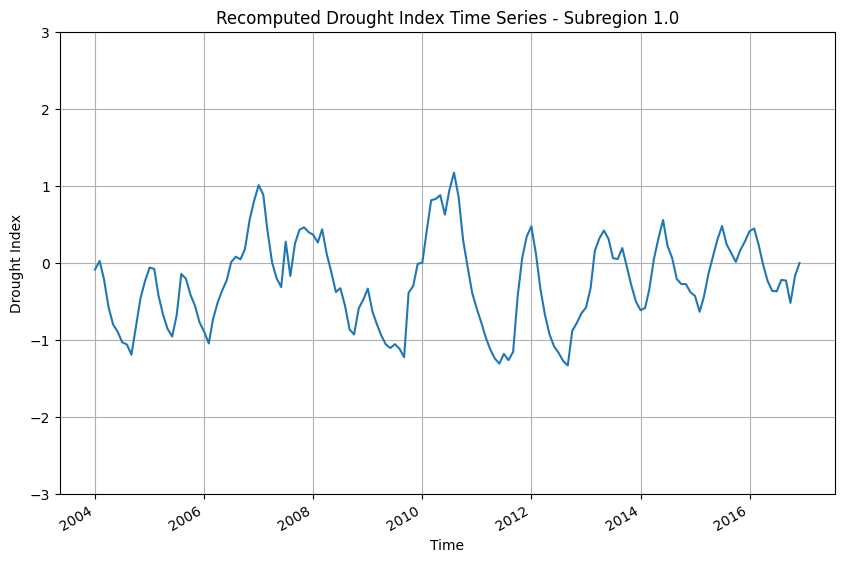

In [214]:
plt.figure(figsize=(10, 6))
# apply_ema(new_drought_index, span=6).sel(y=0, x=40, method="nearest").plot(label="GHDI")
apply_ema(spei03, span=6).sel(lat=0, lon=40, method="nearest").plot(label="SPEI-03")
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [202]:
spei03 = xr.open_dataset(os.path.join(dataset, 'validation_datasets/spei03.nc')).spei.sel(time=slice('2004-01-01', None))
spei03

<xarray.DataArray 'spei' (time: 156, lat: 1800, lon: 2080)>
[584064000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 47.97 47.92 47.88 47.83 ... -41.88 -41.92 -41.97
  * lon      (lon) float32 -27.98 -27.92 -27.88 -27.83 ... 75.88 75.93 75.97
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2016-12-01
Attributes:
    units:      z value
    long_name:  Standardized Precipitation Evapotranspiration Index

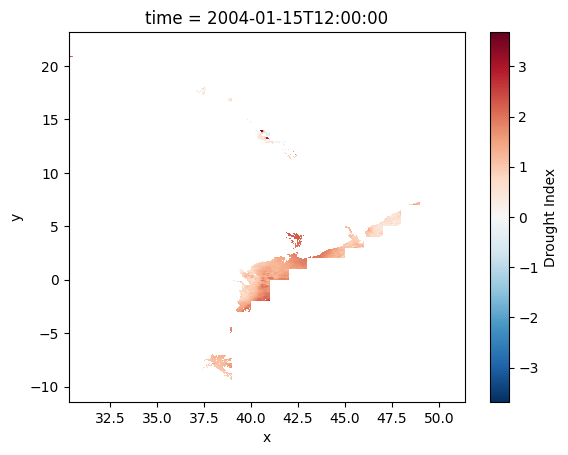

In [474]:
stand.isel(time=0).plot()

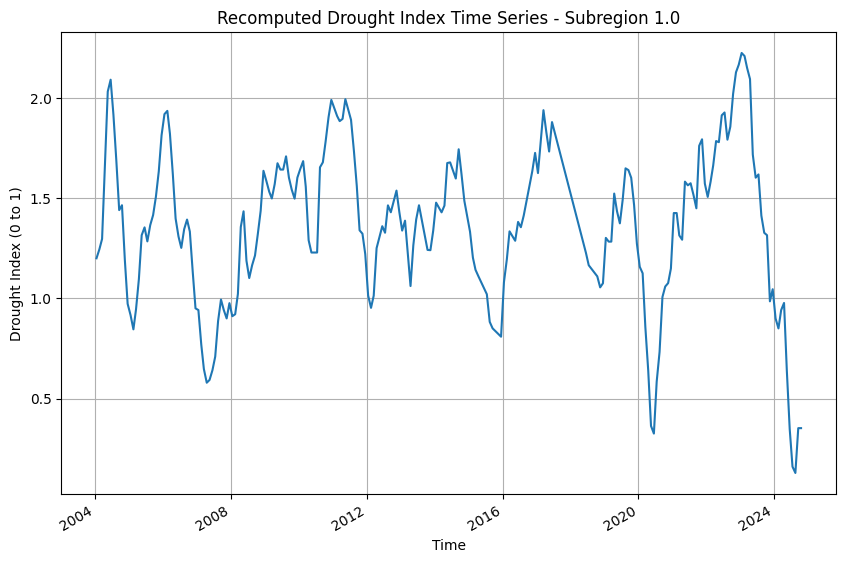

In [493]:
plt.figure(figsize=(10, 6))
apply_ema(stand, span=6).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

In [497]:
# Example usage
fteen_subregion_id = list(subregion_datasets.keys())[13]
best_copula_14 = lookup_best_copula(fteen_subregion_id)
new_drought_index_14 = apply_best_copula(fteen_subregion_id)

Subregion 14.0:
Best Copula: Gaussian
Log-Likelihood: 1115.14
AIC: -2224.28
BIC: -2190.98
Parameters: [-0.02276805 -0.04167455  0.04874515]
Drought index recomputed for subregion 14.0 using GaussianCopula


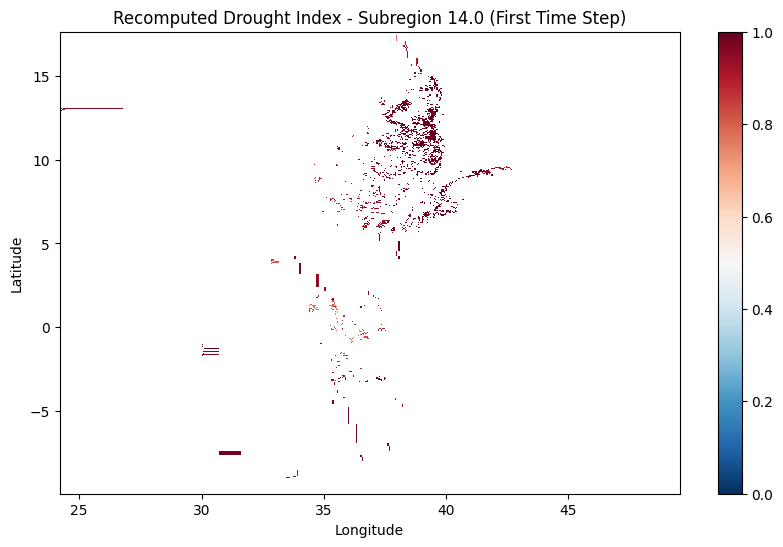

In [482]:
plt.figure(figsize=(10, 6))
new_drought_index_14.isel(time=1).plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

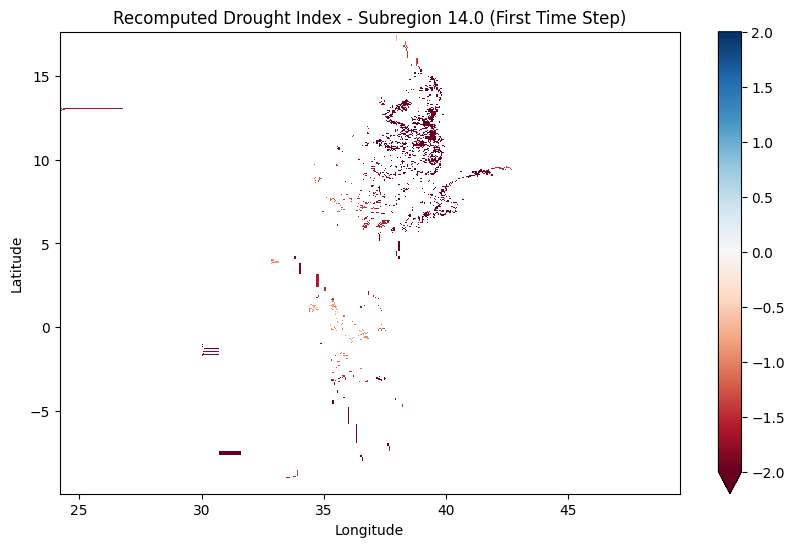

In [509]:
plt.figure(figsize=(10, 6))
new_drought_index_14.isel(time=1).plot(cmap='RdBu',  vmin=-2, vmax=2)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

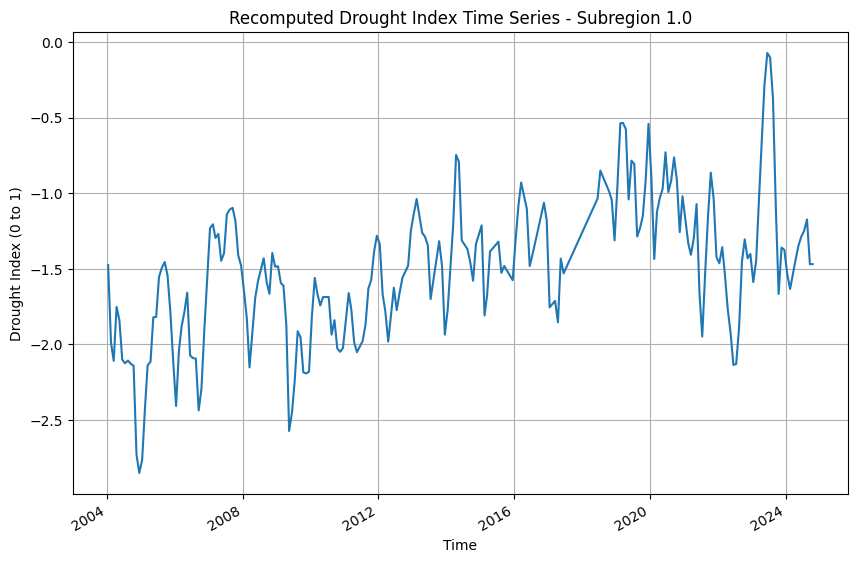

In [502]:
plt.figure(figsize=(10, 6))
apply_ema(new_drought_index_14, span=3).mean(dim=['y', 'x']).plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index (0 to 1)")
plt.grid(True)
plt.show()

In [510]:
new = new_drought_index_14.combine_first(new_drought_index)

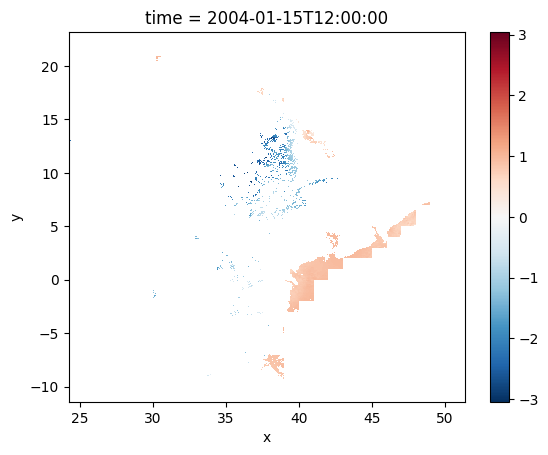

In [511]:
new.isel(time=0).plot()

In [516]:
drought_list = []
for subregion_id in subregion_datasets:
    drought_list.append(apply_best_copula(subregion_id))
    
drought_list

Drought index recomputed for subregion 1.0 using GaussianCopula
Drought index recomputed for subregion 2.0 using ClaytonCopula
Drought index recomputed for subregion 3.0 using GumbelCopula
Drought index recomputed for subregion 4.0 using GaussianCopula
Drought index recomputed for subregion 5.0 using GumbelCopula
Drought index recomputed for subregion 6.0 using GaussianCopula
Drought index recomputed for subregion 7.0 using GumbelCopula
Drought index recomputed for subregion 8.0 using GumbelCopula
Drought index recomputed for subregion 9.0 using GaussianCopula
Drought index recomputed for subregion 10.0 using GumbelCopula
Drought index recomputed for subregion 11.0 using GaussianCopula
Drought index recomputed for subregion 12.0 using GumbelCopula
Drought index recomputed for subregion 13.0 using ClaytonCopula
Drought index recomputed for subregion 14.0 using GaussianCopula
Drought index recomputed for subregion 15.0 using GaussianCopula


[<xarray.DataArray (time: 219, y: 671, x: 337)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
        

In [224]:
drought_list = []
for subregion_id in subregion_datasets:
    drought_list.append(apply_best_copula(subregion_id))

Drought index recomputed for subregion 1.0 using GaussianCopula
Drought index recomputed for subregion 2.0 using ClaytonCopula
Drought index recomputed for subregion 3.0 using GumbelCopula
Drought index recomputed for subregion 4.0 using GaussianCopula
Drought index recomputed for subregion 5.0 using GumbelCopula
Drought index recomputed for subregion 6.0 using GaussianCopula
Drought index recomputed for subregion 7.0 using GumbelCopula
Drought index recomputed for subregion 8.0 using ClaytonCopula
Drought index recomputed for subregion 9.0 using GaussianCopula


In [257]:
on = drought_list[0].combine_first(drought_list[1])

In [269]:
on = on.combine_first(drought_list[8])

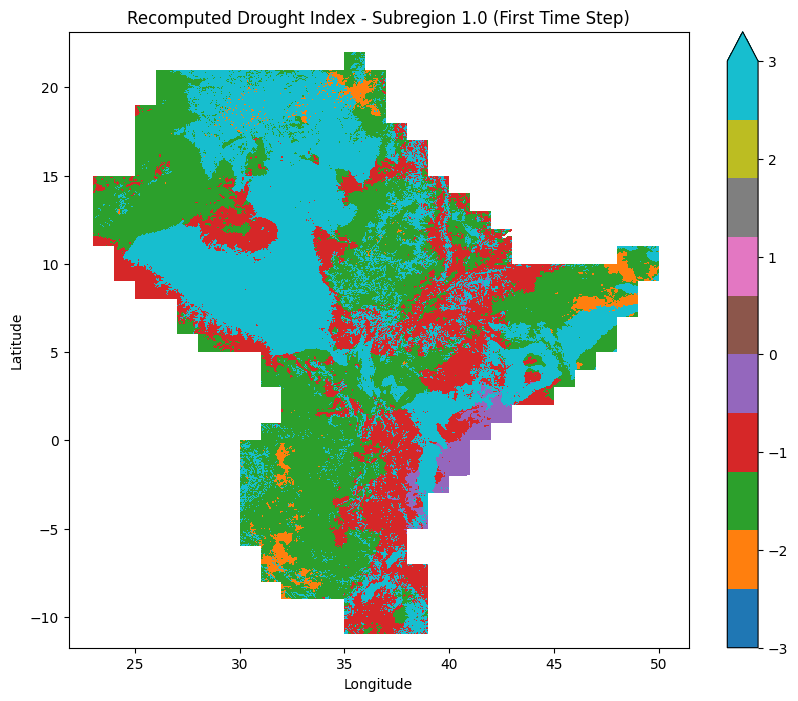

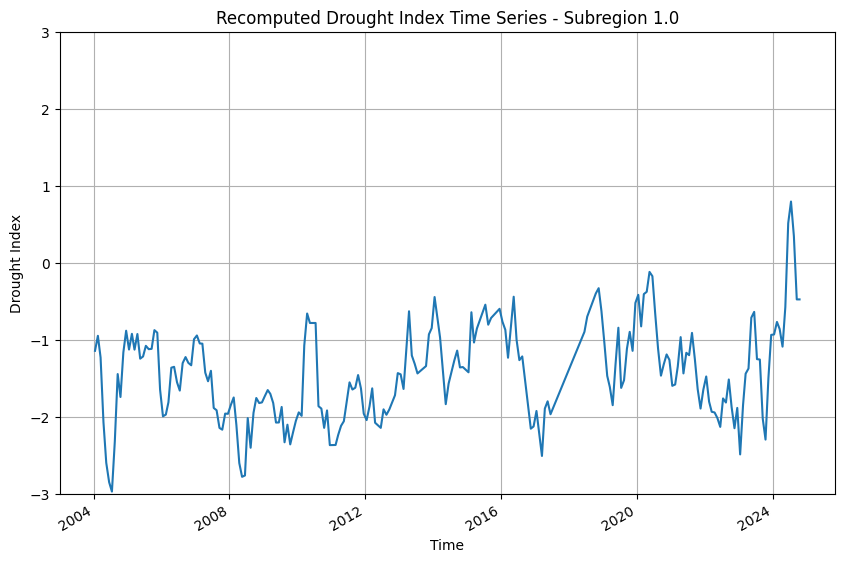

In [286]:
# Visualize
plt.figure(figsize=(10, 8))
on.sel(time=slice("2007-01-01", "2007-12-31")).mean(dim="time").plot(cmap='tab10', vmin=-3, vmax=3)
plt.title(f"Recomputed Drought Index - Subregion {first_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(10, 6))
apply_ema(on, span=3).sel(y=6, x=45, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [304]:
on.to_netcdf(os.path.join(dataset, 'results/ghdi.nc'))

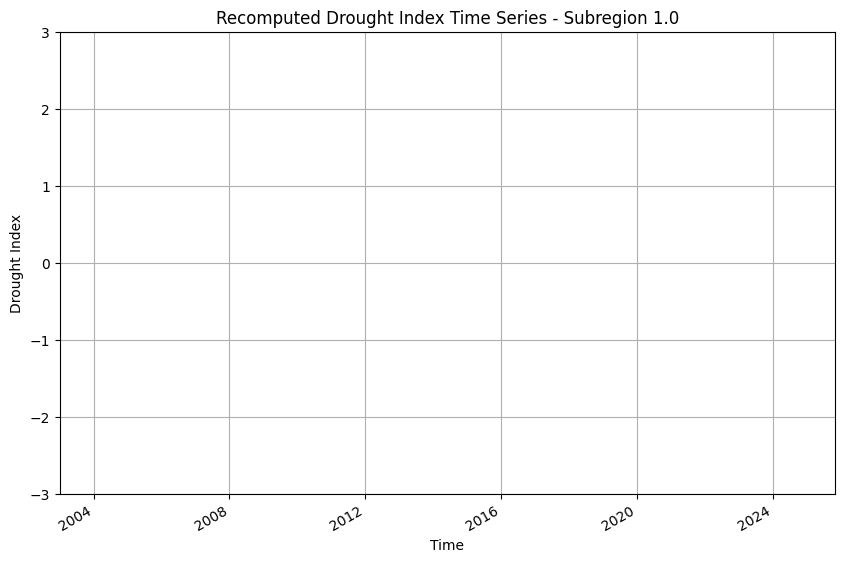

In [287]:
plt.figure(figsize=(10, 6))
apply_ema(on, span=3).sel(y=9, x=30, method="nearest").plot()
plt.title(f"Recomputed Drought Index Time Series - Subregion {first_subregion_id}")
plt.xlabel("Time")
plt.ylabel("Drought Index")
plt.ylim(-3, 3)  # Set y-axis limits to -3 and 3
plt.grid(True)
plt.show()

In [256]:
# Combine all DataArrays into a single DataArray
combined_drought = xr.combine_by_coords([i for i in drought_list])

# Optional: Rename the variable for clarity
combined_drought = combined_drought.rename("drought_index")

print(combined_drought)

ValueError: cannot reindex or align along dimension 'y' because the (pandas) index has duplicate values

In [251]:
import xarray as xr

# Create a dictionary mapping subregion IDs to DataArrays
drought_dict = {subregion_id: da for subregion_id, da in zip(subregion_datasets.keys(), drought_list)}

# Combine into a Dataset with a subregion dimension
combined_dataset = xr.Dataset(drought_dict)  # Adjust variable name if needed

# Optional: Assign a coordinate to the subregion dimension
combined_dataset = combined_dataset.assign_coords(subregion=list(subregion_datasets.keys()))

print(combined_dataset)

<xarray.Dataset>
Dimensions:    (time: 219, y: 698, x: 591, subregion: 9)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y          (y) float64 -11.73 -11.68 -11.63 -11.58 ... 23.02 23.07 23.12
  * x          (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * subregion  (subregion) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
Data variables:
    1.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    2.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    3.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    4.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    5.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    6.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    7.0        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    8.0        (time, y, x) f

In [345]:
drought_list[1]

<xarray.DataArray (time: 219, y: 686, x: 543)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y        (y) float64 22.87 22.82 22.77 22.72 ... -11.58 -11.63 -11.68 -11.73
  * x        (x) float64 23.28 23.33 23.38 23.43 ... 50.83 50.88 50.93 50.98

In [253]:
combined_dataset['1.0'].isel(time=3).plot(cmap='RdBu')
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

KeyError: '1'

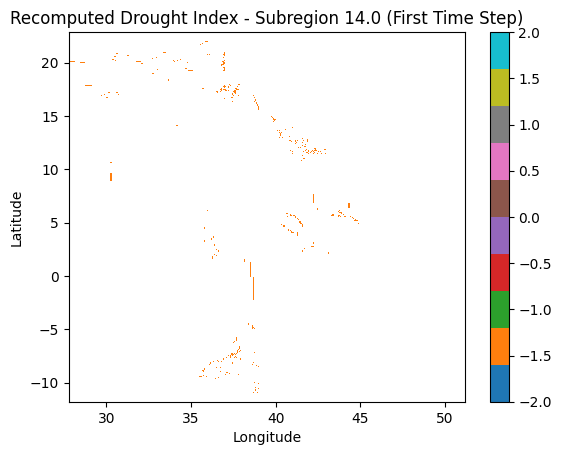

In [576]:
drought_list[10].mean(dim='time').plot(cmap='tab10', vmin=-2, vmax=2)
plt.title(f"Recomputed Drought Index - Subregion {fteen_subregion_id} (First Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [487]:
# Initialize an empty dataset with the full grid
full_drought_index = xr.full_like(full_ghdi['et'].isel(time=0), np.nan)

# Fill in each subregion
for subregion_id, ds in subregion_datasets.items():
    
    subregion_mask = full_ghdi['landform'] == subregion_id
    full_drought_index = full_drought_index.where(~subregion_mask, ds['drought_index'])

# Add to combined dataset
full_ghdi['drought_index'] = full_drought_index

# Save or analyze the result
# combined_ds.to_netcdf('drought_index_gha.nc')
print(full_ghdi['drought_index'])

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'y' ('y',)

In [485]:
full_ghdi

<xarray.Dataset>
Dimensions:      (time: 219, y: 698, x: 591)
Coordinates:
  * time         (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:...
    lat          (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
    lon          (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    band         int64 1
  * y            (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * x            (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
    spatial_ref  int64 0
Data variables:
    tws          (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan
    precip       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    et           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    landform     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

#### Copula Analysis with copulae Module

In [136]:
# Function to test and select the best copula
def fit_best_copula(tws_cdf, precip_cdf, et_cdf):
    # Combine CDFs into a DataFrame (copulae expects a 2D array)
    data = np.vstack([tws_cdf, precip_cdf, et_cdf]).T
    data_df = pd.DataFrame(data, columns=['tws', 'precip', 'et'])
    
    # List of copulas to test
    copulas = {
        'Gaussian': GaussianCopula(dim=3),
        'Clayton': ClaytonCopula(dim=3),
        'Frank': FrankCopula(dim=3),
        'Gumbel': GumbelCopula(dim=3)
    }
    
    # Dictionary to store fit results
    fit_results = {}
    
    # Fit each copula and compute AIC
    for name, copula in copulas.items():
        try:
            copula.fit(data_df)
            log_likelihood = copula.log_lik(data_df)
            n_params = len(copula.params)  # Number of parameters in the copula
            aic = -2 * log_likelihood + 2 * n_params  # AIC formula
            fit_results[name] = {'copula': copula, 'aic': aic}
        except Exception as e:
            print(f"Error fitting {name} copula: {e}")
            fit_results[name] = {'copula': None, 'aic': np.inf}
    
    # Select the best copula (lowest AIC)
    best_copula_name = min(fit_results, key=lambda x: fit_results[x]['aic'])
    best_copula = fit_results[best_copula_name]['copula']
    print(f"Best copula for subregion: {best_copula_name} (AIC: {fit_results[best_copula_name]['aic']})")
    
    return best_copula

In [227]:
best_copulas

{1.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c6223cc10>,
 2.0: <copulae.archimedean.clayton.ClaytonCopula at 0x7f8c62406670>,
 3.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c622450d0>,
 4.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c6244afa0>,
 5.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c6228e0a0>,
 6.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c62217340>,
 7.0: <copulae.archimedean.gumbel.GumbelCopula at 0x7f8c622b12e0>,
 8.0: <copulae.archimedean.clayton.ClaytonCopula at 0x7f8c621dc7c0>,
 9.0: <copulae.elliptical.gaussian.GaussianCopula at 0x7f8c621dc400>}

In [134]:
# Function to compute drought index using the best copula
def compute_copula_index(ds):
    # Stack CDFs and drop NaNs
    stacked_data = xr.Dataset({
        'tws_cdf': ds['tws_cdf'],
        'precip_cdf': ds['precip_cdf'],
        'et_cdf': ds['et_cdf']
    }).stack(all_points=['time', 'y', 'x']).dropna(dim='all_points')
    
    # Extract CDF values
    tws_cdf = stacked_data['tws_cdf'].values
    precip_cdf = stacked_data['precip_cdf'].values
    et_cdf = stacked_data['et_cdf'].values
    
    # Fit the best copula
    best_copula = fit_best_copula(tws_cdf, precip_cdf, et_cdf)
    
    # Compute joint CDF using the best copula
    data_for_cdf = pd.DataFrame({
        'tws': tws_cdf,
        'precip': precip_cdf,
        'et': et_cdf
    })
    joint_cdf = best_copula.cdf(data_for_cdf)
    
    # Drought index: Invert joint CDF (higher values = worse drought)
    drought_index = 1 - joint_cdf
    
    # Reconstruct as DataArray
    return xr.DataArray(
        drought_index,
        coords={'all_points': stacked_data.coords['all_points']},
        dims=['all_points']
    ).unstack(), best_copula



In [137]:
# Apply to each subregion and store the best copula
best_copulas = {}  # To store the best copula for each subregion
for subregion_id, ds in subregion_datasets.items():
    ds['drought_index'], best_copula = compute_copula_index(ds)
    subregion_datasets[subregion_id] = ds
    best_copulas[subregion_id] = best_copula
    
    # Example output
    print(f"Subregion {subregion_id} drought index computed.")

# Example: Check drought index for the first subregion
print(subregion_datasets[first_subregion_id]['drought_index'])

                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01
Error fitting Clayton copula: object of type 'float' has no len()
                tws        precip            et
count  1.390176e+06  1

/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


                tws        precip            et
count  1.390176e+06  1.390176e+06  1.390176e+06
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886750e-01  2.886750e-01  2.886750e-01
min    7.193329e-07  7.193329e-07  7.193329e-07
25%    2.500004e-01  2.500004e-01  2.500004e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.499996e-01  7.499996e-01  7.499996e-01
max    9.999993e-01  9.999993e-01  9.999993e-01


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:211: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ln = offset + np.log(np.exp(lip - offset[:, None]).sum(1))


Error fitting Gumbel copula: object of type 'float' has no len()
Best copula for subregion: Gaussian (AIC: -124455.97989720064)


IOStream.flush timed out


Subregion 1.0 drought index computed.
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
                tws        precip            et
count  1.183291e+07  1.183291e+07  1.183291e+07
mean   5.000000e-01  5.000000e-01  5.000000e-01
std    2.886751e-01  2.886751e-01  2.886751e-01
min    8.451004e-08  8.451004e-08  8.451004e-08
25%    2.500000e-01  2.500000e-01  2.500000e-01
50%    5.000000e-01  5.000000e-01  5.000000e-01
75%    7.500000e-01  7.500000e-01  7.500000e-01
max    9.999999e-01  9.999999e-01  9.999999e-01
Error fitting Clayton copula: object of type 'float' has no len()



KeyboardInterrupt



In [1]:
subregion_datasets[first_subregion_id]['drought_index'].isel(time=44).plot()

NameError: name 'subregion_datasets' is not defined

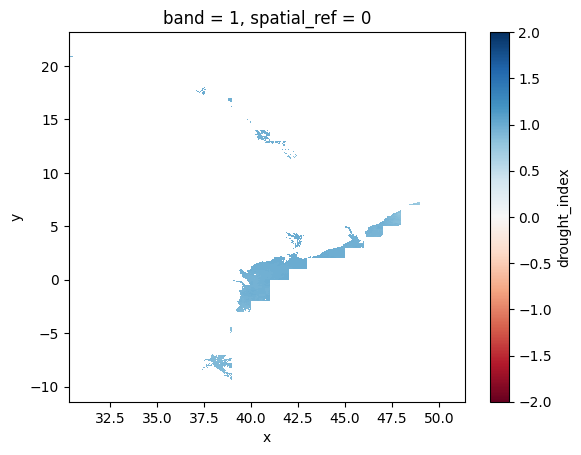

In [142]:
subregion_datasets[first_subregion_id]['drought_index'].sel(time=slice("2011-01-01", "2011-05-31")).mean(dim="time").plot(
    robust=True, cmap="RdBu", vmin=-2, vmax=2)

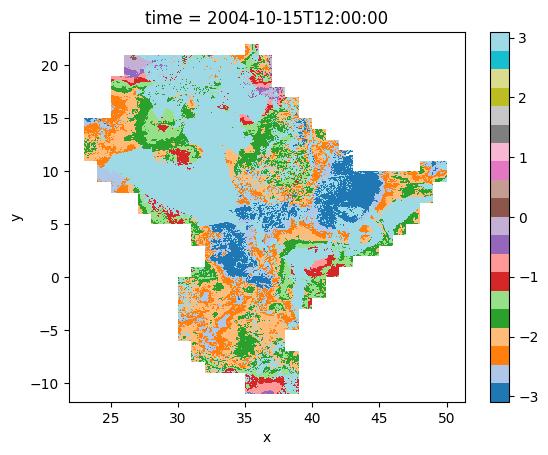

In [358]:
on.isel(time=9).plot(cmap='tab20')

In [350]:
# Example drought index (replace with your actual data)
dates = pd.date_range(start='2004-01-01', end='2023-01-01', freq='M')
drought_index = pd.Series(np.random.uniform(0, 1, len(dates)), index=dates)

In [351]:
drought_threshold = 0.4  # From your example for moderate drought
min_duration_months = 3  # Minimum duration for a drought event
recovery_period_months = 1  # Minimum period to confirm recovery

In [353]:
drought_events = []
in_drought = False
start_idx = None
current_run = []

for i, value in enumerate(on):
    if value < drought_threshold and not in_drought:
        start_idx = i
        in_drought = True
        current_run = [value]
    elif value < drought_threshold and in_drought:
        current_run.append(value)
    elif value >= drought_threshold and in_drought:
        # Check if the run meets the minimum duration
        if len(current_run) >= min_duration:
            # Calculate run sum (severity as cumulative deficit)
            run_sum = np.sum(drought_threshold - np.array(current_run))
            # Check recovery period
            if i + recovery_period <= len(drought_index):
                end_check = drought_index[i:i + recovery_period]
                if all(end_check >= drought_threshold):
                    end_idx = i - 1  # End of the drought run
                    drought_events.append({
                        'Start_Index': start_idx,
                        'End_Index': end_idx,
                        'Duration': len(current_run),  # In time steps
                        'Severity': run_sum  # Cumulative deficit
                    })
        in_drought = False
        current_run = []

# Convert to DataFrame for easier analysis
import pandas as pd
drought_df = pd.DataFrame(drought_events)
print(drought_df)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
ghdi = (os.path.join(dataset, 'results/ghdi.nc'))
ghdi

'../../datasets/results/ghdi.nc'

In [19]:
ghadi = xr.open_dataset(ghdi)

In [24]:
ghadi.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (time: 219, y: 698, x: 591)>
[90341442 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * y        (y) float64 -11.73 -11.68 -11.63 -11.58 ... 22.97 23.02 23.07 23.12
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38

In [40]:
com = xr.open_dataset(os.path.join(dataset, 'combined_data.nc'))

In [41]:
com.data_vars

Data variables:
    tws       (y, x, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    precip    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    et        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    landform  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

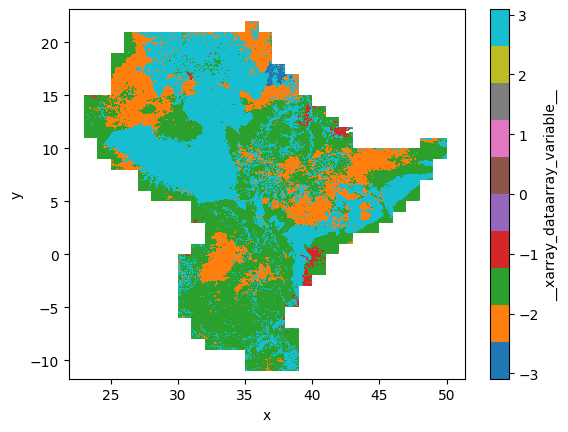

In [38]:
drought_2011 = ghadi['__xarray_dataarray_variable__'].sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time")
drought_2011.rio.to_raster(os.path.join(dataset, 'results/drought_2011.tif'))

drought_2011.plot(
    robust=True, cmap="tab10"
)

## Old Approach

### Regional Anomalies

In [ ]:
def standardized_anomaly(data):
    # Compute monthly climatology
    climatology = data.groupby('time.month').mean(dim='time')
    # Compute standard deviation
    std_dev = data.groupby('time.month').std(dim='time')
    
    # Compute anomaly
    anomaly = data.groupby('time.month') - climatology
    # Standardize anomaly
    standardized_anomaly = anomaly / std_dev
    
    return standardized_anomaly

# Compute standardized anomalies for each dataset
et_anomaly = standardized_anomaly(et_data)
precipitation_anomaly = standardized_anomaly(precipitation_data)
tws_anomaly = standardized_anomaly(tws_data)

In [679]:
# Loop through each subregion
for class_value in subregion_data:
    # Extract raw data for the subregion
    tws = subregion_data[class_value]["tws"]
    et = subregion_data[class_value]["et"]
    precip = subregion_data[class_value]["precip"]

    tws_mean = tws.groupby("time.month").mean("time", skipna=True)
    tws_std = tws.groupby("time.month").std("time", skipna=True)
    
    et_mean = et.groupby("time.month").mean("time", )
    et_std = et.groupby("time.month").std("time", )
    
    precip_mean = precip.groupby("time.month").mean("time", skipna=True)
    precip_std = precip.groupby("time.month").std("time", skipna=True)
    
    # Calculate monthly anomalies
    tws_anomaly = tws.groupby("time.month") - tws_mean
    et_anomaly = et.groupby("time.month") - et_mean
    precip_anomaly = precip.groupby("time.month") - precip_mean

    # Calculate standardized anomalies
    tws_st_anomaly = tws_anomaly / tws_std
    et_st_anomaly = et_anomaly / et_std
    precip_st_anomaly = precip_anomaly / precip_std

    # Store the anomalies
    subregion_data[class_value]["tws_anomaly"] = tws_st_anomaly
    subregion_data[class_value]["et_anomaly"] = et_st_anomaly
    subregion_data[class_value]["precip_anomaly"] = precip_st_anomaly

In [667]:
tq = np.sort(subregion_data_new[1]['tws_anomaly'].values[~np.isnan(subregion_data_new[1]['tws_anomaly'].values)])
print(t)

[-7.83476469 -7.8268617  -7.73760702 ...  6.15291829  6.15577158
  6.16053542]


In [680]:
tqm = np.sort(subregion_data[1]['tws_anomaly'].values[~np.isnan(subregion_data[1]['tws_anomaly'].values)])
print(t)

[-7.83476469 -7.8268617  -7.73760702 ...  6.15291829  6.15577158
  6.16053542]


In [677]:
len(subregion_data_new[1]['tws_anomaly'])

671

In [668]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
# valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[~np.isnan(tws_anomaly_1)]
et_anomaly_1 = et_anomaly_1[~np.isnan(et_anomaly_1)]
precip_anomaly_1 = precip_anomaly_1[~np.isnan(precip_anomaly_1)]

In [669]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

(1410141,) (2638720,) (2806096,)


In [514]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly_q"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly_q"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly_q"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

In [106]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

NameError: name 'tws_anomaly_1' is not defined

In [681]:
# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

In [682]:
print(tws_anomaly_1.shape, et_anomaly_1.shape, precip_anomaly_1.shape)

(901260,) (901260,) (901260,)


In [ ]:
# Assuming landform_classes = [1, 2, 3] (adjust based on your data)
# Process each subregion separately

# Subregion 1 (class_value = 1)
tws_anomaly_1 = subregion_data[1]["tws_anomaly"].values.flatten()
et_anomaly_1 = subregion_data[1]["et_anomaly"].values.flatten()
precip_anomaly_1 = subregion_data[1]["precip_anomaly"].values.flatten()

# Remove NaNs for class 1
valid_1 = ~np.isnan(tws_anomaly_1) & ~np.isnan(et_anomaly_1) & ~np.isnan(precip_anomaly_1)
tws_anomaly_1 = tws_anomaly_1[valid_1]
et_anomaly_1 = et_anomaly_1[valid_1]
precip_anomaly_1 = precip_anomaly_1[valid_1]

# Transform to uniform [0,1] for class 1
u_tws_1 = stats.norm.cdf(tws_anomaly_1)
u_et_1 = stats.norm.cdf(et_anomaly_1)
u_precip_1 = stats.norm.cdf(precip_anomaly_1)

# Store transformed data for class 1
subregion_data[1]["u_tws"] = u_tws_1
subregion_data[1]["u_et"] = u_et_1
subregion_data[1]["u_precip"] = u_precip_1

# Subregion 2 (class_value = 2)
tws_anomaly_2 = subregion_data[2]["tws_anomaly"].values.flatten()
et_anomaly_2 = subregion_data[2]["et_anomaly"].values.flatten()
precip_anomaly_2 = subregion_data[2]["precip_anomaly"].values.flatten()

# Remove NaNs for class 2
valid_2 = ~np.isnan(tws_anomaly_2) & ~np.isnan(et_anomaly_2) & ~np.isnan(precip_anomaly_2)
tws_anomaly_2 = tws_anomaly_2[valid_2]
et_anomaly_2 = et_anomaly_2[valid_2]
precip_anomaly_2 = precip_anomaly_2[valid_2]

# Transform to uniform [0,1] for class 2
u_tws_2 = stats.norm.cdf(tws_anomaly_2)
u_et_2 = stats.norm.cdf(et_anomaly_2)
u_precip_2 = stats.norm.cdf(precip_anomaly_2)

# Store transformed data for class 2
subregion_data[2]["u_tws"] = u_tws_2
subregion_data[2]["u_et"] = u_et_2
subregion_data[2]["u_precip"] = u_precip_2

# Subregion 3 (class_value = 3)
tws_anomaly_3 = subregion_data[3]["tws_anomaly"].values.flatten()
et_anomaly_3 = subregion_data[3]["et_anomaly"].values.flatten()
precip_anomaly_3 = subregion_data[3]["precip_anomaly"].values.flatten()

# Remove NaNs for class 3
valid_3 = ~np.isnan(tws_anomaly_3) & ~np.isnan(et_anomaly_3) & ~np.isnan(precip_anomaly_3)
tws_anomaly_3 = tws_anomaly_3[valid_3]
et_anomaly_3 = et_anomaly_3[valid_3]
precip_anomaly_3 = precip_anomaly_3[valid_3]

# Transform to uniform [0,1] for class 3
u_tws_3 = stats.norm.cdf(tws_anomaly_3)
u_et_3 = stats.norm.cdf(et_anomaly_3)
u_precip_3 = stats.norm.cdf(precip_anomaly_3)

# Store transformed data for class 3
subregion_data[3]["u_tws"] = u_tws_3
subregion_data[3]["u_et"] = u_et_3
subregion_data[3]["u_precip"] = u_precip_3

# Optional: Print to compare at a glance
print("Subregion 1 - Mean u_tws:", u_tws_1.mean(), "u_et:", u_et_1.mean(), "u_precip:", u_precip_1.mean())
print("Subregion 2 - Mean u_tws:", u_tws_2.mean(), "u_et:", u_et_2.mean(), "u_precip:", u_precip_2.mean())
print("Subregion 3 - Mean u_tws:", u_tws_3.mean(), "u_et:", u_et_3.mean(), "u_precip:", u_precip_3.mean())

## Marginal Distribution

#### Clean data and stack

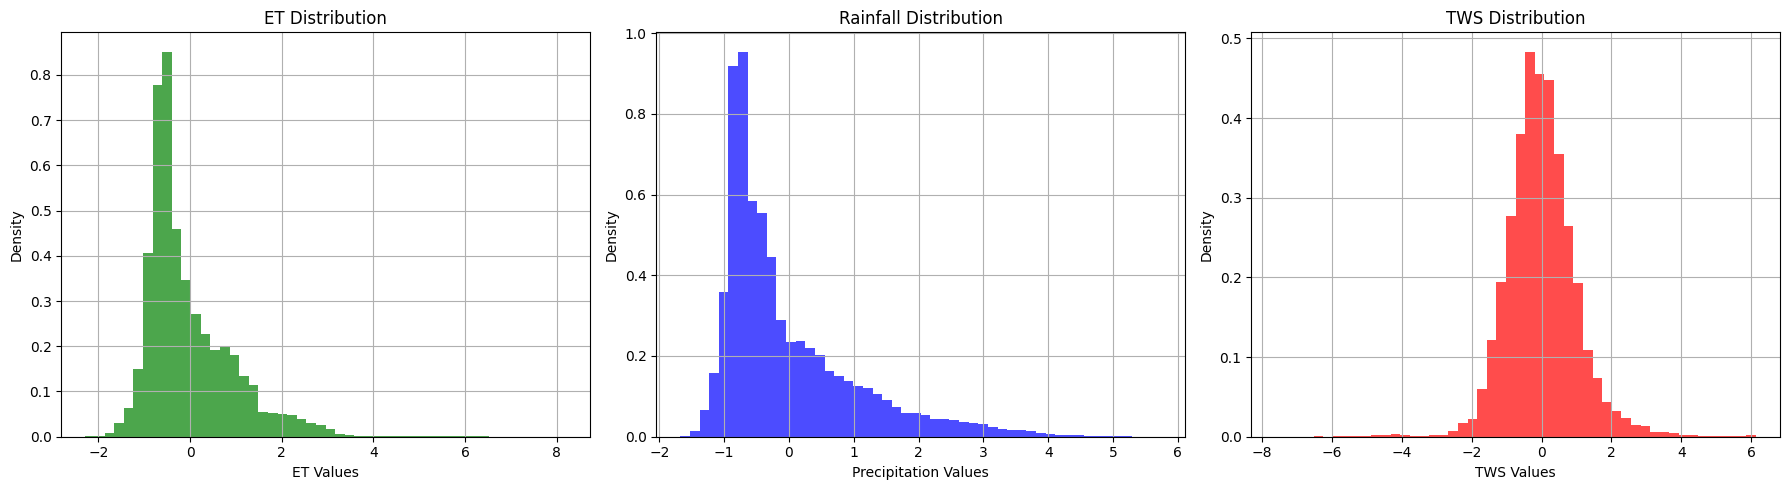

In [516]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


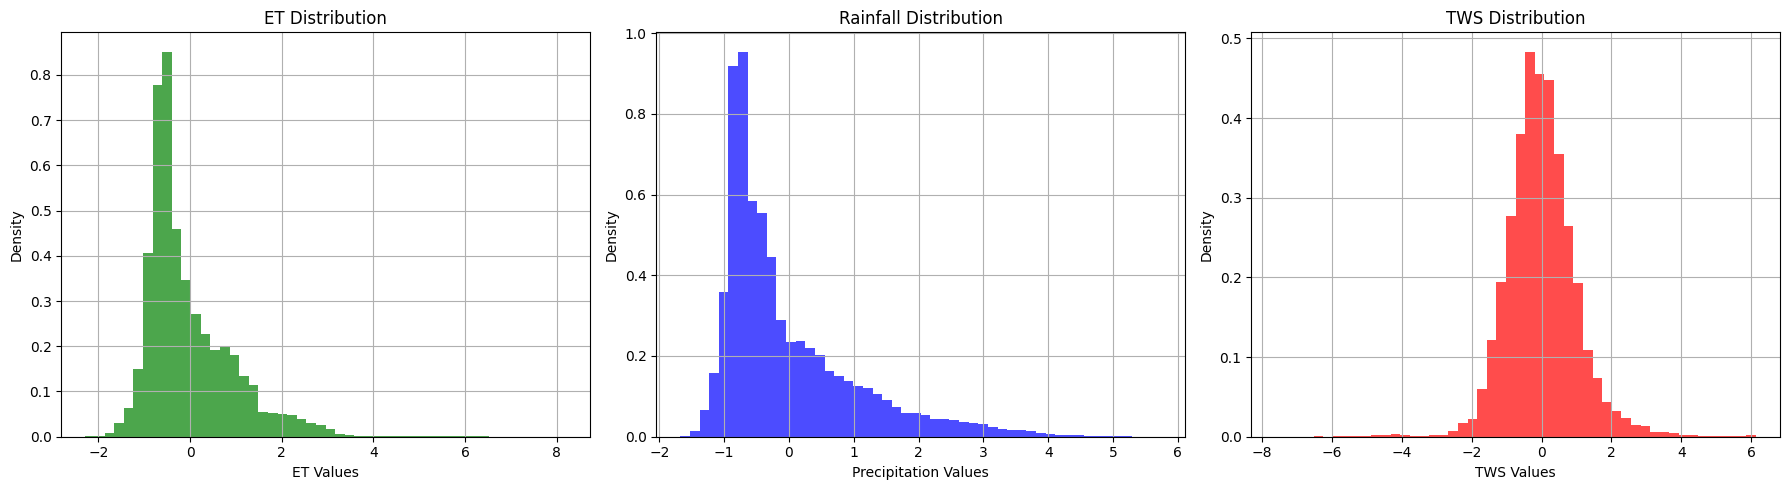

In [517]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_anomaly_1, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_anomaly_1, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_anomaly_1, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [518]:
# Compute ECDF for ET
ecdf_et = ECDF(et_anomaly_1)

# Compute ECDF for Precipitation
ecdf_precip = ECDF(precip_anomaly_1)

# Compute ECDF for TWS
ecdf_twsa = ECDF(tws_anomaly_1)


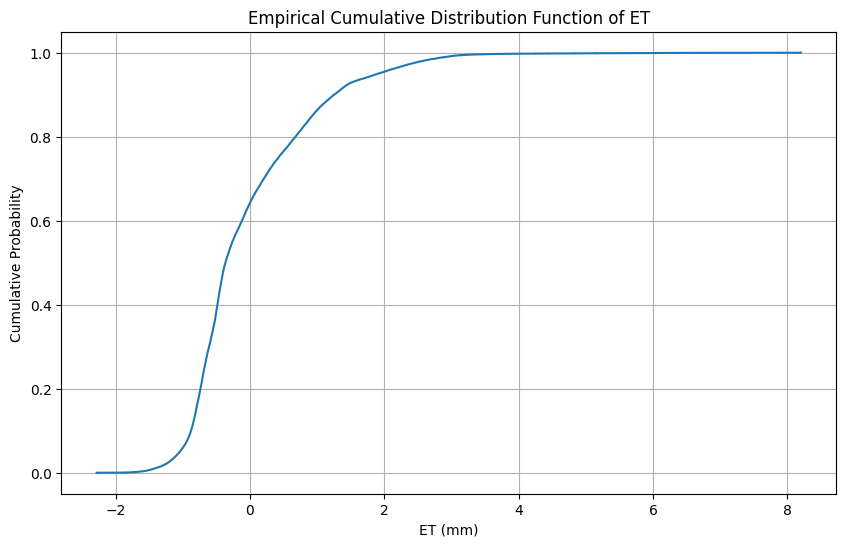

In [519]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

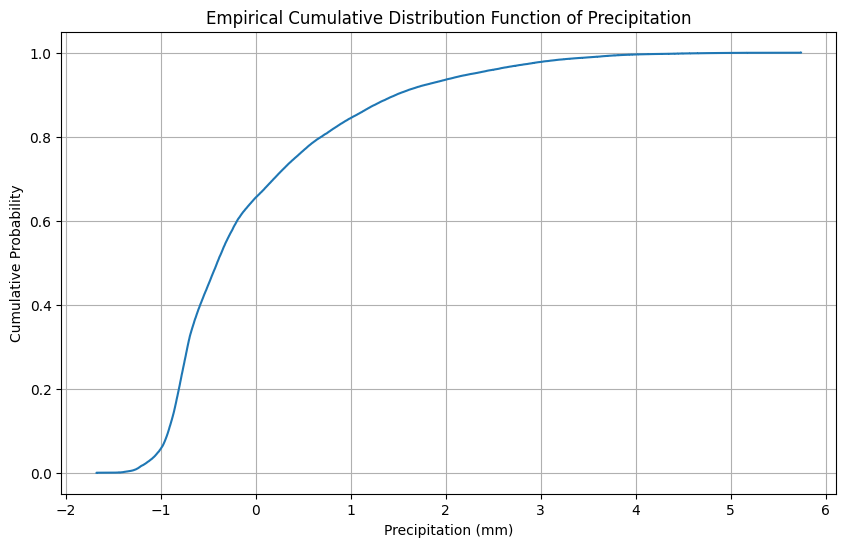

In [520]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_precip.x, ecdf_precip.y, where='post')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of Precipitation')
plt.grid(True)
plt.show()


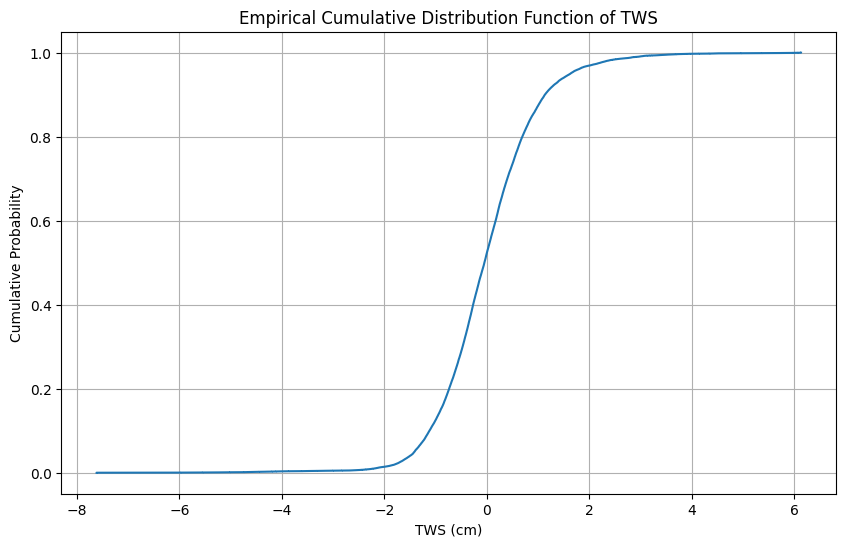

In [521]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_twsa.x, ecdf_twsa.y, where='post')
plt.xlabel('TWS (cm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of TWS')
plt.grid(True)
plt.show()

In [522]:
len(et_anomaly_1)

75105

#### Transform to uniform margin

In [523]:
# Transform TWSA data
uniform_twsa = ecdf_twsa(tws_anomaly_1)

# Transform Precip data
uniform_precip = ecdf_precip(precip_anomaly_1)

# Transform ET data
uniform_et = ecdf_et(et_anomaly_1)


#### Copula Fitting

In [524]:
# Select subset of the data
uniform_data = np.column_stack([uniform_et[:50000], uniform_precip[:50000], uniform_twsa[:50000]])

In [527]:
# Initialize copulas
copulas = {
 # Archimidean Copulas
    "Frank": FrankCopula(dim=3),
    "Clayton": ClaytonCopula(dim=3),
    "Gumbel": GumbelCopula(dim=3),
    
 # Elliptical Copulas
    "Gaussian": GaussianCopula(dim=3), 
    "t-Copula": StudentCopula(dim=3),
}


In [528]:

results = {}
for name, copula in copulas.items():
    try:
        copula.fit(uniform_data)
        
        # log-likelihood
        log_lik = copula.log_lik(uniform_data)
        
        if name == 't-Copula':
            n_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel' or name == 'Frank':
            n_params = np.array(copula.params).size
        elif name == 'Gaussian':
            n_params = copula.params.size
        aic = -2 * log_lik + 2 * n_params
        bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
        
        #
        
        results[name] = {"Log-Likelihood": log_lik, "AIC": aic, "BIC": bic, "Parameters": copula.params}
        print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    except Exception as e:
        print(f"Error fitting {name} Copula: {e}")

# Step 4: Select the best copula
best_copula_aic = min(results.items(), key=lambda x: x[1]["AIC"])
best_copula_bic = min(results.items(), key=lambda x: x[1]["BIC"])

print("\nBest Copula by AIC:")
print(f"Name: {best_copula_aic[0]}, AIC: {best_copula_aic[1]['AIC']:.2f}, Parameters: {best_copula_aic[1]['Parameters']}")
print("Best Copula by BIC:")
print(f"Name: {best_copula_bic[0]}, BIC: {best_copula_bic[1]['BIC']:.2f}, Parameters: {best_copula_bic[1]['Parameters']}")

# Optional: Store the best copula for further use
best_copula_name = best_copula_aic[0]  # or use BIC
best_copula = copulas[best_copula_name]

Error fitting Frank Copula: theta must be positive when dim > 2
Error fitting Clayton Copula: theta must be positive when dim > 2


/home/jovyan/.local/lib/python3.8/site-packages/copulae/archimedean/gumbel.py:165: UserWarning: For the Gumbel copula, tau must be >= 0. Replacing negative values by 0.
  warnings.warn(warning_message)


Gumbel Copula: Log-Likelihood=10.60, AIC=-19.20, BIC=-10.38
Gaussian Copula: Log-Likelihood=4.41, AIC=-2.82, BIC=23.64
t-Copula Copula: Log-Likelihood=2.52, AIC=0.95, BIC=27.41

Best Copula by AIC:
Name: Gumbel, AIC: -19.20, Parameters: 1.0035878695394485
Best Copula by BIC:
Name: Gumbel, BIC: -10.38, Parameters: 1.0035878695394485


### Tail

In [534]:
# 2. Kendall’s Tau Correlation
pairs = [('ET', 'Precip'), ('ET', 'TWS'), ('TWS', 'Precip')]
print("\nKendall's Tau Correlations:")
for var1, var2 in pairs:
    tau, p_value = kendalltau(data[var1], data[var2])
    print(f"{var1} vs {var2}: Tau = {tau:.3f}, p-value = {p_value:.3f}")
    # Note: p-value < 0.05 suggests significant dependence



Kendall's Tau Correlations:
ET vs Precip: Tau = 0.035, p-value = 0.000
ET vs TWS: Tau = 0.002, p-value = 0.408
TWS vs Precip: Tau = -0.001, p-value = 0.732


### Validate the Selected Copula


In [537]:
# Simulate new uniform marginals from the copula
simulated_data = best_copula.random(50000)

In [538]:
simulated_data

array([[0.38624495, 0.10474579, 0.72558786],
       [0.26558991, 0.42073881, 0.83157015],
       [0.73933785, 0.02447972, 0.35062747],
       ...,
       [0.57868411, 0.11488229, 0.26180409],
       [0.59244761, 0.74734307, 0.27589665],
       [0.82235782, 0.09058505, 0.31068397]])

In [539]:
# Validate all pairs
pairs = [("ET", "Precip", 0, 1), ("ET", "TWS", 0, 2), ("Precip", "TWS", 1, 2)]
for var1, var2, idx1, idx2 in pairs:
    tau_obs = kendalltau(uniform_data[:, idx1], uniform_data[:, idx2])[0]
    tau_sim = kendalltau(simulated_data[:, idx1], simulated_data[:, idx2])[0]
    print(f"Observed Tau ({var1}-{var2}): {tau_obs:.3f}, Simulated Tau: {tau_sim:.3f}")

Observed Tau (ET-Precip): 0.002, Simulated Tau: 0.000
Observed Tau (ET-TWS): -0.002, Simulated Tau: 0.003
Observed Tau (Precip-TWS): -0.005, Simulated Tau: -0.002


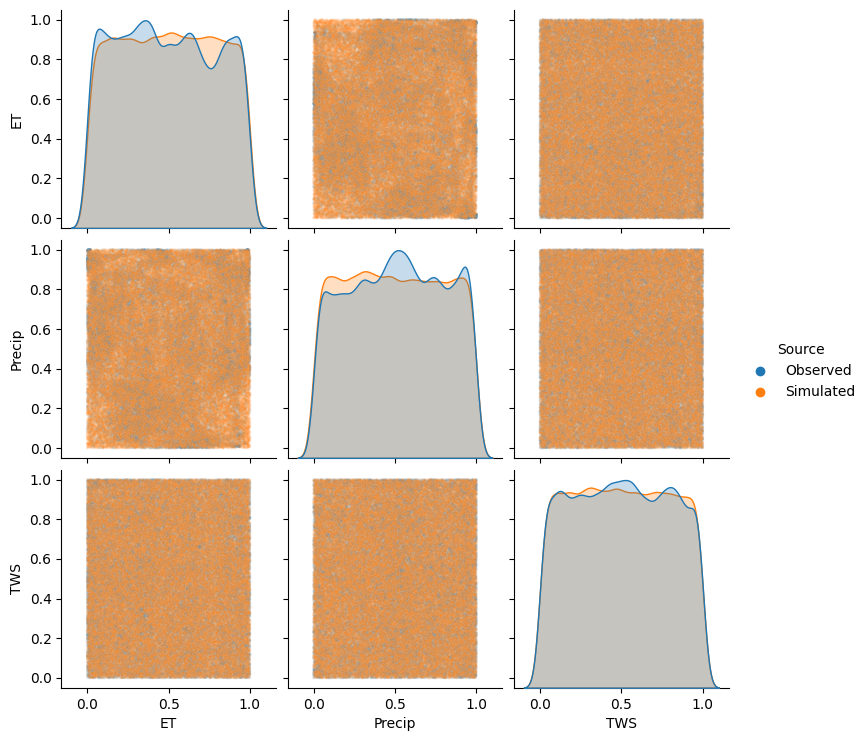

In [540]:
observed_df = pd.DataFrame(uniform_data, columns=["ET", "Precip", "TWS"])
observed_df["Source"] = "Observed"
simulated_df = pd.DataFrame(simulated_data, columns=["ET", "Precip", "TWS"])
simulated_df["Source"] = "Simulated"
combined_df = pd.concat([observed_df.sample(50000, random_state=42), simulated_df])
sns.pairplot(combined_df, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

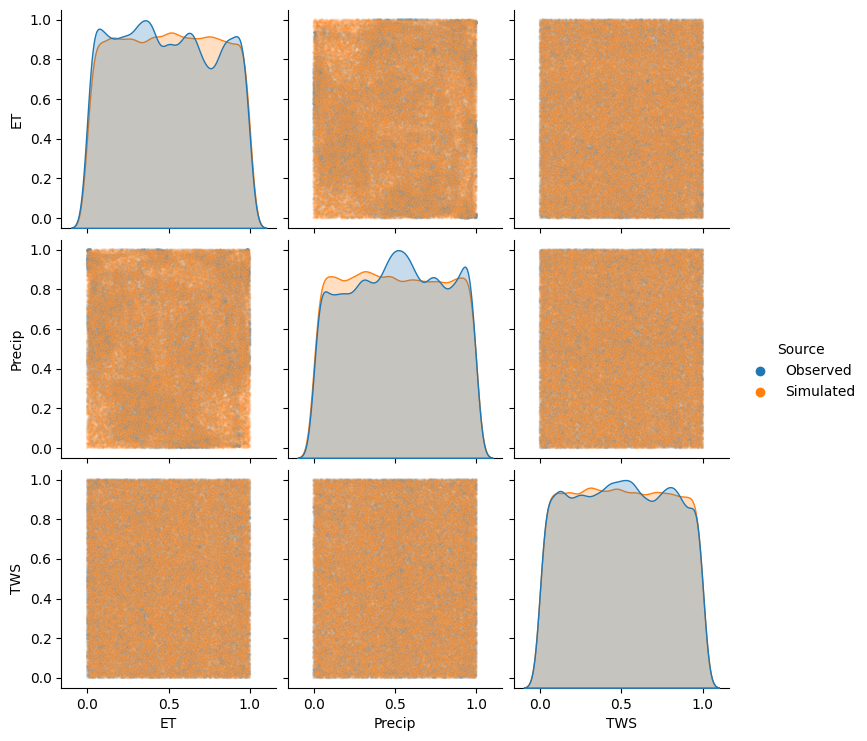

In [541]:
combined_dfn = pd.concat([observed_df[:50000], simulated_df])
sns.pairplot(combined_dfn, hue="Source", diag_kind="kde", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

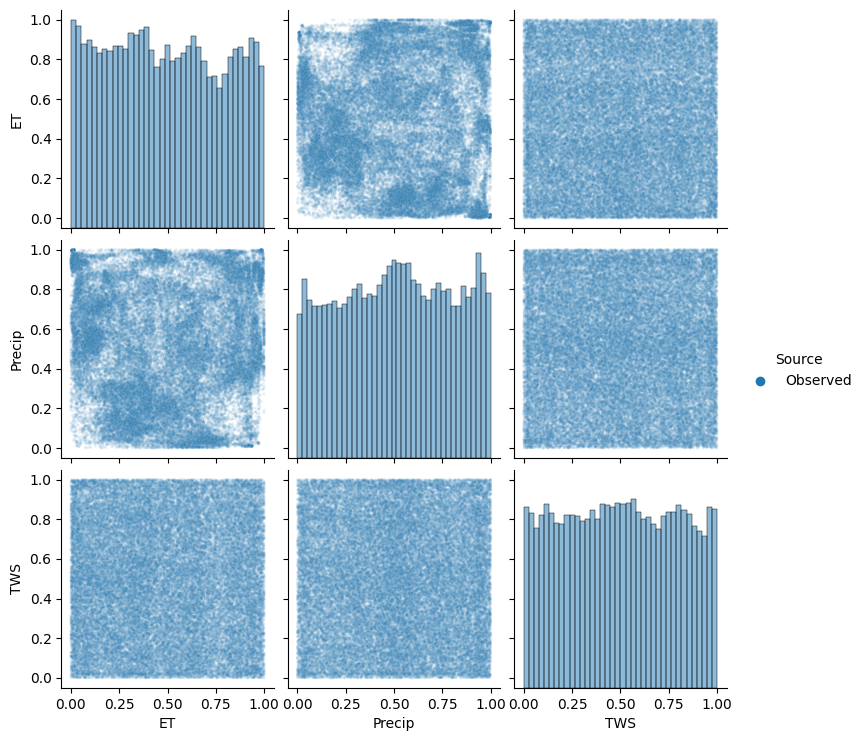

In [630]:
sns.pairplot(observed_df, hue="Source", diag_kind="hist", plot_kws={"alpha": 0.1, "s": 5})
plt.show()

In [ ]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = best_copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

Frank: KS Statistic = 0.007939999999999947, p-value = 0.0001555115240863802
Clayton: KS Statistic = 0.008279999999999954, p-value = 6.798257456388977e-05
Gumbel: KS Statistic = 0.008046666666666646, p-value = 0.0001204043365796208
Gaussian: KS Statistic = 0.008479999999999932, p-value = 4.111215696485771e-05
t-Copula: KS Statistic = 0.009359999999999924, p-value = 3.8991580738464906e-06
